In [4]:
import pandas as pd
import importlib
from tqdm import tqdm
import numpy as np
from utils import *
import torch
from sklearn.metrics.pairwise import cosine_distances
from scipy import spatial
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
project_id = 'dh-global-sales-data-dev'

In [3]:
query = '''
with sf_vendors as 
(select global_entity_id, country_iso, restaurant_city as city, sf_vendor_id as vendor_id, grid_id as sf_grid_id, case when restaurant_name_translated is not null then restaurant_name_translated else restaurant_name end as restaurant_name, 
case when restaurant_address_translated is not null then restaurant_address_translated else restaurant_address_ascii end as restaurant_address,  main_cuisine,
restaurant_lat AS lat,
    restaurant_long AS lng,
    COALESCE(restaurant_lat, city_lat) AS city_lat,
    COALESCE(restaurant_long, city_long) AS city_lng,
    COALESCE(bqcarto.h3.LONGLAT_ASH3(restaurant_long, restaurant_lat, 8), 
             bqcarto.h3.LONGLAT_ASH3(city_long, city_lat, 8)) AS hex_level,
from `dh-global-sales-data.leadgen_cl.vendor_complete` 
where global_entity_id in ("TB_AE") and lead_source = 'salesforce'
and sf_vendor_id is not null and created>'2022-01-01' and vertical in ("Restaurant") and entity_type = "account"
),
vendors_orders as (
  select global_entity_id, 
          vendor_id, 
          sum(successful_orders) as total_orders,
          activation_date, 
          from `dh-global-sales-data.gsd_grade_salesforce.vendor_kpi_cache` 
          where global_entity_id in ("TB_AE") AND
      report_date >= activation_date AND
      DATE_DIFF(report_date, activation_date, DAY) BETWEEN 0 AND 90
      group by 1,2,4
),
dh_menus as (
select global_entity_id,  lead_id , source_item_id as item_id, item_name_ascii, item_description_ascii, item_price, currency, item_name_translated from  `dh-global-sales-data.leadgen_cl.menu_complete` 
where global_entity_id in ("TB_AE") and source_item_id is not null
order by lead_id),

pre_embeddings as (SELECT global_entity_id, vendor_id, product_id, product_embedding,
 ROW_NUMBER () OVER( Partition by global_entity_id, vendor_id, product_id ORDER BY created_date desc) as _rn  
 FROM `dhh-ncr-live.adtech_ds.rel_2_product_embeddings`  
 WHERE
  global_entity_id= 'TB_AE'),

vendor_product_embedding as (select * except(_rn) from pre_embeddings where _rn = 1),

pre_out as (
select sf_vendors.*, vendors_orders.total_orders, vendors_orders.activation_date, dh_menus.* except(global_entity_id, lead_id),
vendor_product_embedding.product_embedding
from sf_vendors 
left join vendors_orders 
on sf_vendors.global_entity_id = vendors_orders.global_entity_id and sf_vendors.vendor_id = vendors_orders.vendor_id
left join dh_menus 
on dh_menus.global_entity_id = sf_vendors.global_entity_id and dh_menus.lead_id = sf_vendors.vendor_id
left join vendor_product_embedding
on dh_menus.global_entity_id = vendor_product_embedding.global_entity_id 
and dh_menus.lead_id = vendor_product_embedding.vendor_id 
and dh_menus.item_id = vendor_product_embedding.product_id
 )

select * from pre_out where item_id is not null 


'''

ae_df = pd.read_gbq(query=query, project_id = project_id, progress_bar_type = 'tqdm')


KeyboardInterrupt



In [ ]:
data_types = ae_df.dtypes.to_dict()

In [24]:
for k,v in d.items():
    if k == 'product_embedding':
        data_types[k] = 'list'
    elif v =='object':
        data_types[k] = 'str'
    elif k == 'activation_date':
        data_types[k] = 'datetime'
    else:
        data_types[k] = 'float'

In [25]:
data_types

{'global_entity_id': 'str',
 'country_iso': 'str',
 'city': 'str',
 'vendor_id': 'str',
 'sf_grid_id': 'str',
 'restaurant_name': 'str',
 'restaurant_address': 'str',
 'main_cuisine': 'str',
 'lat': 'float',
 'lng': 'float',
 'city_lat': 'float',
 'city_lng': 'float',
 'hex_level': 'str',
 'total_orders': 'float',
 'activation_date': 'datetime',
 'item_id': 'str',
 'item_name_ascii': 'str',
 'item_description_ascii': 'str',
 'item_price': 'float',
 'currency': 'str',
 'item_name_translated': 'str',
 'product_embedding': 'list'}

In [26]:
ae_df.to_csv("raw_final_data_AR.csv")

In [5]:
data = pd.read_csv('raw_final_data_AR.csv')


In [8]:
df = data.rename({"item_name_ascii":"items_names","item_description_ascii":"items_descriptions"},axis=1)

In [9]:
df= df[df['main_cuisine'].notna()]
df= df[df['city'].notna()]
df['main_cuisine'] = df['main_cuisine'].apply(lambda x: x.split(";") if x else [""])

In [10]:
df['city'].isna().sum()

0

In [11]:
df.loc['items_names',:] = df['items_names'].apply(lambda x: clean_text(x) if x else x)
df.loc['items_descriptions',:] = df['items_descriptions'].apply(lambda x: clean_text(x) if x else x)


In [12]:
def fix_city(x):
    if x =='رأس الخيمة':
        return "Ras Al Khaima"
    if x == 'دبي':
        return "Dubai"
    if x == 'أبو ظبي':
        return 'Abu Dhabi'
    try:
        return x.lower()
    except: 
        return ''
df['city'] = df['city'].apply(lambda x:fix_city(x))

In [13]:
df=df[df['city']!='']

In [14]:
df['items_names'] = df['items_names'].apply(lambda x: x if x else "")
df['items_descriptions'] = df['items_descriptions'].apply(lambda x: x if x else "")

In [15]:
filtered_df = df.dropna(subset=['items_names'])
filtered_df.head()

Unnamed: 0 global_entity_id country_iso           city  vendor_id  \
0         0.0            TB_AE          AE      abu dhabi   695014.0   
1         1.0            TB_AE          AE      abu dhabi   695014.0   
2         2.0            TB_AE          AE  umm al-quwain   677545.0   
3         3.0            TB_AE          AE      abu dhabi   679240.0   
4         4.0            TB_AE          AE      abu dhabi   679240.0   

  sf_grid_id                       restaurant_name  \
0     HWX0MI                               Ventuno   
1     HWX0MI                               Ventuno   
2     HW0QOE  Lahore Palace Restaurant & Cafeteria   
3     4FIXTB             Starbucks, Al Maqtaa Mall   
4     4FIXTB             Starbucks, Al Maqtaa Mall   

                                  restaurant_address main_cuisine        lat  \
0  Al reem Central Park - Al Reem Island - Shams ...    [Italian]  24.503227   
1  Al reem Central Park - Al Reem Island - Shams ...    [Italian]  24.503227   
2                                                NaN  [Pakistani]  25.506539   
3                  Al Maqtaa Mall, Rabdan, Abu Dhabi     [Coffee]  24.397766   
4                  Al Maqtaa Mall, Rabdan, Abu Dhabi     [Coffee]  24.397766   

   ...        hex_level  total_orders  activation_date       item_id  \
0  ...  8843a02283fffff         323.0       2022-12-22  5.314064e+08   
1  ...  8843a02283fffff         323.0       2022-12-22  5.314065e+08   
2  ...  8843ac1337fffff         569.0       2022-05-31  5.291280e+08   
3  ...  8843a02e25fffff        2525.0       2022-07-17  1.623081e+09   
4  ...  8843a02e25fffff        2525.0       2022-07-17  1.623081e+09   

                                       items_names  \
0                                 cheese croissant   
1                                   cold americano   
2                                         alu naan   
3         tum 16oz s/s terrazzo white w21 11116789   
4  tumbler 16 oz united arab emirates you are here   

                                  items_descriptions  item_price currency  \
0  fesh coissant with bie cheese fom inside and c...        21.0      AED   
1  iced ameicano is efeshing, bold and tasty coff...        20.0      AED   
2                                                NaN         3.0      AED   
3                                                NaN       120.0      AED   
4                                                NaN        70.0      AED   

  item_name_translated                                  product_embedding  
0                  NaN  [-0.05314685 -0.01000848 -0.0954266  -0.106075...  
1                  NaN  [-0.10460141 -0.11697953 -0.12478703 -0.147814...  
2                  NaN  [ 0.06602768  0.07784649  0.03239381 -0.059113...  
3                  NaN                                                 []  
4                  NaN                                                 []  

[5 rows x 23 columns]

In [16]:
item_frequency_df = filtered_df.groupby(['vendor_id', 'item_id']).size().reset_index(name='frequency')

# Step 2: Sort the items by frequency in descending order for each vendor
item_frequency_sorted = item_frequency_df.sort_values(['vendor_id', 'frequency'], ascending=[True, False])

# Step 3: Select up to top 5 items for each vendor
top_items_df = item_frequency_sorted.groupby('vendor_id').apply(lambda x: x.head(5)).reset_index(drop=True)
top_items_df.shape

(70358, 3)

In [17]:
top_items_df.head()

vendor_id       item_id  frequency
0   665620.0  1.962035e+09          1
1   665620.0  1.962035e+09          1
2   665620.0  1.962035e+09          1
3   665620.0  1.962035e+09          1
4   665620.0  1.962035e+09          1

In [18]:
top_items_df = pd.merge(top_items_df, df.drop_duplicates(subset = ['vendor_id','item_id']),
                                on=['vendor_id','item_id'], how='left').drop(['frequency'],axis=1)

In [19]:
top_items_df.shape

(70358, 23)

In [20]:
top_items_df.head(10)

vendor_id       item_id  Unnamed: 0 global_entity_id country_iso  \
0   665620.0  1.962035e+09    822573.0            TB_AE          AE   
1   665620.0  1.962035e+09    105283.0            TB_AE          AE   
2   665620.0  1.962035e+09    540798.0            TB_AE          AE   
3   665620.0  1.962035e+09   1257772.0            TB_AE          AE   
4   665620.0  1.962035e+09    130889.0            TB_AE          AE   
5   665621.0  4.378885e+08    971071.0            TB_AE          AE   
6   665621.0  4.378885e+08    484174.0            TB_AE          AE   
7   665621.0  4.378885e+08    804612.0            TB_AE          AE   
8   665621.0  4.378885e+08    612770.0            TB_AE          AE   
9   665621.0  4.378885e+08     36566.0            TB_AE          AE   

            city sf_grid_id                restaurant_name  \
0        sharjah     HWW0ON                       BOBA NOW   
1        sharjah     HWW0ON                       BOBA NOW   
2        sharjah     HWW0ON                       BOBA NOW   
3        sharjah     HWW0ON                       BOBA NOW   
4        sharjah     HWW0ON                       BOBA NOW   
5  umm al-quwain     4FMKA0  Starbucks, Lulu Umm Al Quwain   
6  umm al-quwain     4FMKA0  Starbucks, Lulu Umm Al Quwain   
7  umm al-quwain     4FMKA0  Starbucks, Lulu Umm Al Quwain   
8  umm al-quwain     4FMKA0  Starbucks, Lulu Umm Al Quwain   
9  umm al-quwain     4FMKA0  Starbucks, Lulu Umm Al Quwain   

                                  restaurant_address  \
0     SHARJAH - MUEWAILEH - BEHIND UNIVERSITY STREET   
1     SHARJAH - MUEWAILEH - BEHIND UNIVERSITY STREET   
2     SHARJAH - MUEWAILEH - BEHIND UNIVERSITY STREET   
3     SHARJAH - MUEWAILEH - BEHIND UNIVERSITY STREET   
4     SHARJAH - MUEWAILEH - BEHIND UNIVERSITY STREET   
5  Mall of UAQ, Plot1/1, Sector 3, Block 23, Umm ...   
6  Mall of UAQ, Plot1/1, Sector 3, Block 23, Umm ...   
7  Mall of UAQ, Plot1/1, Sector 3, Block 23, Umm ...   
8  Mall of UAQ, Plot1/1, Sector 3, Block 23, Umm ...   
9  Mall of UAQ, Plot1/1, Sector 3, Block 23, Umm ...   

                    main_cuisine  ...   city_lng        hex_level  \
0                       [Arabic]  ...  55.468927  8843accf03fffff   
1                       [Arabic]  ...  55.468927  8843accf03fffff   
2                       [Arabic]  ...  55.468927  8843accf03fffff   
3                       [Arabic]  ...  55.468927  8843accf03fffff   
4                       [Arabic]  ...  55.468927  8843accf03fffff   
5  [Beverages, Coffee, Desserts]  ...  55.544433  8843ac136bfffff   
6  [Beverages, Coffee, Desserts]  ...  55.544433  8843ac136bfffff   
7  [Beverages, Coffee, Desserts]  ...  55.544433  8843ac136bfffff   
8  [Beverages, Coffee, Desserts]  ...  55.544433  8843ac136bfffff   
9  [Beverages, Coffee, Desserts]  ...  55.544433  8843ac136bfffff   

   total_orders  activation_date                           items_names  \
0        1232.0       2022-01-13                     original milk tea   
1        1232.0       2022-01-13                     choclate milk tea   
2        1232.0       2022-01-13                       matcha milk tea   
3        1232.0       2022-01-13                         taro milk tea   
4        1232.0       2022-01-13                  wintermelon milk tea   
5        3053.0       2022-01-11  creme brulee brown sugar frappuccino   
6        3053.0       2022-01-11                creme brulee cold brew   
7        3053.0       2022-01-11    iced strawberry cream matcha latte   
8        3053.0       2022-01-11      iced strawberry oat matcha latte   
9        3053.0       2022-01-11                 lemon cheesecake bite   

                                  items_descriptions item_price currency  \
0               oiginal milk tea seved with tapioca.        0.0      AED   
1             chocolate milk tea seved with tapioca.        0.0      AED   
2                matcha milk tea seved with tapioca.        0.0      AED   
3                   tao milk tea seved wit

In [21]:
df_curr = top_items_df

In [22]:
q_25 = df_curr['item_price'].quantile(0.25)
q_50 = df_curr['item_price'].quantile(0.50)
q_75 = df_curr['item_price'].quantile(0.75)

# Define the price range function
def price_range(x):
    if pd.isna(x):
        return "Unknown range"
    if x <= q_25:
        return "cheap range prices"
    elif q_25 < x <= q_50:
        return "lower mid range prices"
    elif q_50 < x <= q_75:
        return "upper mid range prices"
    return "expensive range prices"

# Step 7: Map the average item price to a price range for each vendor
df_curr['price_range'] = df_curr['item_price'].apply(price_range)


In [23]:

def impute_embeddings(group):
    embedding_size=64
    # Find all valid embeddings in the group
    valid_embeddings = [emb for emb in group['product_embedding'] if len(emb) == embedding_size]
    
    if valid_embeddings:
        # Calculate the average embedding if there is at least one valid embedding
        avg_embedding = np.mean(valid_embeddings, axis=0).tolist()
    else:
        # Use a zero vector if no valid embedding exists
        avg_embedding = [0.0] * embedding_size
    
    # Impute missing embeddings with the average embedding
    group['product_embedding'] = group['product_embedding'].apply(
        lambda emb: avg_embedding if len(emb) == 0 else emb
    )
    return group

# Apply the imputation function to each vendor group
df_curr = df_curr.groupby('vendor_id', group_keys=False).apply(impute_embeddings).reset_index(drop=True)


In [24]:
df_curr.head(30)

vendor_id       item_id  Unnamed: 0 global_entity_id country_iso  \
0    665620.0  1.962035e+09    822573.0            TB_AE          AE   
1    665620.0  1.962035e+09    105283.0            TB_AE          AE   
2    665620.0  1.962035e+09    540798.0            TB_AE          AE   
3    665620.0  1.962035e+09   1257772.0            TB_AE          AE   
4    665620.0  1.962035e+09    130889.0            TB_AE          AE   
5    665621.0  4.378885e+08    971071.0            TB_AE          AE   
6    665621.0  4.378885e+08    484174.0            TB_AE          AE   
7    665621.0  4.378885e+08    804612.0            TB_AE          AE   
8    665621.0  4.378885e+08    612770.0            TB_AE          AE   
9    665621.0  4.378885e+08     36566.0            TB_AE          AE   
10   665622.0  4.580635e+08    449478.0            TB_AE          AE   
11   665622.0  4.580635e+08    975074.0            TB_AE          AE   
12   665622.0  4.580635e+08    103955.0            TB_AE          AE   
13   665622.0  4.580635e+08    693294.0            TB_AE          AE   
14   665622.0  4.580635e+08    449476.0            TB_AE          AE   
15   665623.0  5.624087e+08    345492.0            TB_AE          AE   
16   665623.0  5.624087e+08   1241927.0            TB_AE          AE   
17   665623.0  5.624087e+08       405.0            TB_AE          AE   
18   665623.0  5.624087e+08    293994.0            TB_AE          AE   
19   665623.0  5.624087e+08   1114308.0            TB_AE          AE   
20   665624.0  4.372244e+08    513604.0            TB_AE          AE   
21   665624.0  4.372244e+08    539225.0            TB_AE          AE   
22   665624.0  4.372244e+08    654667.0            TB_AE          AE   
23   665624.0  4.372244e+08    552143.0            TB_AE          AE   
24   665624.0  4.372244e+08    180410.0            TB_AE          AE   
25   665625.0  5.624120e+08    382024.0            TB_AE          AE   
26   665625.0  5.624120e+08   1061101.0            TB_AE          AE   
27   665625.0  5.624120e+08    754094.0            TB_AE          AE   
28   665625.0  5.624120e+08    369193.0            TB_AE          AE   
29   665625.0  5.624120e+08    856448.0            TB_AE          AE   

             city sf_grid_id                      restaurant_name  \
0         sharjah     HWW0ON                             BOBA NOW   
1         sharjah     HWW0ON                             BOBA NOW   
2         sharjah     HWW0ON                             BOBA NOW   
3         sharjah     HWW0ON                             BOBA NOW   
4         sharjah     HWW0ON                             BOBA NOW   
5   umm al-quwain     4FMKA0        Starbucks, Lulu Umm Al Quwain   
6   umm al-quwain     4FMKA0        Starbucks, Lulu Umm Al Quwain   
7   umm al-quwain     4FMKA0        Starbucks, Lulu Umm Al Quwain   
8   umm al-quwain     4FMKA0        Starbucks, Lulu Umm Al Quwain   
9   umm al-quwain     4FMKA0        Starbucks, Lulu Umm Al Quwain   
10  umm al-quwain     4FMKAU  Starbucks, Umm Al Quwain Drive Thru   
11  umm al-quwain     4FMKAU  Starbucks, Umm Al Quwain Drive Thru   
12  umm al-quwain     4FMKAU  Starbucks, Umm Al Quwain Drive Thru   
13  umm al-quwain     4FMKAU  Starbucks, Umm Al Quwain Drive Thru   
14  umm al-quwain     4FMKAU  Starbucks, Umm Al Quwain Drive Thru   
15       fujairah     4FMKAY      Starbucks, Fujairah City Center   
16       fujairah     4FMKAY      Starbucks, Fujairah City Center   
17       fujairah     4FMKAY      Starbucks, Fujairah City Center   
18       fujairah     4FMKAY      Starbucks, Fujairah City Center   
19       fujairah     4FMKAY      Starbucks, Fujairah City Center   
20       fujairah     4FMKAJ          Starbucks, Khorfakkan Beach   
21       fujairah     4FMKAJ          Starbucks, Khorfakkan Beach   
22       fujairah     4FMKAJ          Starbucks, Khorfakkan Beach   
23       fujairah     4FMKAJ          Starbucks, Khorfakkan Beach   
24       fujairah     4FMKAJ          Starbuck

In [ ]:
df_final = df_final[df_final['aggregated_embeddings'].apply(lambda x: not all(value == 0 for value in x))]


In [ ]:
def encode_geo_coordinates(lat, lng):
    lat_rad = np.radians(lat)
    lng_rad = np.radians(lng)
    return [np.cos(lat_rad), np.sin(lat_rad), np.cos(lng_rad), np.sin(lng_rad)]
df_final[['cos_lat', 'sin_lat', 'cos_lng', 'sin_lng']] = df_final.apply(lambda row: pd.Series(encode_geo_coordinates(row['lat'], row['lng'])), axis=1)


In [ ]:
df_final.drop(['lng','lat'],axis=1,inplace=True)

In [ ]:
df_final.head()

In [ ]:
df_final = df_final.dropna(subset=[target_column])


In [ ]:
df_final.head()

In [ ]:
df_final['avg_item_price'] = df_final['avg_item_price'].fillna(0)
df_final['max_item_price'] = df_final['max_item_price'].fillna(0)
df_final['min_item_price'] = df_final['min_item_price'].fillna(0)

In [ ]:
avg_item_price_scaler = MinMaxScaler(feature_range=(0, 1))
df_final['avg_item_price'] = avg_item_price_scaler.fit_transform(df_final['avg_item_price'].values.reshape(-1, 1))

max_item_price_scaler = MinMaxScaler(feature_range=(0, 1))
df_final['max_item_price'] = max_item_price_scaler.fit_transform(df_final['max_item_price'].values.reshape(-1, 1))

min_item_price_scaler = MinMaxScaler(feature_range=(0, 1))
df_final['min_item_price'] = min_item_price_scaler.fit_transform(df_final['min_item_price'].values.reshape(-1, 1))


In [ ]:
def scale_aggregated_embeddings(embedding):
    scaler = MinMaxScaler(feature_range=(0, 1))
    embedding_array = np.array(embedding).reshape(-1, 1)
    scaled_embedding = scaler.fit_transform(embedding_array).flatten().tolist()
    return scaled_embedding

# Update aggregated_embeddings to be in range 0,1
df_final['aggregated_embeddings_scaled'] = df_final['aggregated_embeddings'].apply(lambda x: scale_aggregated_embeddings(x))

In [ ]:
def concatenate_features(row):
    aggregated_embeddings = row['aggregated_embeddings_scaled']
    avg_item_price = [row['avg_item_price']]
    max_item_price = [row['max_item_price']]
    min_item_price = [row['min_item_price']]
    cos_lat = [row['cos_lat']]
    sin_lat = [row['sin_lat']]
    cos_lng = [row['cos_lng']]
    sin_lng = [row['sin_lng']]
    return aggregated_embeddings + avg_item_price + max_item_price + min_item_price + cos_lat + sin_lat + cos_lng + sin_lng

df_final['features'] = df_final.apply(concatenate_features, axis=1)


In [ ]:
if df_final['features'].apply(lambda x: any(np.isnan(x))).any():
    print('Warning: NaN values detected in features column. Please clean the data before proceeding.')


In [ ]:
nan_features = df_final[df_final['features'].apply(lambda x: any(np.isnan(x)))]
if not nan_features.empty:
    print('Rows with NaN values in features column:')
    print(nan_features)

In [ ]:
split_date = '2024-04-01'
train_df = df_final[df_final['activation_date'] < split_date]
val_df = df_final[df_final['activation_date'] >= split_date]


In [ ]:
train_df['log_total_orders'] = train_df['total_orders'].apply(lambda x: np.log(x + 1))
val_df['log_total_orders'] = val_df['total_orders'].apply(lambda x: np.log(x + 1))

In [ ]:
train_df['total_orders']

In [ ]:
# Prepare features and target tensors for training and validation datasets
train_features = np.vstack(train_df['features'].values)
train_target_log = np.log(train_df['total_orders'].values + 1)
train_target = train_df['log_total_orders'].values


train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_target_tensor = torch.tensor(train_target, dtype=torch.float32).view(-1, 1)
train_target_log_tensor = torch.tensor(train_target_log, dtype=torch.float32).view(-1, 1)



val_features = np.vstack(val_df['features'].values)
val_target_log = np.log(val_df['total_orders'].values + 1)
val_target = val_df['log_total_orders'].values

val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
val_target_tensor = torch.tensor(val_target, dtype=torch.float32).view(-1, 1)
val_target_log_tensor = torch.tensor(val_target_log, dtype=torch.float32).view(-1, 1)





In [ ]:
class ComplexNN(nn.Module):
    def __init__(self, input_size):
        super(ComplexNN, self).__init__()
        torch.manual_seed(42)  # For reproducibility
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
        # Initialize weights and biases using Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.zeros_(self.fc4.bias)
        nn.init.xavier_uniform_(self.fc5.weight)
        nn.init.zeros_(self.fc5.bias)

    def forward(self, x):
        x = self.dropout1(self.bn1(self.relu(self.fc1(x))))
        x = self.dropout1(self.bn2(self.relu(self.fc2(x))))
        x = self.bn3(self.relu(self.fc3(x)))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
input_size = features_tensor.shape[1]
model = ComplexNN(input_size)
criterion = nn.MSELoss()  # Changed to RMSE by taking square root of loss value
optimizer = optim.Adam(model.parameters(), lr=0.001)

from torch.utils.tensorboard import SummaryWriter


In [ ]:
# Step 4: Training loop with early stopping for loss plateau
writer = SummaryWriter()  # Initialize TensorBoard writer
patience = 5
min_delta = 1e-5
best_loss = float('inf')
patience_counter = 0
epochs = 500

In [ ]:
class RegularizedNN(nn.Module):
    def __init__(self, input_size):
        super(RegularizedNN, self).__init__()
        torch.manual_seed(42)  # For reproducibility
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

        # Initialize weights and biases using Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.zeros_(self.fc4.bias)

    def forward(self, x):
        x = self.dropout1(self.bn1(self.relu(self.fc1(x))))
        x = self.dropout2(self.bn2(self.relu(self.fc2(x))))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
input_size = train_features_tensor.shape[1]
complex_model = ComplexNN(input_size)
regularized_model = RegularizedNN(input_size)

# Training settings
criterion = nn.MSELoss()
complex_optimizer = optim.Adam(complex_model.parameters(), lr=0.001)
regularized_optimizer = optim.Adam(regularized_model.parameters(), lr=0.001)

# Training function

In [ ]:

def train_model(model, optimizer, train_features_tensor, train_target_tensor, val_features_tensor, val_target_tensor, epochs, model_name):
    writer = SummaryWriter()
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        # Training step
        model.train()
        outputs = model(train_features_tensor)
        loss = torch.sqrt(criterion(outputs, train_target_tensor))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation step
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_features_tensor)
            val_loss = torch.sqrt(criterion(val_outputs, val_target_tensor))

        # Store losses
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'{model_name} - Epoch [{epoch + 1}/{epochs}], Training RMSE Loss: {loss.item():.4f}, Validation RMSE Loss: {val_loss.item():.4f}')

    writer.add_scalar('Loss/train', loss.item(), epoch)
    return model, train_losses, val_losses

In [1171]:
complex_modl, complex_train_losses, complex_val_losses = train_model(complex_model, complex_optimizer, train_features_tensor, train_target_tensor, val_features_tensor, val_target_tensor, epochs, 'ComplexNN')
regularised_model, regularized_train_losses, regularized_val_losses = train_model(regularized_model, regularized_optimizer, train_features_tensor, train_target_tensor, val_features_tensor, val_target_tensor, epochs, 'RegularizedNN')


ComplexNN - Epoch [10/500], Training RMSE Loss: 5.2390, Validation RMSE Loss: 5.5040
ComplexNN - Epoch [20/500], Training RMSE Loss: 4.1511, Validation RMSE Loss: 4.8347
ComplexNN - Epoch [30/500], Training RMSE Loss: 3.0604, Validation RMSE Loss: 3.4343
ComplexNN - Epoch [40/500], Training RMSE Loss: 2.1002, Validation RMSE Loss: 2.0236
ComplexNN - Epoch [50/500], Training RMSE Loss: 1.5973, Validation RMSE Loss: 1.4695
ComplexNN - Epoch [60/500], Training RMSE Loss: 1.5154, Validation RMSE Loss: 1.4565
ComplexNN - Epoch [70/500], Training RMSE Loss: 1.4474, Validation RMSE Loss: 1.4230
ComplexNN - Epoch [80/500], Training RMSE Loss: 1.4131, Validation RMSE Loss: 1.4115
ComplexNN - Epoch [90/500], Training RMSE Loss: 1.3937, Validation RMSE Loss: 1.4115
ComplexNN - Epoch [100/500], Training RMSE Loss: 1.3730, Validation RMSE Loss: 1.4027
ComplexNN - Epoch [110/500], Training RMSE Loss: 1.3604, Validation RMSE Loss: 1.4059
ComplexNN - Epoch [120/500], Training RMSE Loss: 1.3450, Valida

RegularizedNN - Epoch [450/500], Training RMSE Loss: 1.3241, Validation RMSE Loss: 1.3417
RegularizedNN - Epoch [460/500], Training RMSE Loss: 1.3170, Validation RMSE Loss: 1.3481
RegularizedNN - Epoch [470/500], Training RMSE Loss: 1.3077, Validation RMSE Loss: 1.3434
RegularizedNN - Epoch [480/500], Training RMSE Loss: 1.3223, Validation RMSE Loss: 1.3447
RegularizedNN - Epoch [490/500], Training RMSE Loss: 1.3103, Validation RMSE Loss: 1.3309
RegularizedNN - Epoch [500/500], Training RMSE Loss: 1.3232, Validation RMSE Loss: 1.3398


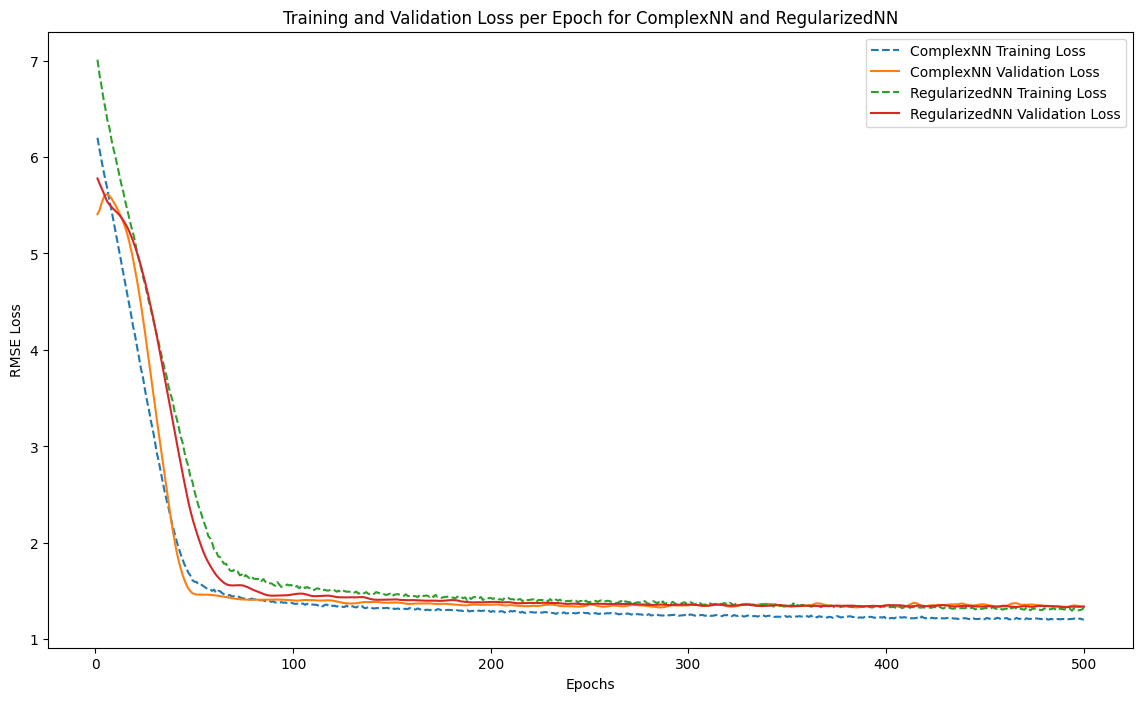

In [1172]:

# Plot training and validation losses for both models
plt.figure(figsize=(14, 8))

# ComplexNN losses
sns.lineplot(x=range(1, epochs + 1), y=complex_train_losses, label='ComplexNN Training Loss', linestyle='--')
sns.lineplot(x=range(1, epochs + 1), y=complex_val_losses, label='ComplexNN Validation Loss')

# RegularizedNN losses
sns.lineplot(x=range(1, epochs + 1), y=regularized_train_losses, label='RegularizedNN Training Loss', linestyle='--')
sns.lineplot(x=range(1, epochs + 1), y=regularized_val_losses, label='RegularizedNN Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('RMSE Loss')
plt.title('Training and Validation Loss per Epoch for ComplexNN and RegularizedNN')
plt.legend()
plt.show()


Epoch [10/50], Training RMSE Loss: 1.5672, Validation RMSE Loss: 1.5362
Epoch 00011: reducing learning rate of group 0 to 5.0000e-03.
Epoch [20/50], Training RMSE Loss: 1.4516, Validation RMSE Loss: 1.4179
Epoch [30/50], Training RMSE Loss: 1.4993, Validation RMSE Loss: 1.4014
Epoch 00035: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00039: reducing learning rate of group 0 to 1.2500e-03.
Epoch [40/50], Training RMSE Loss: 1.2441, Validation RMSE Loss: 1.3779
Validation loss plateau detected. Stopping early at epoch 41.


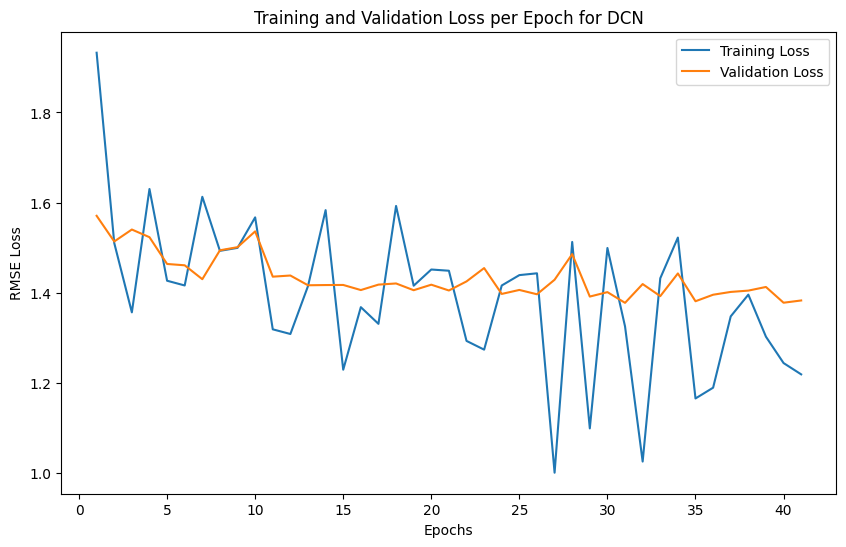

In [1173]:
class DeepCrossNetwork(nn.Module):
    def __init__(self, input_dim, cross_layers=2, deep_hidden_units=[128, 64]):
        super(DeepCrossNetwork, self).__init__()
        self.input_dim = input_dim

        # Cross Network
        self.cross_layers = cross_layers
        self.cross_weights = nn.ParameterList([nn.Parameter(torch.randn(input_dim, 1)) for _ in range(cross_layers)])
        self.cross_biases = nn.ParameterList([nn.Parameter(torch.randn(input_dim)) for _ in range(cross_layers)])

        # Deep Network with Dropout for regularization
        deep_layers = []
        for in_features, out_features in zip([input_dim] + deep_hidden_units[:-1], deep_hidden_units):
            deep_layers.append(nn.Linear(in_features, out_features))
            deep_layers.append(nn.ReLU())
            deep_layers.append(nn.Dropout(0.25))  # Dropout for regularization
        self.deep_net = nn.Sequential(*deep_layers)

        # Final Output Layer
        self.output_layer = nn.Linear(input_dim + deep_hidden_units[-1], 1)  # Concatenate Cross and Deep parts

    def forward(self, x):
        # Cross Network Forward Pass
        cross_out = x
        x_0 = x
        for w, b in zip(self.cross_weights, self.cross_biases):
            cross_out = x_0 * (cross_out @ w) + b + cross_out

        # Deep Network Forward Pass
        deep_out = self.deep_net(x)

        # Concatenate Cross and Deep Outputs
        combined = torch.cat((cross_out, deep_out), dim=1)

        # Final Prediction
        output = self.output_layer(combined)
        return output

# Initialize model, loss function, optimizer, and learning rate scheduler
input_dim = train_features_tensor.shape[1]
dcn_model = DeepCrossNetwork(input_dim, cross_layers=4, deep_hidden_units=[128, 64])
criterion = nn.MSELoss()
optimizer = optim.Adam(dcn_model.parameters(), lr=0.01, weight_decay=1e-4)  # Added weight decay for L2 regularization
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)  # Learning rate scheduler

# Training loop with early stopping for loss plateau
patience = 10  # Increased patience for early stopping
min_delta = 1e-5
best_val_loss = float('inf')
patience_counter = 0
epochs = 50
batch_size = 128  # Mini-batch training

train_losses = []
val_losses = []

for epoch in range(epochs):
    dcn_model.train()

    # Shuffle training data and create mini-batches
    permutation = torch.randperm(train_features_tensor.size(0))
    for i in range(0, train_features_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_features = train_features_tensor[indices]
        batch_targets = train_target_log_tensor[indices]

        # Forward pass for training set
        outputs = dcn_model(batch_features)
        loss = torch.sqrt(criterion(outputs, batch_targets))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    dcn_model.eval()
    with torch.no_grad():
        val_outputs = dcn_model(val_features_tensor)
        val_loss = torch.sqrt(criterion(val_outputs, val_target_log_tensor))

    # Learning rate scheduler step
    scheduler.step(val_loss)

    # Append losses for plotting later
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping based on validation loss
    if best_val_loss - val_loss.item() < min_delta:
        patience_counter += 1
    else:
        patience_counter = 0
        best_val_loss = val_loss.item()

    if patience_counter >= patience:
        print(f'Validation loss plateau detected. Stopping early at epoch {epoch + 1}.')
        break

    # Print every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Training RMSE Loss: {loss.item():.4f}, Validation RMSE Loss: {val_loss.item():.4f}')

# Plot training and validation losses
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Training Loss')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE Loss')
plt.title('Training and Validation Loss per Epoch for DCN')
plt.legend()
plt.show()


In [1174]:
class DeepCrossNetworkHybrid(nn.Module):
    def __init__(self, embedding_dim, continuous_dim, cross_layers=2, deep_hidden_units=[128, 64]):
        super(DeepCrossNetworkHybrid, self).__init__()
        self.embedding_dim = embedding_dim
        self.continuous_dim = continuous_dim

        # Cross Network for embedding features only
        self.cross_layers = cross_layers
        self.cross_weights = nn.ParameterList([nn.Parameter(torch.randn(embedding_dim, 1)) for _ in range(cross_layers)])
        self.cross_biases = nn.ParameterList([nn.Parameter(torch.randn(embedding_dim)) for _ in range(cross_layers)])

        # Deep Network for combined cross output + continuous features
        deep_input_size = embedding_dim + continuous_dim
        deep_layers = []
        for in_features, out_features in zip([deep_input_size] + deep_hidden_units[:-1], deep_hidden_units):
            deep_layers.append(nn.Linear(in_features, out_features))
            deep_layers.append(nn.ReLU())
        self.deep_net = nn.Sequential(*deep_layers)

        # Final Output Layer
        self.output_layer = nn.Linear(deep_hidden_units[-1], 1)  # Output prediction

    def forward(self, embeddings, continuous_features):
        # Cross Network Forward Pass
        cross_out = embeddings
        x_0 = embeddings
        for w, b in zip(self.cross_weights, self.cross_biases):
            cross_out = x_0 * (cross_out @ w) + b + cross_out

        # Concatenate Cross Network output with continuous features
        combined = torch.cat((cross_out, continuous_features), dim=1)

        # Deep Network Forward Pass
        deep_out = self.deep_net(combined)

        # Final Prediction
        output = self.output_layer(deep_out)
        return output


In [1175]:
embedding_features = np.vstack(train_df['aggregated_embeddings_scaled'].values)
continuous_features = train_df[['avg_item_price', 'max_item_price', 'min_item_price', 'cos_lat', 'sin_lat', 'cos_lng', 'sin_lng']].values

# Prepare features and target tensors for training
train_embedding_features_tensor = torch.tensor(embedding_features, dtype=torch.float32)
train_continuous_features_tensor = torch.tensor(continuous_features, dtype=torch.float32)
train_target_tensor = torch.tensor(train_target, dtype=torch.float32).view(-1, 1)


In [1176]:

# For validation dataset
val_embedding_features = np.vstack(val_df['aggregated_embeddings_scaled'].values)
val_continuous_features = val_df[['avg_item_price', 'max_item_price', 'min_item_price', 'cos_lat', 'sin_lat', 'cos_lng', 'sin_lng']].values

val_embedding_features_tensor = torch.tensor(val_embedding_features, dtype=torch.float32)
val_continuous_features_tensor = torch.tensor(val_continuous_features, dtype=torch.float32)
val_target_tensor = torch.tensor(val_target, dtype=torch.float32).view(-1, 1)


In [1177]:
embedding_dim = train_embedding_features_tensor.shape[1]
continuous_dim = train_continuous_features_tensor.shape[1]
dcn_hybrid_model = DeepCrossNetworkHybrid(embedding_dim, continuous_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(dcn_hybrid_model.parameters(), lr=0.001, weight_decay=1e-4)


In [1178]:
patience = 10  # Increased patience for early stopping
min_delta = 1e-5
best_val_loss = float('inf')
patience_counter = 0
epochs = 50
batch_size = 64

train_losses = []
val_losses = []

Epoch [10/50], Training RMSE Loss: 1.3907, Validation RMSE Loss: 1.4629
Epoch [20/50], Training RMSE Loss: 1.5263, Validation RMSE Loss: 1.3785
Validation loss plateau detected. Stopping early at epoch 23.


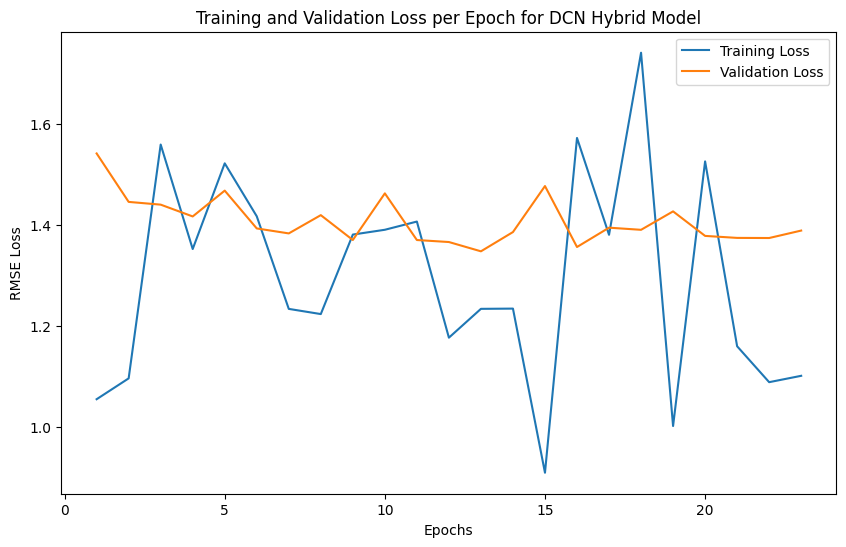

In [1179]:

for epoch in range(epochs):
    dcn_hybrid_model.train()

    # Shuffle training data and create mini-batches
    permutation = torch.randperm(train_embedding_features_tensor.size(0))
    for i in range(0, train_embedding_features_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_embeddings = train_embedding_features_tensor[indices]
        batch_continuous = train_continuous_features_tensor[indices]
        batch_targets = train_target_tensor[indices]

        # Forward pass
        outputs = dcn_hybrid_model(batch_embeddings, batch_continuous)
        loss = torch.sqrt(criterion(outputs, batch_targets))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    dcn_hybrid_model.eval()
    with torch.no_grad():
        val_outputs = dcn_hybrid_model(val_embedding_features_tensor, val_continuous_features_tensor)
        val_loss = torch.sqrt(criterion(val_outputs, val_target_tensor))

    # Learning rate scheduler step (optional)
    # scheduler.step(val_loss)

    # Append losses for monitoring
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping
    if best_val_loss - val_loss.item() < min_delta:
        patience_counter += 1
    else:
        patience_counter = 0
        best_val_loss = val_loss.item()

    if patience_counter >= patience:
        print(f'Validation loss plateau detected. Stopping early at epoch {epoch + 1}.')
        break

    # Print every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Training RMSE Loss: {loss.item():.4f}, Validation RMSE Loss: {val_loss.item():.4f}')

# Plot the training and validation losses
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Training Loss')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE Loss')
plt.title('Training and Validation Loss per Epoch for DCN Hybrid Model')
plt.legend()
plt.show()

In [1180]:
ranked_orders = df_final['total_orders'].rank(method='dense', ascending=False).astype(int)
df_final['rank'] = ranked_orders

# Split the dataset into training and validation datasets based on the activation date
split_date = '2024-03-01'


In [1181]:
 df_final['total_orders']

0        1232
4        9144
6        4057
12       2086
13        336
         ... 
12849      73
12859     544
12881     117
12883      21
12904     265
Name: total_orders, Length: 8242, dtype: Int64

In [1182]:
df_final['rank']

0         987
4          46
6         257
12        605
13       1743
         ... 
12849    2006
12859    1540
12881    1962
12883    2058
12904    1814
Name: rank, Length: 8242, dtype: int64

In [1183]:
from  deepctr_torch.models.dcn import DCN

In [1184]:
df_final.head()

vendor_id activation_date  \
0     665620      2022-01-13   
4     665624      2022-01-10   
6     665628      2022-01-10   
12    665685      2022-01-09   
13    665689      2022-05-19   

                                aggregated_embeddings  total_orders  \
0   [-0.016602826490998267, -0.0026139246299862863...          1232   
4   [0.1102712278564771, 0.1770126869281133, 0.084...          9144   
6   [0.12870299071073532, 0.1921551190316677, 0.07...          4057   
12  [0.14488521218299866, 0.06812545657157898, 0.0...          2086   
13  [0.23975297510623933, 0.14568109512329103, 0.0...           336   

    avg_item_price  max_item_price  min_item_price   cos_lat   sin_lat  \
0         0.000000        0.000000        0.000000  0.904051  0.427424   
4         0.047619        0.031286        0.012255  0.903692  0.428184   
6         0.028571        0.030127        0.012255  0.906258  0.422725   
12        0.006926        0.018540        0.000000  0.911774  0.410693   
13        0.083117        0.063731        0.041667  0.910602  0.413283   

     cos_lng   sin_lng                       aggregated_embeddings_scaled  \
0   0.566853  0.823819  [0.5530327704299057, 0.5766020635421055, 0.488...   
4   0.554063  0.832474  [0.6922577701782906, 0.7918305769219083, 0.653...   
6   0.554123  0.832435  [0.728900185549822, 0.8297088792255246, 0.6470...   
12  0.563208  0.826315  [0.7053113264013442, 0.599443284696538, 0.5570...   
13  0.579412  0.815035  [0.9851280307146002, 0.816764070814229, 0.5633...   

                                             features  rank  
0   [0.5530327704299057, 0.5766020635421055, 0.488...   987  
4   [0.6922577701782906, 0.7918305769219083, 0.653...    46  
6   [0.728900185549822, 0.8297088792255246, 0.6470...   257  
12  [0.7053113264013442, 0.599443284696538, 0.5570...   605  
13  [0.9851280307146002, 0.816764070814229, 0.5633...  1743

In [1185]:
class CrossNet(nn.Module):
    def __init__(self, input_dim, num_layers):
        super(CrossNet, self).__init__()
        self.num_layers = num_layers
        self.w = nn.ModuleList([nn.Linear(input_dim, input_dim) for _ in range(num_layers)])
        self.b = nn.ParameterList([nn.Parameter(torch.zeros(input_dim)) for _ in range(num_layers)])

    def forward(self,x0):
        x = x0
        for i in range(self.num_layers):
            x = self.w[i](x) * x0 + self.b[i] + x
        return x

class DeepCrossNet(nn.Module):
    def __init__(self, input_dim, num_cross_layers, num_deep_layers, deep_layer_sizes, dropout=0.0):
        super(DeepCrossNet, self).__init__()
        self.cross_net = CrossNet(input_dim, num_cross_layers)
        self.deep_layers = nn.Sequential(
            nn.Linear(input_dim, deep_layer_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        for i in range(1, len(deep_layer_sizes)):
            self.deep_layers.add_module(f"Linear_{i}", nn.Linear(deep_layer_sizes[i-1], deep_layer_sizes[i]))
            self.deep_layers.add_module(f"ReLU_{i}", nn.ReLU())
            self.deep_layers.add_module(f"Dropout_{i}", nn.Dropout(dropout))
        self.fc = nn.Linear(deep_layer_sizes[-1] + input_dim, 1)

    def forward(self, x):
        x_0 = x
        x_l0 = self.cross_net(x)
        x_l1 = self.deep_layers(x)
        x_concat = torch.cat([x_l0, x_l1], dim=1)
        output = self.fc(x_concat)
        return output

In [1186]:
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    total_ndcg = 0
    total_map = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_ndcg += ndcg_score(targets.numpy(), outputs.numpy(), k=10)
            total_map += average_precision_score(targets.numpy(), outputs.numpy())
    return total_loss / len(data_loader), total_ndcg / len(data_loader), total_map / len(data_loader)


In [1187]:
df_final.head()

vendor_id activation_date  \
0     665620      2022-01-13   
4     665624      2022-01-10   
6     665628      2022-01-10   
12    665685      2022-01-09   
13    665689      2022-05-19   

                                aggregated_embeddings  total_orders  \
0   [-0.016602826490998267, -0.0026139246299862863...          1232   
4   [0.1102712278564771, 0.1770126869281133, 0.084...          9144   
6   [0.12870299071073532, 0.1921551190316677, 0.07...          4057   
12  [0.14488521218299866, 0.06812545657157898, 0.0...          2086   
13  [0.23975297510623933, 0.14568109512329103, 0.0...           336   

    avg_item_price  max_item_price  min_item_price   cos_lat   sin_lat  \
0         0.000000        0.000000        0.000000  0.904051  0.427424   
4         0.047619        0.031286        0.012255  0.903692  0.428184   
6         0.028571        0.030127        0.012255  0.906258  0.422725   
12        0.006926        0.018540        0.000000  0.911774  0.410693   
13        0.083117        0.063731        0.041667  0.910602  0.413283   

     cos_lng   sin_lng                       aggregated_embeddings_scaled  \
0   0.566853  0.823819  [0.5530327704299057, 0.5766020635421055, 0.488...   
4   0.554063  0.832474  [0.6922577701782906, 0.7918305769219083, 0.653...   
6   0.554123  0.832435  [0.728900185549822, 0.8297088792255246, 0.6470...   
12  0.563208  0.826315  [0.7053113264013442, 0.599443284696538, 0.5570...   
13  0.579412  0.815035  [0.9851280307146002, 0.816764070814229, 0.5633...   

                                             features  rank  
0   [0.5530327704299057, 0.5766020635421055, 0.488...   987  
4   [0.6922577701782906, 0.7918305769219083, 0.653...    46  
6   [0.728900185549822, 0.8297088792255246, 0.6470...   257  
12  [0.7053113264013442, 0.599443284696538, 0.5570...   605  
13  [0.9851280307146002, 0.816764070814229, 0.5633...  1743

In [1188]:
if 'city' not in df_final.columns:
    df_final = df_final.merge(df[['vendor_id','city']].drop_duplicates(),how='left')

In [1189]:
city_avg_orders = df_final.groupby('city')['total_orders'].transform('median')
# Normalize total_orders by city average
df_final['normalized_orders'] = df_final['total_orders'] / city_avg_orders

# Rank vendors based on normalized orders to account for city-level differences
ranked_orders = df_final['normalized_orders'].rank(method='dense', ascending=False).astype(int)
df_final['rank'] = ranked_orders
df_final['global_rank'] = df_final['total_orders'].rank(method='dense', ascending=False).astype(int)


In [1190]:
def create_dataset(df):
    features = df[['aggregated_embeddings_scaled', 'avg_item_price', 'max_item_price', 'min_item_price', 'cos_lat', 'sin_lat', 'cos_lng', 'sin_lng']].values
    targets = df['rank'].values
    return features, targets

In [1191]:
split_date = '2024-03-01'
train_df = df_final[df_final['activation_date']<'2024-03']
val_df = df_final[df_final['activation_date']>='2024-03']


In [1192]:
train_df.head()

vendor_id activation_date  \
0    665620      2022-01-13   
1    665624      2022-01-10   
2    665628      2022-01-10   
3    665685      2022-01-09   
4    665689      2022-05-19   

                               aggregated_embeddings  total_orders  \
0  [-0.016602826490998267, -0.0026139246299862863...          1232   
1  [0.1102712278564771, 0.1770126869281133, 0.084...          9144   
2  [0.12870299071073532, 0.1921551190316677, 0.07...          4057   
3  [0.14488521218299866, 0.06812545657157898, 0.0...          2086   
4  [0.23975297510623933, 0.14568109512329103, 0.0...           336   

   avg_item_price  max_item_price  min_item_price   cos_lat   sin_lat  \
0        0.000000        0.000000        0.000000  0.904051  0.427424   
1        0.047619        0.031286        0.012255  0.903692  0.428184   
2        0.028571        0.030127        0.012255  0.906258  0.422725   
3        0.006926        0.018540        0.000000  0.911774  0.410693   
4        0.083117        0.063731        0.041667  0.910602  0.413283   

    cos_lng   sin_lng                       aggregated_embeddings_scaled  \
0  0.566853  0.823819  [0.5530327704299057, 0.5766020635421055, 0.488...   
1  0.554063  0.832474  [0.6922577701782906, 0.7918305769219083, 0.653...   
2  0.554123  0.832435  [0.728900185549822, 0.8297088792255246, 0.6470...   
3  0.563208  0.826315  [0.7053113264013442, 0.599443284696538, 0.5570...   
4  0.579412  0.815035  [0.9851280307146002, 0.816764070814229, 0.5633...   

                                            features  rank       city  \
0  [0.5530327704299057, 0.5766020635421055, 0.488...  1192    sharjah   
1  [0.6922577701782906, 0.7918305769219083, 0.653...   195   fujairah   
2  [0.728900185549822, 0.8297088792255246, 0.6470...   581   fujairah   
3  [0.7053113264013442, 0.599443284696538, 0.5570...  1001     al ain   
4  [0.9851280307146002, 0.816764070814229, 0.5633...  2796  abu dhabi   

   normalized_orders  global_rank  
0                4.4          987  
1          20.252492           46  
2           8.985604          257  
3            5.31465          605  
4           1.112583         1743

In [1193]:
train_df[train_df['rank']<5]

vendor_id activation_date  \
440     674306      2022-05-22   
5078    722729      2024-01-29   

                                  aggregated_embeddings  total_orders  \
440   [0.20422392338514328, 0.016188996960408986, 0....         30354   
5078  [0.08255919665098191, 0.027012269012629986, -0...         24077   

      avg_item_price  max_item_price  min_item_price   cos_lat   sin_lat  \
440         0.040260        0.026651        0.018382  0.905441  0.424473   
5078        0.052597        0.030707        0.044118  0.905504  0.424338   

       cos_lng   sin_lng                       aggregated_embeddings_scaled  \
440   0.570733  0.821135  [0.9086130509013601, 0.5149110913782677, 0.721...   
5078  0.570757  0.821119  [0.6564503450887762, 0.5715593111074873, 0.330...   

                                               features  rank   city  \
440   [0.9086130509013601, 0.5149110913782677, 0.721...     2  dubai   
5078  [0.6564503450887762, 0.5715593111074873, 0.330...     3  dubai   

      normalized_orders  global_rank  
440          167.701657            5  
5078         133.022099            8

In [1194]:
df_final['log_orders'] = np.log(df_final['total_orders']+1)

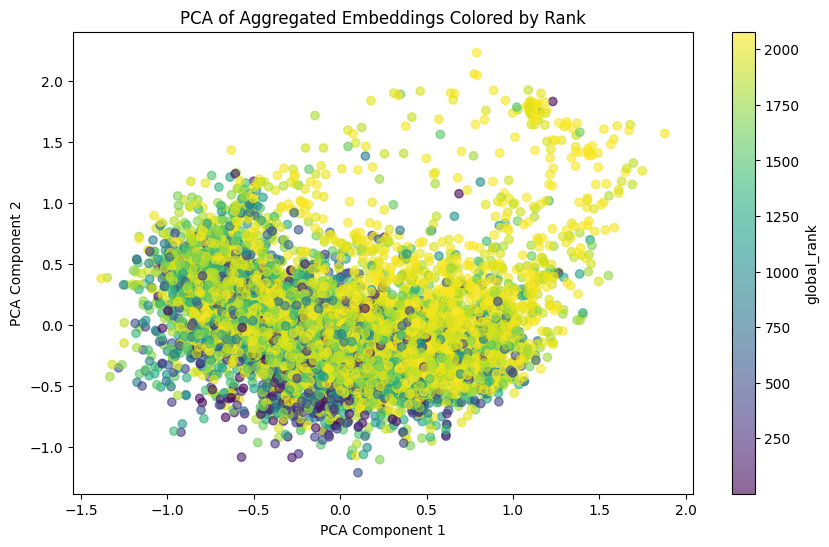

In [1195]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert aggregated embeddings to an array for PCA
embedding_array = np.vstack(df_final['aggregated_embeddings_scaled'].values)

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embedding_array)

# Add reduced embeddings to dataframe for plotting
df_final['pca_1'] = reduced_embeddings[:, 0]
df_final['pca_2'] = reduced_embeddings[:, 1]

# Plot the vendors in the PCA-reduced space
plt.figure(figsize=(10, 6))
plt.scatter(df_final['pca_1'], df_final['pca_2'], c=df_final['global_rank'], cmap='viridis', alpha=0.6)
plt.colorbar(label='global_rank')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Aggregated Embeddings Colored by Rank')
plt.show()


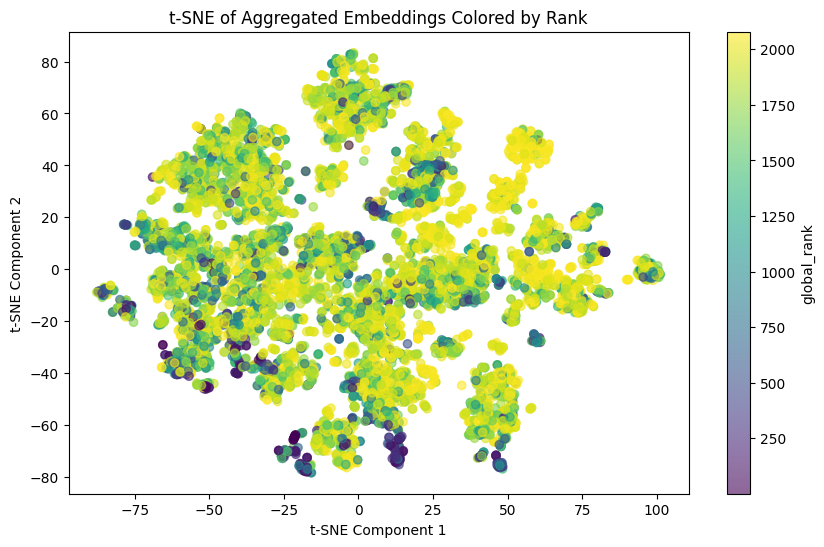

In [1196]:
from sklearn.manifold import TSNE

# Apply t-SNE for a different visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embedding_array)

# Add t-SNE results to dataframe for plotting
df_final['tsne_1'] = tsne_results[:, 0]
df_final['tsne_2'] = tsne_results[:, 1]

# Plot the vendors in the t-SNE-reduced space
plt.figure(figsize=(10, 6))
plt.scatter(df_final['tsne_1'], df_final['tsne_2'], c=df_final['global_rank'], cmap='viridis', alpha=0.6)
plt.colorbar(label='global_rank')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Aggregated Embeddings Colored by Rank')
plt.show()

In [1197]:
df.head()

global_entity_id country_iso           city vendor_id sf_grid_id  \
0            TB_AE          AE      abu dhabi    695014     HWX0MI   
1            TB_AE          AE      abu dhabi    695014     HWX0MI   
2            TB_AE          AE  umm al-quwain    677545     HW0QOE   
3            TB_AE          AE      abu dhabi    679240     4FIXTB   
4            TB_AE          AE      abu dhabi    679240     4FIXTB   

                        restaurant_name  \
0                               Ventuno   
1                               Ventuno   
2  Lahore Palace Restaurant & Cafeteria   
3             Starbucks, Al Maqtaa Mall   
4             Starbucks, Al Maqtaa Mall   

                                  restaurant_address main_cuisine        lat  \
0  Al reem Central Park - Al Reem Island - Shams ...    [Italian]  24.503227   
1  Al reem Central Park - Al Reem Island - Shams ...    [Italian]  24.503227   
2                                               None  [Pakistani]  25.506539   
3                  Al Maqtaa Mall, Rabdan, Abu Dhabi     [Coffee]  24.397766   
4                  Al Maqtaa Mall, Rabdan, Abu Dhabi     [Coffee]  24.397766   

         lng  ...        hex_level  total_orders activation_date     item_id  \
0  54.407583  ...  8843a02283fffff           323      2022-12-22   531406367   
1  54.407583  ...  8843a02283fffff           323      2022-12-22   531406504   
2  55.593283  ...  8843ac1337fffff           569      2022-05-31   529127993   
3  54.498460  ...  8843a02e25fffff          2525      2022-07-17  1623080982   
4  54.498460  ...  8843a02e25fffff          2525      2022-07-17  1623080964   

                                       items_names  \
0                                 cheese croissant   
1                                   cold americano   
2                                         alu naan   
3         tum 16oz s/s terrazzo white w21 11116789   
4  tumbler 16 oz united arab emirates you are here   

                                  items_descriptions item_price currency  \
0  fesh coissant with bie cheese fom inside and c...       21.0      AED   
1  iced ameicano is efeshing, bold and tasty coff...       20.0      AED   
2                                                           3.0      AED   
3                                                         120.0      AED   
4                                                          70.0      AED   

   item_name_translated                                  product_embedding  
0                  None  [-0.0531468465924263, -0.010008477605879307, -...  
1                  None  [-0.1046014055609703, -0.11697953194379807, -0...  
2                  None  [0.0660276785492897, 0.07784648984670639, 0.03...  
3                  None                                                 []  
4                  None                                                 []  

[5 rows x 22 columns]

In [1198]:
sentences = ["Ventuno, abu dhabi, cheese croissant, cold americano, Italian",
            "Lahore Palace Restaurant & Cafeteria, abu dhabi, alu naan, Pakistani",
             "Beshawer Palace, umm al-quwain, Byriani, Pakistani",
            "Naan and Pakistan, abu dhabi, Byriani, Pakistani"]

model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(sentences)
print(embeddings)



[[-0.22666001 -0.27276745  0.06488004 ...  0.00804397  0.12615679
   0.02197322]
 [ 0.39829928  0.02289373 -0.04129208 ...  0.1099386  -0.32588372
  -0.05245511]
 [ 0.34260756  0.3445619   0.11314669 ... -0.03256436  0.00059748
   0.02617843]
 [-0.02103354  0.07689196  0.02332784 ...  0.13060886  0.01171411
   0.12107323]]


In [26]:
grouped_df = df.groupby(['vendor_id','restaurant_name','city']).agg({
    'items_names':lambda x: list(x),
    'item_price': lambda x: np.mean(x) 
}).reset_index().drop_duplicates(['vendor_id','restaurant_name','city']).rename({'item_price':'avg_item_price'},axis=1)
grouped_df.head()

vendor_id                                   restaurant_name       city  \
0   665382.0              BRO STATION RESTAURANT, Business Bay      dubai   
1   665497.0  Rainbow Karak Chai - Since 1955, Jumeirah Street      dubai   
2   665509.0                                   New Street Cafe  abu dhabi   
3   665513.0                                         gogo cafe     al ain   
4   665516.0                                          Burger 7      ajman   

  items_names  avg_item_price  
0       [nan]             NaN  
1       [nan]             NaN  
2       [nan]             NaN  
3       [nan]             NaN  
4       [nan]             NaN

In [27]:
grouped_df.head()

vendor_id                                   restaurant_name       city  \
0   665382.0              BRO STATION RESTAURANT, Business Bay      dubai   
1   665497.0  Rainbow Karak Chai - Since 1955, Jumeirah Street      dubai   
2   665509.0                                   New Street Cafe  abu dhabi   
3   665513.0                                         gogo cafe     al ain   
4   665516.0                                          Burger 7      ajman   

  items_names  avg_item_price  
0       [nan]             NaN  
1       [nan]             NaN  
2       [nan]             NaN  
3       [nan]             NaN  
4       [nan]             NaN

In [28]:
print(grouped_df.shape)
grouped_df = grouped_df.merge(df[['vendor_id','restaurant_name','city', 'main_cuisine']].drop_duplicates(['vendor_id','restaurant_name','city']))
print(grouped_df.shape)


(22440, 5)
(22440, 6)


In [29]:
q_25 = grouped_df['avg_item_price'].quantile(0.25)
q_50 = grouped_df['avg_item_price'].quantile(0.50)
q_75 = grouped_df['avg_item_price'].quantile(0.75)

# Define the price range function
def price_range(x):
    if pd.isna(x):
        return "Unknown price range"
    if x <= q_25:
        return "cheap range prices"
    elif q_25 < x <= q_50:
        return "lower mid range prices"
    elif q_50 < x <= q_75:
        return "upper mid range prices"
    return "expensive range prices"

# Step 7: Map the average item price to a price range for each vendor
grouped_df['price_range'] = grouped_df['avg_item_price'].apply(price_range)


In [1203]:
def create_extended_unified_text(row, description=True):

    restaurant_name = row['restaurant_name'] if row['restaurant_name'] else "unknown"
    
    # Main cuisine
    main_cuisine = ', '.join(row['main_cuisine']) if isinstance(row['main_cuisine'], list) else row['main_cuisine']

    # Item names (limited to top 5 or no items)
    if isinstance(row['items_names'], list) and len(row['items_names']) > 0:
        if len(row['items_names']) > 5: 
            item_names_filtered = row['items_names'][:5]
        else:
            item_names_filtered = row['items_names']
        item_names = ', '.join(item_names_filtered) if item_names_filtered else "no items available"
    else:
        item_names = "no items available"


    # Price range
    price_range_text = row['price_range']

    # City
    city = row['city'] if row['city'] else "unknown city"

    # Create the unified text representation
    if description:
        unified_text = (f"name: {restaurant_name}, City: {city}, Cuisines: {main_cuisine}, "
                    f" Items: {item_names}, "
                    f" Price range: {price_range_text}")
    else:
        unified_text = (f"{restaurant_name}. {city}. {main_cuisine}. {price_range}. "
                    f"{item_names}." )
    return unified_text


In [1204]:
grouped_df['unified_text'] = grouped_df[['restaurant_name','city','main_cuisine','items_names','price_range']].apply(lambda row: create_extended_unified_text(row),axis=1)

In [1205]:
texts = grouped_df['unified_text'].values.tolist()
batch_size = 128
embeddings = []
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
for start_idx in tqdm(range(0, len(texts), batch_size)):
    end_idx = start_idx + batch_size
    batch = texts[start_idx:end_idx]
    embeddings_batch = model.encode(batch)
    embeddings.extend(embeddings_batch)

100%|█████████████████████████████| 176/176 [27:19<00:00,  9.32s/it]


In [1206]:
grouped_df['text_embeddings'] = embeddings

In [1207]:
grouped_df['unified_text'].iloc[0]

'name: BRO STATION RESTAURANT, Business Bay, City: dubai, Cuisines: American,  Items: ,  Price range: Unknown price range'

In [1208]:
grouped_df = grouped_df.merge(df_final[['vendor_id','city','rank','global_rank']].drop_duplicates(),
                             on=['vendor_id','city'])

In [1210]:
grouped_df.head()

vendor_id                     restaurant_name       city  \
0    665620                            BOBA NOW    sharjah   
1    665624         Starbucks, Khorfakkan Beach   fujairah   
2    665628           Starbucks, Kalba Flagpole   fujairah   
3    665685  Flame And Bake Restaurant, Al Jimi     al ain   
4    665689         Zaroob, Khalifa City - AD 7  abu dhabi   

                                         items_names  avg_item_price  \
0  [tapioca pearls, hamimelon smoothie, choclate ...        3.647059   
1  [iced classic chocolate, strawberry  and  crea...       29.486188   
2  [mocha frappuccino, white chocolate mocha chip...       29.894410   
3  [cheesy sauce, vine leaves, lebanese shawarma,...        9.976744   
4  [double decker manoushe, chicken shawarma saj ...       28.560000   

                  main_cuisine             price_range  \
0                     [Arabic]      cheap range prices   
1  [Bakery, Breakfast, Coffee]  upper mid range prices   
2  [Bakery, Breakfast, Coffee]  upper mid range prices   
3                      [Grill]      cheap range prices   
4   [Arabic, Lebanese, Salads]  upper mid range prices   

                                        unified_text  \
0  name: BOBA NOW, City: sharjah, Cuisines: Arabi...   
1  name: Starbucks, Khorfakkan Beach, City: fujai...   
2  name: Starbucks, Kalba Flagpole, City: fujaira...   
3  name: Flame And Bake Restaurant, Al Jimi, City...   
4  name: Zaroob, Khalifa City - AD 7, City: abu d...   

                                     text_embeddings  rank  global_rank  
0  [-0.15648328, -0.1509455, 0.16212544, -0.00829...  1192          987  
1  [-0.11533383, -0.3165274, 0.19023424, 0.311775...   195           46  
2  [-0.07219549, -0.22652984, 0.17975348, 0.30783...   581          257  
3  [0.07480205, 0.15469971, 0.04467969, 0.2778787...  1001          605  
4  [0.17868893, -0.08353879, 0.08687001, -0.00181...  2796         1743

In [1211]:
def scale_aggregated_embeddings(embedding):
    scaler = MinMaxScaler(feature_range=(0, 1))
    embedding_array = np.array(embedding).reshape(-1, 1)
    scaled_embedding = scaler.fit_transform(embedding_array).flatten().tolist()
    return scaled_embedding

# Update aggregated_embeddings to be in range 0,1
grouped_df['text_embeddings_scaled'] = grouped_df['text_embeddings'].apply(lambda x: scale_aggregated_embeddings(x))

# Convert all lists of aggregated embeddings to PyTorch tensors
grouped_df['text_embeddings_torch'] = grouped_df['text_embeddings_scaled'].apply(lambda x: torch.tensor(x, dtype=torch.float32))
#grouped_df['text_embeddings'] = grouped_df['text_embeddings'].apply(lambda x: torch.stack(x))


In [1212]:
grouped_df.head()

vendor_id                     restaurant_name       city  \
0    665620                            BOBA NOW    sharjah   
1    665624         Starbucks, Khorfakkan Beach   fujairah   
2    665628           Starbucks, Kalba Flagpole   fujairah   
3    665685  Flame And Bake Restaurant, Al Jimi     al ain   
4    665689         Zaroob, Khalifa City - AD 7  abu dhabi   

                                         items_names  avg_item_price  \
0  [tapioca pearls, hamimelon smoothie, choclate ...        3.647059   
1  [iced classic chocolate, strawberry  and  crea...       29.486188   
2  [mocha frappuccino, white chocolate mocha chip...       29.894410   
3  [cheesy sauce, vine leaves, lebanese shawarma,...        9.976744   
4  [double decker manoushe, chicken shawarma saj ...       28.560000   

                  main_cuisine             price_range  \
0                     [Arabic]      cheap range prices   
1  [Bakery, Breakfast, Coffee]  upper mid range prices   
2  [Bakery, Breakfast, Coffee]  upper mid range prices   
3                      [Grill]      cheap range prices   
4   [Arabic, Lebanese, Salads]  upper mid range prices   

                                        unified_text  \
0  name: BOBA NOW, City: sharjah, Cuisines: Arabi...   
1  name: Starbucks, Khorfakkan Beach, City: fujai...   
2  name: Starbucks, Kalba Flagpole, City: fujaira...   
3  name: Flame And Bake Restaurant, Al Jimi, City...   
4  name: Zaroob, Khalifa City - AD 7, City: abu d...   

                                     text_embeddings  rank  global_rank  \
0  [-0.15648328, -0.1509455, 0.16212544, -0.00829...  1192          987   
1  [-0.11533383, -0.3165274, 0.19023424, 0.311775...   195           46   
2  [-0.07219549, -0.22652984, 0.17975348, 0.30783...   581          257   
3  [0.07480205, 0.15469971, 0.04467969, 0.2778787...  1001          605   
4  [0.17868893, -0.08353879, 0.08687001, -0.00181...  2796         1743   

                              text_embeddings_scaled  \
0  [0.4548335671424866, 0.45986270904541016, 0.74...   
1  [0.3811281621456146, 0.18382421135902405, 0.68...   
2  [0.4748089611530304, 0.346238911151886, 0.6846...   
3  [0.6776266694068909, 0.7481162548065186, 0.651...   
4  [0.6977537274360657, 0.4727729558944702, 0.618...   

                               text_embeddings_torch  
0  [tensor(0.4548), tensor(0.4599), tensor(0.7442...  
1  [tensor(0.3811), tensor(0.1838), tensor(0.6808...  
2  [tensor(0.4748), tensor(0.3462), tensor(0.6847...  
3  [tensor(0.6776), tensor(0.7481), tensor(0.6511...  
4  [tensor(0.6978), tensor(0.4728), tensor(0.6190...

In [1279]:
grouped_df['unified_text'].iloc[0]

'name: BOBA NOW, City: sharjah, Cuisines: Arabic,  Items: tapioca pearls, hamimelon smoothie, choclate milk tea, taro smoothie, wintermelon milk tea,  Price range: cheap range prices'

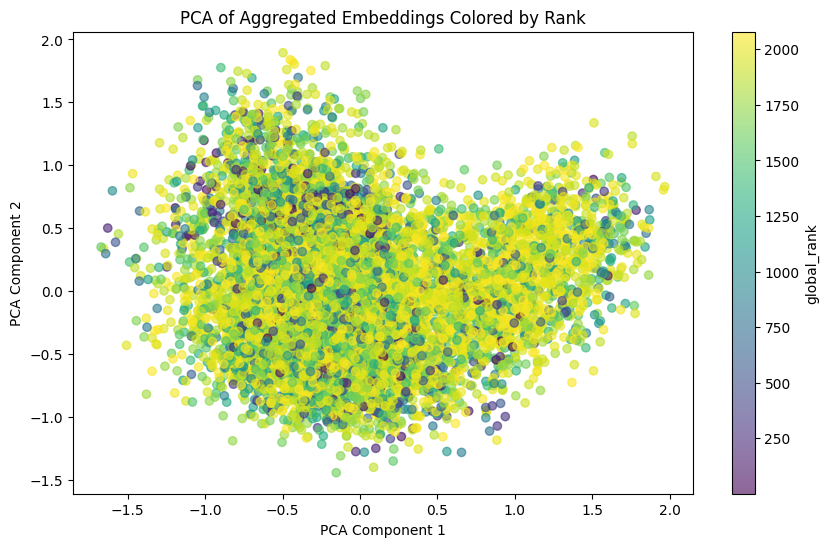

In [1216]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert aggregated embeddings to an array for PCA
embedding_array = np.vstack(grouped_df['text_embeddings'].values)

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embedding_array)

# Add reduced embeddings to dataframe for plotting
grouped_df['pca_1'] = reduced_embeddings[:, 0]
grouped_df['pca_2'] = reduced_embeddings[:, 1]

# Plot the vendors in the PCA-reduced space
plt.figure(figsize=(10, 6))
plt.scatter(grouped_df['pca_1'], grouped_df['pca_2'], c=grouped_df['global_rank'], cmap='viridis', alpha=0.6)
plt.colorbar(label='global_rank')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Aggregated Embeddings Colored by Rank')
plt.show()


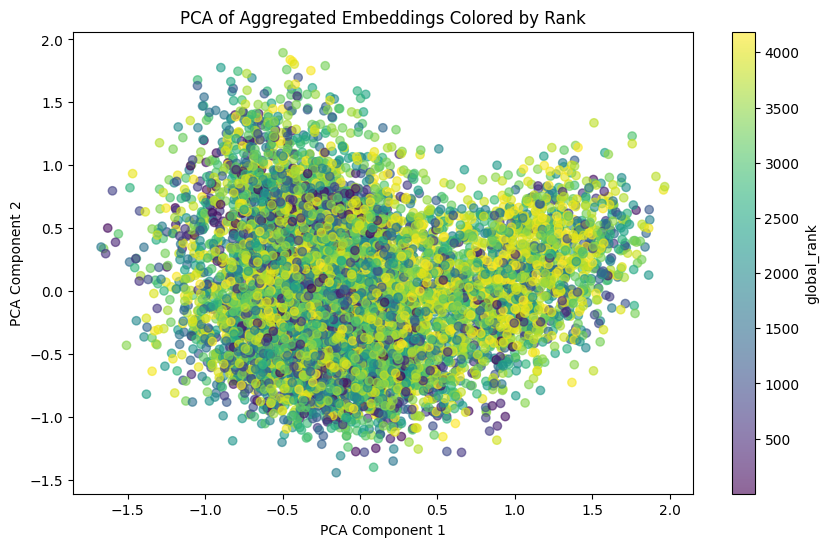

In [1217]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert aggregated embeddings to an array for PCA
embedding_array = np.vstack(grouped_df['text_embeddings'].values)

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_array)

# Add reduced embeddings to dataframe for plotting
grouped_df['pca_1'] = reduced_embeddings[:, 0]
grouped_df['pca_2'] = reduced_embeddings[:, 1]

# Plot the vendors in the PCA-reduced space
plt.figure(figsize=(10, 6))
plt.scatter(grouped_df['pca_1'], grouped_df['pca_2'], c=grouped_df['rank'], cmap='viridis', alpha=0.6)
plt.colorbar(label='global_rank')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Aggregated Embeddings Colored by Rank')
plt.show()


In [1220]:
import torch

def min_max_normalize(tensor):
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    return normalized_tensor
all_embeddings = torch.stack(grouped_df['text_embeddings_torch'].tolist())
# = torch.tensor(all_embeddings, dtype=torch.float32)
#normalized_embeddings = min_max_normalize(embeddings_tensor)

In [32]:
unique_cities = grouped_df['city'].unique()
city_mapping = {city: idx for idx, city in enumerate(unique_cities)}

# Apply the mapping to convert cities into numerical labels
grouped_df['city_encoded'] = grouped_df['city'].map(city_mapping)

In [33]:
grouped_df['price_range_encoded'].fillna(0,inplace=True)


KeyError: 'price_range_encoded'

In [1225]:
import torch
from torch.utils.data import Dataset, DataLoader

class VendorDataset(Dataset):
    def __init__(self, dataframe):
        """
        Args:
            dataframe (DataFrame): Pandas dataframe containing the necessary columns.
        """
        self.dataframe = dataframe
        self.text_embeddings = dataframe['text_embeddings_torch'].values
        self.price_range_encoded = dataframe['price_range_encoded'].values
        self.city_encoded = dataframe['city_encoded'].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Extract the embedding tensor, price range, and city
        embedding = self.text_embeddings[idx]
        price_range = self.price_range_encoded[idx]
        city = self.city_encoded[idx]

        # Convert to torch tensor if necessary
        if not isinstance(embedding, torch.Tensor):
            embedding = torch.tensor(embedding, dtype=torch.float32)
        
        # Convert price range and city labels to torch tensors
        price_range = torch.tensor(int(price_range), dtype=torch.long)
        city = torch.tensor(int(city), dtype=torch.long)

        return embedding, city, price_range

# Create a dataset instance
vendor_dataset = VendorDataset(grouped_df)

In [1227]:
# Step 2: Split dataset into training and validation sets
train_size = int(0.8 * len(vendor_dataset))
val_size = len(vendor_dataset) - train_size
train_dataset, val_dataset = random_split(vendor_dataset, [train_size, val_size])

# Step 3: Create DataLoaders for training and validation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [1228]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, hidden_dim),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [1229]:
def custom_loss_function(output, input, encodings, city_labels, price_labels, lambda_city=2, lambda_price=0.5, margin=1.0):
    # Reconstruction Loss (MSE)
    reconstruction_loss = F.mse_loss(output, input)

    # City Similarity Loss
    city_similarity_loss = 0.0
    n = len(city_labels)
    for i in range(n):
        for j in range(i + 1, n):
            distance = F.mse_loss(encodings[i], encodings[j])
            if city_labels[i] == city_labels[j]:  # Same city, should be closer
                city_similarity_loss += distance
            else:  # Different city, should be farther apart
                city_similarity_loss += F.relu(distance - margin)  # Margin-based distance to keep positive

    # Price Similarity Loss
    price_similarity_loss = 0.0
    for i in range(n):
        for j in range(i + 1, n):
            distance = F.mse_loss(encodings[i], encodings[j])
            price_diff = abs(price_labels[i] - price_labels[j])
            if price_diff == 0:  # Same price range
                price_similarity_loss += distance
            else:  # Different price range, should be farther apart
                price_similarity_loss += F.relu(margin - distance)  # Margin-based distance to keep positive

    # Normalize the similarity losses by the number of comparisons
    if n > 1:
        city_similarity_loss /= (n * (n - 1) / 2)
        price_similarity_loss /= (n * (n - 1) / 2)

    # Combine losses
    total_loss = reconstruction_loss + lambda_city * city_similarity_loss + lambda_price * price_similarity_loss

    return total_loss

In [1230]:
input_dim = train_dataset[0][0].shape[0]
hidden_dim = 256
output_dim = 64
autoencoder = Autoencoder(input_dim, hidden_dim, output_dim)

optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


In [1231]:
# Step 6: Training loop with validation loss calculation
epochs = 500
lambda_city = 0.1
margin = 1
lambda_price = 0.1
for epoch in range(epochs):
    autoencoder.train()  # Set model to training mode
    train_loss = 0.0

    # Training step
    for batch in train_loader:
        embeddings, city_labels, price_labels = batch

        # Forward pass
        output = autoencoder(embeddings)

        # Extract encoded representation
        encodings = autoencoder.encoder(embeddings)

        # Calculate custom loss
        loss = custom_loss_function(output, embeddings, encodings, city_labels, price_labels, lambda_city, lambda_price, margin)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_norm=1.0)

        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item() * embeddings.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    # Validation step
    autoencoder.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for val_batch in val_loader:
            val_embeddings, val_city_labels, val_price_labels = val_batch

            # Forward pass
            val_output = autoencoder(val_embeddings)
            val_encodings = autoencoder.encoder(val_embeddings)

            # Calculate custom loss
            val_batch_loss = custom_loss_function(val_output, val_embeddings, val_encodings, val_city_labels, val_price_labels, lambda_city, lambda_price, margin)
            val_loss += val_batch_loss.item() * val_embeddings.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)

    # Step the scheduler with the validation loss
    scheduler.step(val_loss)

    # Print training and validation losses
    print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch [1/500], Training Loss: 518.2266, Validation Loss: 142.5275
Epoch [2/500], Training Loss: 494.9429, Validation Loss: 134.3553
Epoch [3/500], Training Loss: 479.8077, Validation Loss: 131.0281
Epoch [4/500], Training Loss: 474.8254, Validation Loss: 130.4206
Epoch [5/500], Training Loss: 466.3978, Validation Loss: 125.2621
Epoch [6/500], Training Loss: 461.4835, Validation Loss: 132.4634
Epoch [7/500], Training Loss: 446.8826, Validation Loss: 111.1319
Epoch [8/500], Training Loss: 432.0783, Validation Loss: 107.3230
Epoch [9/500], Training Loss: 423.2157, Validation Loss: 115.0800
Epoch [10/500], Training Loss: 434.4209, Validation Loss: 106.4154
Epoch [11/500], Training Loss: 429.4920, Validation Loss: 105.0923
Epoch [12/500], Training Loss: 424.1532, Validation Loss: 105.6242



KeyboardInterrupt



In [ ]:
autoencoder.eval()

# Step 2: Create a DataLoader for the full dataset
full_loader = DataLoader(vendor_dataset, batch_size=batch_size, shuffle=False)

# Step 3: Initialize a list to store all embeddings
all_embeddings = []

with torch.no_grad():  # Disable gradient calculations for inference
    for batch in full_loader:
        # Extract embeddings from the batch
        embeddings, _, _ = batch  # Only embeddings are needed
        encoded_embeddings = autoencoder.encoder(embeddings)

        # Append the encoded embeddings to the list
        all_embeddings.append(encoded_embeddings)

# Step 4: Concatenate all embeddings into a single tensor
all_embeddings_tensor = torch.cat(all_embeddings, dim=0)

print("Shape of all embeddings:", all_embeddings_tensor.shape)

In [ ]:
all_embeddings_np = all_embeddings_tensor.cpu().numpy()

# Step 3: Compute Cosine Similarity between all vendors
similarity_matrix = cosine_similarity(all_embeddings_np)

# Step 4: Define a function to get the top-k most similar vendors for a given vendor
def get_top_k_similar_vendors(vendor_index, similarity_matrix, k=5):
    """
    Get the top-k most similar vendors for a given vendor based on the similarity matrix.
    
    Args:
        vendor_index (int): Index of the vendor for which we want similar vendors.
        similarity_matrix (np.array): Precomputed similarity matrix.
        k (int): Number of top similar vendors to retrieve.
        
    Returns:
        List of tuples: Each tuple contains (vendor_index, similarity_score), sorted by similarity_score.
    """
    # Extract the similarities for the given vendor
    vendor_similarities = similarity_matrix[vendor_index]
    
    # Get the indices of the top-k most similar vendors (excluding itself)
    top_k_indices = np.argsort(vendor_similarities)[::-1][1:k+1]  # Sort in descending order and skip itself
    
    # Return the indices along with similarity scores
    return [(idx, vendor_similarities[idx]) for idx in top_k_indices]

# Step 5: Example Usage: Get top-5 most similar vendors for vendor at index 0
vendor_index = 0
top_k_similar_vendors = get_top_k_similar_vendors(vendor_index, similarity_matrix, k=5)

print(f"Top-5 most similar vendors to vendor {vendor_index}:")
for idx, score in top_k_similar_vendors:
    print(f"Vendor Index: {idx}, Similarity Score: {score:.4f}")

In [ ]:
grouped_df.iloc[[0,368,1299,455,451,2782]]

In [ ]:
# Step 1: Normalize all embeddings to unit vectors (useful for cosine similarity)
normalized_embeddings = F.normalize(all_embeddings_tensor, p=2, dim=1)

# Step 2: Compute Cosine Similarity using matrix multiplication
# Cosine similarity between each pair of vectors can be computed as the dot product of normalized vectors
cosine_similarity_matrix = torch.matmul(normalized_embeddings, normalized_embeddings.T)

# Step 3: Convert to NumPy if needed for easier handling
cosine_similarity_matrix_np = cosine_similarity_matrix.cpu().numpy()

# Example Usage: Get top-5 similar vendors for vendor at index 0
top_k_similar_vendors_pytorch = get_top_k_similar_vendors(0, cosine_similarity_matrix_np, k=5)

print(f"Top-5 most similar vendors (using PyTorch) to vendor 0:")
for idx, score in top_k_similar_vendors_pytorch:
    print(f"Vendor Index: {idx}, Similarity Score: {score:.4f}")

In [1020]:
def get_top_k_similar_vendors(vendor_index, similarity_matrix, k=5):
    """
    Get the top-k most similar vendors for a given vendor based on the similarity matrix.
    """
    vendor_similarities = similarity_matrix[vendor_index]
    top_k_indices = np.argsort(vendor_similarities)[::-1][1:k+1]  # Sort in descending order, skip itself
    return top_k_indices

def evaluate_city_price_accuracy(vendor_dataset, similarity_matrix, k=5):
    """
    Evaluate the accuracy of the embeddings based on city and price range.

    Args:
        vendor_dataset (Dataset): The dataset containing vendor information.
        similarity_matrix (np.array): Precomputed similarity matrix.
        k (int): Number of top similar vendors to consider.

    Returns:
        city_accuracy (float): Accuracy of vendors being from the same city.
        price_accuracy (float): Accuracy of vendors being in the same price range.
    """
    correct_city_matches = 0
    correct_price_matches = 0
    total_vendors = len(vendor_dataset)

    for vendor_index in range(total_vendors):
        top_k_indices = get_top_k_similar_vendors(vendor_index, similarity_matrix, k)

        # Extract the true labels for city and price range
        target_city = vendor_dataset[vendor_index][1].item()
        target_price_range = vendor_dataset[vendor_index][2].item()

        # Check matches for city and price range
        for idx in top_k_indices:
            similar_city = vendor_dataset[idx][1].item()
            similar_price_range = vendor_dataset[idx][2].item()

            if similar_city == target_city:
                correct_city_matches += 1

            if similar_price_range == target_price_range:
                correct_price_matches += 1

    # Calculate accuracy
    total_comparisons = total_vendors * k
    city_accuracy = correct_city_matches / total_comparisons
    price_accuracy = correct_price_matches / total_comparisons

    return city_accuracy, price_accuracy

In [1039]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),  # Leaky ReLU instead of ReLU
            nn.Linear(hidden_dim, output_dim),
            nn.LeakyReLU(negative_slope=0.01),  # Leaky ReLU instead of ReLU
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),  # Leaky ReLU instead of ReLU
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

        # Xavier initialization for weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # Encoding
        encoded = self.encoder(x)
        # Decoding with skip connection
        decoded = self.decoder(encoded)   # Skip connection
        return decoded

In [1040]:
def updated_custom_loss_function(output, input, encodings, city_labels, price_labels, lambda_city=2.0, lambda_price=2.0, lambda_reconstruction=0.2, margin=1.0):
    # Reconstruction Loss (MSE)
    reconstruction_loss = F.mse_loss(output, input)

    # City Similarity Loss
    city_similarity_loss = 0.0
    n = len(city_labels)
    for i in range(n):
        for j in range(i + 1, n):
            distance = F.mse_loss(encodings[i], encodings[j])
            if city_labels[i] == city_labels[j]:  # Same city, should be closer
                city_similarity_loss += distance
            else:  # Different city, encourage distance to be larger than margin
                city_similarity_loss += F.relu(distance - margin)

    # Price Similarity Loss
    price_similarity_loss = 0.0
    for i in range(n):
        for j in range(i + 1, n):
            distance = F.mse_loss(encodings[i], encodings[j])
            price_diff = abs(price_labels[i] - price_labels[j])
            if price_diff == 0:  # Same price range
                price_similarity_loss += distance
            else:  # Different price range, encourage distance to be larger than margin
                price_similarity_loss += F.relu(distance - margin)

    # Normalize the similarity losses by number of comparisons
    if n > 1:
        city_similarity_loss /= (n * (n - 1) / 2)
        price_similarity_loss /= (n * (n - 1) / 2)


    # Combine losses with weighted contributions
    #print(f"Reconstrunction Loss: {round(reconstruction_loss.item(),2)}")
    #print(f"City Loss: {round(city_similarity_loss.item(),2)}")
    #print(f"Price Loss: {round(price_similarity_loss.item(),2)}")
    total_loss = (
        lambda_reconstruction * reconstruction_loss + 
        lambda_city * city_similarity_loss + 
        lambda_price * price_similarity_loss
    )

    return total_loss

In [1041]:
input_dim = train_dataset[0][0].shape[0]
hidden_dim = 64
output_dim = 32
autoencoder = Autoencoder(input_dim, hidden_dim, output_dim)

optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

epochs = 20
lambda_city = 0.1
lambda_price = 0.1
margin = 1.0

for epoch in range(epochs):
    autoencoder.train()  # Set model to training mode
    train_loss = 0.0

    # Training step
    for batch in train_loader:
        embeddings, city_labels, price_labels = batch

        # Forward pass
        output = autoencoder(embeddings)

        # Extract encoded representation
        encodings = autoencoder.encoder(embeddings)

        # Calculate custom loss
        loss = updated_custom_loss_function(output, embeddings, encodings, city_labels, price_labels, lambda_city, lambda_price, margin)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_norm=1.0)

        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item() * embeddings.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    # Validation step
    autoencoder.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for val_batch in val_loader:
            val_embeddings, val_city_labels, val_price_labels = val_batch

            # Forward pass
            val_output = autoencoder(val_embeddings)
            val_encodings = autoencoder.encoder(val_embeddings)

            # Calculate custom loss
            val_batch_loss = custom_loss_function(val_output, val_embeddings, val_encodings, val_city_labels, val_price_labels, lambda_city, lambda_price, margin)
            val_loss += val_batch_loss.item() * val_embeddings.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)

    # Step the scheduler with the validation loss
    scheduler.step(avg_val_loss)

    # Extract embeddings for the entire dataset
    autoencoder.eval()  # Set model to evaluation mode
    full_loader = DataLoader(vendor_dataset, batch_size=batch_size, shuffle=False)
    all_embeddings = []
    with torch.no_grad():
        for batch in full_loader:
            embeddings, _, _ = batch  # Only embeddings are needed
            encoded_embeddings = autoencoder.encoder(embeddings)
            all_embeddings.append(encoded_embeddings)

    all_embeddings_tensor = torch.cat(all_embeddings, dim=0)

    # Calculate cosine similarity between all embeddings
    normalized_embeddings = F.normalize(all_embeddings_tensor, p=2, dim=1)
    similarity_matrix = torch.matmul(normalized_embeddings, normalized_embeddings.T).cpu().numpy()

    # Evaluate city and price range accuracies
    city_accuracy, price_accuracy = evaluate_city_price_accuracy(vendor_dataset, similarity_matrix, k=5)

    # Print training and validation losses along with city and price accuracies
    print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    print(f"City Accuracy: {city_accuracy:.4f}, Price Range Accuracy: {price_accuracy:.4f}")


Epoch [1/20], Training Loss: 0.0302, Validation Loss: 0.0989
City Accuracy: 0.3592, Price Range Accuracy: 0.2781
Epoch [2/20], Training Loss: 0.0238, Validation Loss: 0.0984
City Accuracy: 0.3384, Price Range Accuracy: 0.2836
Epoch [3/20], Training Loss: 0.0234, Validation Loss: 0.0984
City Accuracy: 0.3605, Price Range Accuracy: 0.2889
Epoch [4/20], Training Loss: 0.0232, Validation Loss: 0.0979
City Accuracy: 0.3483, Price Range Accuracy: 0.2956
Epoch [5/20], Training Loss: 0.0236, Validation Loss: 0.0979
City Accuracy: 0.3453, Price Range Accuracy: 0.3129
Epoch [6/20], Training Loss: 0.0229, Validation Loss: 0.0976
City Accuracy: 0.3613, Price Range Accuracy: 0.3098
Epoch [7/20], Training Loss: 0.0227, Validation Loss: 0.0977
City Accuracy: 0.3639, Price Range Accuracy: 0.3215
Epoch [8/20], Training Loss: 0.0226, Validation Loss: 0.0971
City Accuracy: 0.4190, Price Range Accuracy: 0.3269
Epoch [9/20], Training Loss: 0.0222, Validation Loss: 0.0971
City Accuracy: 0.4313, Price Range 

KeyboardInterrupt: 

In [1232]:
grouped_df.head()

vendor_id                     restaurant_name       city  \
0    665620                            BOBA NOW    sharjah   
1    665624         Starbucks, Khorfakkan Beach   fujairah   
2    665628           Starbucks, Kalba Flagpole   fujairah   
3    665685  Flame And Bake Restaurant, Al Jimi     al ain   
4    665689         Zaroob, Khalifa City - AD 7  abu dhabi   

                                         items_names  avg_item_price  \
0  [tapioca pearls, hamimelon smoothie, choclate ...        3.647059   
1  [iced classic chocolate, strawberry  and  crea...       29.486188   
2  [mocha frappuccino, white chocolate mocha chip...       29.894410   
3  [cheesy sauce, vine leaves, lebanese shawarma,...        9.976744   
4  [double decker manoushe, chicken shawarma saj ...       28.560000   

                  main_cuisine             price_range  \
0                     [Arabic]      cheap range prices   
1  [Bakery, Breakfast, Coffee]  upper mid range prices   
2  [Bakery, Breakfast, Coffee]  upper mid range prices   
3                      [Grill]      cheap range prices   
4   [Arabic, Lebanese, Salads]  upper mid range prices   

                                        unified_text  \
0  name: BOBA NOW, City: sharjah, Cuisines: Arabi...   
1  name: Starbucks, Khorfakkan Beach, City: fujai...   
2  name: Starbucks, Kalba Flagpole, City: fujaira...   
3  name: Flame And Bake Restaurant, Al Jimi, City...   
4  name: Zaroob, Khalifa City - AD 7, City: abu d...   

                                     text_embeddings  rank  global_rank  \
0  [-0.15648328, -0.1509455, 0.16212544, -0.00829...  1192          987   
1  [-0.11533383, -0.3165274, 0.19023424, 0.311775...   195           46   
2  [-0.07219549, -0.22652984, 0.17975348, 0.30783...   581          257   
3  [0.07480205, 0.15469971, 0.04467969, 0.2778787...  1001          605   
4  [0.17868893, -0.08353879, 0.08687001, -0.00181...  2796         1743   

                              text_embeddings_scaled  \
0  [0.4548335671424866, 0.45986270904541016, 0.74...   
1  [0.3811281621456146, 0.18382421135902405, 0.68...   
2  [0.4748089611530304, 0.346238911151886, 0.6846...   
3  [0.6776266694068909, 0.7481162548065186, 0.651...   
4  [0.6977537274360657, 0.4727729558944702, 0.618...   

                               text_embeddings_torch     pca_1     pca_2  \
0  [tensor(0.4548), tensor(0.4599), tensor(0.7442...  0.906700 -0.336192   
1  [tensor(0.3811), tensor(0.1838), tensor(0.6808...  1.507725  0.886031   
2  [tensor(0.4748), tensor(0.3462), tensor(0.6847...  1.437999  0.777976   
3  [tensor(0.6776), tensor(0.7481), tensor(0.6511...  0.481177 -0.043966   
4  [tensor(0.6978), tensor(0.4728), tensor(0.6190... -0.262990 -0.824677   

   price_range_encoded  city_encoded  
0                    1             0  
1                    3             1  
2                    3             1  
3                    1             2  
4                    3             3

In [1233]:
grouped_df['unified_text'].iloc[:3].tolist()

['name: BOBA NOW, City: sharjah, Cuisines: Arabic,  Items: tapioca pearls, hamimelon smoothie, choclate milk tea, taro smoothie, wintermelon milk tea,  Price range: cheap range prices',
 'name: Starbucks, Khorfakkan Beach, City: fujairah, Cuisines: Bakery, Breakfast, Coffee,  Items: iced classic chocolate, strawberry  and  cream frappuccino, starbucks blonde roast by nespresso, tum 12oz s/s leaf w21 11116828, gingerbread coffee frappuccino,  Price range: upper mid range prices',
 'name: Starbucks, Kalba Flagpole, City: fujairah, Cuisines: Bakery, Breakfast, Coffee,  Items: mocha frappuccino, white chocolate mocha chip cream frappuccino, white chocolate mocha, iced white chocolate mocha, chicken  and  cranberry,  Price range: upper mid range prices']

In [1234]:
grouped_df.head()

vendor_id                     restaurant_name       city  \
0    665620                            BOBA NOW    sharjah   
1    665624         Starbucks, Khorfakkan Beach   fujairah   
2    665628           Starbucks, Kalba Flagpole   fujairah   
3    665685  Flame And Bake Restaurant, Al Jimi     al ain   
4    665689         Zaroob, Khalifa City - AD 7  abu dhabi   

                                         items_names  avg_item_price  \
0  [tapioca pearls, hamimelon smoothie, choclate ...        3.647059   
1  [iced classic chocolate, strawberry  and  crea...       29.486188   
2  [mocha frappuccino, white chocolate mocha chip...       29.894410   
3  [cheesy sauce, vine leaves, lebanese shawarma,...        9.976744   
4  [double decker manoushe, chicken shawarma saj ...       28.560000   

                  main_cuisine             price_range  \
0                     [Arabic]      cheap range prices   
1  [Bakery, Breakfast, Coffee]  upper mid range prices   
2  [Bakery, Breakfast, Coffee]  upper mid range prices   
3                      [Grill]      cheap range prices   
4   [Arabic, Lebanese, Salads]  upper mid range prices   

                                        unified_text  \
0  name: BOBA NOW, City: sharjah, Cuisines: Arabi...   
1  name: Starbucks, Khorfakkan Beach, City: fujai...   
2  name: Starbucks, Kalba Flagpole, City: fujaira...   
3  name: Flame And Bake Restaurant, Al Jimi, City...   
4  name: Zaroob, Khalifa City - AD 7, City: abu d...   

                                     text_embeddings  rank  global_rank  \
0  [-0.15648328, -0.1509455, 0.16212544, -0.00829...  1192          987   
1  [-0.11533383, -0.3165274, 0.19023424, 0.311775...   195           46   
2  [-0.07219549, -0.22652984, 0.17975348, 0.30783...   581          257   
3  [0.07480205, 0.15469971, 0.04467969, 0.2778787...  1001          605   
4  [0.17868893, -0.08353879, 0.08687001, -0.00181...  2796         1743   

                              text_embeddings_scaled  \
0  [0.4548335671424866, 0.45986270904541016, 0.74...   
1  [0.3811281621456146, 0.18382421135902405, 0.68...   
2  [0.4748089611530304, 0.346238911151886, 0.6846...   
3  [0.6776266694068909, 0.7481162548065186, 0.651...   
4  [0.6977537274360657, 0.4727729558944702, 0.618...   

                               text_embeddings_torch     pca_1     pca_2  \
0  [tensor(0.4548), tensor(0.4599), tensor(0.7442...  0.906700 -0.336192   
1  [tensor(0.3811), tensor(0.1838), tensor(0.6808...  1.507725  0.886031   
2  [tensor(0.4748), tensor(0.3462), tensor(0.6847...  1.437999  0.777976   
3  [tensor(0.6776), tensor(0.7481), tensor(0.6511...  0.481177 -0.043966   
4  [tensor(0.6978), tensor(0.4728), tensor(0.6190... -0.262990 -0.824677   

   price_range_encoded  city_encoded  
0                    1             0  
1                    3             1  
2                    3             1  
3                    1             2  
4                    3             3

In [1235]:
def get_top_k_similar_vendors(vendor_index, similarity_matrix, k=5):
    """
    Get the top-k most similar vendors for a given vendor based on the similarity matrix.
    
    Args:
        vendor_index (int): Index of the vendor for which we want similar vendors.
        similarity_matrix (np.array): Precomputed similarity matrix.
        k (int): Number of top similar vendors to retrieve.
        
    Returns:
        List of int: Indices of the top-k most similar vendors.
    """
    vendor_similarities = similarity_matrix[vendor_index]
    top_k_indices = np.argsort(vendor_similarities)[::-1][1:k+1]  # Sort in descending order, skip itself
    return top_k_indices

def evaluate_city_price_accuracy(city_labels, price_labels, similarity_matrix, k=5):
    """
    Evaluate the accuracy of the embeddings based on city and price range.

    Args:
        city_labels (np.array): Array of city labels for each vendor.
        price_labels (np.array): Array of price range labels for each vendor.
        similarity_matrix (np.array): Precomputed similarity matrix.
        k (int): Number of top similar vendors to consider.

    Returns:
        city_accuracy (float): Accuracy of vendors being from the same city.
        price_accuracy (float): Accuracy of vendors being in the same price range.
    """
    correct_city_matches = 0
    correct_price_matches = 0
    total_vendors = len(city_labels)

    for vendor_index in range(total_vendors):
        # Get the top-k most similar vendors for the current vendor
        top_k_indices = get_top_k_similar_vendors(vendor_index, similarity_matrix, k)

        # Extract the true labels for city and price range
        target_city = city_labels[vendor_index]
        target_price_range = price_labels[vendor_index]

        # Check matches for city and price range
        for idx in top_k_indices:
            similar_city = city_labels[idx]
            similar_price_range = price_labels[idx]

            if similar_city == target_city:
                correct_city_matches += 1

            if similar_price_range == target_price_range:
                correct_price_matches += 1

    # Calculate accuracy
    total_comparisons = total_vendors * k
    city_accuracy = correct_city_matches / total_comparisons
    price_accuracy = correct_price_matches / total_comparisons

    return city_accuracy, price_accuracy


In [1236]:
# Evaluate city and price range accuracies

all_embeddings_np = np.vstack(grouped_df['text_embeddings'].values)

# Extract city and price range labels from the DataFrame
city_labels = grouped_df['city_encoded'].values
price_labels = grouped_df['price_range_encoded'].values



city_accuracy, price_accuracy = evaluate_city_price_accuracy(city_labels, price_labels, similarity_matrix, k=5)

# Print the results
print(f"City Accuracy: {city_accuracy:.4f}")
print(f"Price Range Accuracy: {price_accuracy:.4f}")


City Accuracy: 0.5198
Price Range Accuracy: 0.3659


In [34]:
grouped_df.head()

vendor_id                                   restaurant_name       city  \
0   665382.0              BRO STATION RESTAURANT, Business Bay      dubai   
1   665497.0  Rainbow Karak Chai - Since 1955, Jumeirah Street      dubai   
2   665509.0                                   New Street Cafe  abu dhabi   
3   665513.0                                         gogo cafe     al ain   
4   665516.0                                          Burger 7      ajman   

  items_names  avg_item_price                main_cuisine  \
0       [nan]             NaN                  [American]   
1       [nan]             NaN             [International]   
2       [nan]             NaN  [Pasta, Pizza, Sandwiches]   
3       [nan]             NaN                    [Arabic]   
4       [nan]             NaN                    [Arabic]   

           price_range  city_encoded  
0  Unknown price range             0  
1  Unknown price range             0  
2  Unknown price range             1  
3  Unknown price range             2  
4  Unknown price range             3

In [35]:
grouped_df.isna().sum()/grouped_df.shape[0]

vendor_id          0.000000
restaurant_name    0.000000
city               0.000000
items_names        0.000000
avg_item_price     0.371346
main_cuisine       0.000000
price_range        0.000000
city_encoded       0.000000
dtype: float64

In [36]:
grouped_df.loc['restaurant_name',:] = grouped_df['restaurant_name'].apply(lambda x: clean_text(x) if x else x)

In [37]:
texts = grouped_df['restaurant_name'].values.tolist()
batch_size = 128
embeddings = []
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
for start_idx in tqdm(range(0, len(texts), batch_size)):
    end_idx = start_idx + batch_size
    batch = texts[start_idx:end_idx]
    embeddings_batch = model.encode(batch)
    embeddings.extend(embeddings_batch)
grouped_df['restaurant_name_encoding'] = embeddings

100%|█████████████████████████████████████████████████████████████| 176/176 [01:56<00:00,  1.51it/s]


In [38]:
grouped_df.dropna(subset=['restaurant_name'],inplace=True)

In [39]:
grouped_df.head()

vendor_id                                   restaurant_name       city  \
0   665382.0              BRO STATION RESTAURANT, Business Bay      dubai   
1   665497.0  Rainbow Karak Chai - Since 1955, Jumeirah Street      dubai   
2   665509.0                                   New Street Cafe  abu dhabi   
3   665513.0                                         gogo cafe     al ain   
4   665516.0                                          Burger 7      ajman   

  items_names  avg_item_price                main_cuisine  \
0       [nan]             NaN                  [American]   
1       [nan]             NaN             [International]   
2       [nan]             NaN  [Pasta, Pizza, Sandwiches]   
3       [nan]             NaN                    [Arabic]   
4       [nan]             NaN                    [Arabic]   

           price_range  city_encoded  \
0  Unknown price range           0.0   
1  Unknown price range           0.0   
2  Unknown price range           1.0   
3  Unknown price range           2.0   
4  Unknown price range           3.0   

                            restaurant_name_encoding  
0  [0.5857936, -0.19378145, -0.040750597, 0.07623...  
1  [0.17608626, 0.2005206, -0.07559678, 0.2467927...  
2  [0.440401, -0.36856106, -0.11363989, 0.4754744...  
3  [-0.10300798, -0.213079, -0.03214855, 0.528804...  
4  [-0.1584457, -0.25889403, -0.27395296, -0.1824...

In [53]:
grouped_df['items_names'] = grouped_df['items_names'].apply(lambda x: ['' if pd.isna(c) else clean_text(c) for c in x])
grouped_df.head(30)

vendor_id                                    restaurant_name  \
0    665382.0               BRO STATION RESTAURANT, Business Bay   
1    665497.0   Rainbow Karak Chai - Since 1955, Jumeirah Street   
2    665509.0                                    New Street Cafe   
3    665513.0                                          gogo cafe   
4    665516.0                                           Burger 7   
5    665531.0                     Eat Showtime Restaurant & Cafe   
6    665620.0                                           BOBA NOW   
7    665621.0                      Starbucks, Lulu Umm Al Quwain   
8    665622.0                Starbucks, Umm Al Quwain Drive Thru   
9    665623.0                    Starbucks, Fujairah City Center   
10   665624.0                        Starbucks, Khorfakkan Beach   
11   665625.0                          Starbucks, Enoc Site 1505   
12   665628.0                          Starbucks, Kalba Flagpole   
13   665629.0                     Starbucks, Forsan Central Mall   
14   665630.0                            Starbucks, Etihad Plaza   
15   665631.0                                Starbucks, Plaza 30   
16   665632.0               Starbucks, Western Region Drive Thru   
17   665633.0                             Starbucks, Ruwais Mall   
18   665634.0                   Starbucks, Al Hamriya Drive Thru   
19   665642.0                                        DOUBLE DOSE   
20   665682.0                                        dalla karak   
21   665685.0                 Flame And Bake Restaurant, Al Jimi   
22   665686.0            Rainbow Karak Chai, Khalifa City - AD 7   
23   665688.0                           DAWAR AL OMDA RESTAURANT   
24   665689.0                        Zaroob, Khalifa City - AD 7   
25   665690.0  Under500 - Healthy, Comfort and Salads, Khalif...   
26   665691.0                      Wok Boyz, Khalifa City - AD 7   
27   665692.0  One Potato Two Potato (OPTP), Khalifa City - AD 7   
28   665693.0              Papa Johns Pizza, Khalifa City - AD 7   
29   665694.0                 Luca - Italian Pasta, Khalifa City   

             city                                        items_names  \
0           dubai                                                 []   
1           dubai                                                 []   
2       abu dhabi                                                 []   
3          al ain                                                 []   
4           ajman                                                 []   
5           dubai                                                 []   
6         sharjah  [tapioca pearls, hamimelon smoothie, choclate ...   
7   umm al-quwain  [hunter hot chili pepper, bottle fresh orange ...   
8   umm al-quwain  [bottle fresh orange juice 330 ml, pink coconu...   
9        fujairah  [iced pumpkin spice latte, burnt basque cheese...   
10       fujairah  [iced classic chocolate, strawberry and cream ...   
11       fujairah  [toffee nut latte, double caramel frappuccino,...   
12       fujairah  [mocha frappuccino, white chocolate mocha chip...   
13      abu dhabi  [dallahs treasure whole bean, roasted chicken ...   
14      abu dhabi  [lemon cheesecake, marble loaf cake, berry boo...   
15      abu dhabi  [reusable plastic cup 16 oz, blueberry muffin,...   
16      abu dhabi  [mini lazy cake, evian mineral water 400 ml, i...   
17      abu dhabi  [buffalo chicken, mug 14 oz abu dhabi you are ...   
18          ajman                                                 []   
19          ajman                                                 []   
20         al ain                                                 []   
21         al ain  [cheesy sauce, vine leaves, lebanese shawarma,...   
22      abu dhabi                                                 []   
23          dubai                                                 []   
24      abu dhabi  [double decker manoushe, chicken shawarma saj ...   
25      abu dhabi  [pro

In [54]:
texts = grouped_df['items_names'].values.tolist()
texts = [text[:5] if len(text)>=5 else text for text in texts]
texts = [', '.join(text) for text in texts]

In [55]:
batch_size = 128
embeddings = []
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
for start_idx in tqdm(range(0, len(texts), batch_size)):
    end_idx = start_idx + batch_size
    batch = texts[start_idx:end_idx]
    embeddings_batch = model.encode(batch)
    embeddings.extend(embeddings_batch)

grouped_df['items_names_encoding'] = embeddings

100%|█████████████████████████████████████████████████████████████| 176/176 [04:07<00:00,  1.41s/it]


In [56]:
grouped_df.head()

vendor_id                                   restaurant_name       city  \
0   665382.0              BRO STATION RESTAURANT, Business Bay      dubai   
1   665497.0  Rainbow Karak Chai - Since 1955, Jumeirah Street      dubai   
2   665509.0                                   New Street Cafe  abu dhabi   
3   665513.0                                         gogo cafe     al ain   
4   665516.0                                          Burger 7      ajman   

  items_names  avg_item_price                main_cuisine  \
0          []             NaN                  [American]   
1          []             NaN             [International]   
2          []             NaN  [Pasta, Pizza, Sandwiches]   
3          []             NaN                    [Arabic]   
4          []             NaN                    [Arabic]   

           price_range  city_encoded  \
0  Unknown price range           0.0   
1  Unknown price range           0.0   
2  Unknown price range           1.0   
3  Unknown price range           2.0   
4  Unknown price range           3.0   

                            restaurant_name_encoding  \
0  [0.5857936, -0.19378145, -0.040750597, 0.07623...   
1  [0.17608626, 0.2005206, -0.07559678, 0.2467927...   
2  [0.440401, -0.36856106, -0.11363989, 0.4754744...   
3  [-0.10300798, -0.213079, -0.03214855, 0.528804...   
4  [-0.1584457, -0.25889403, -0.27395296, -0.1824...   

                                items_names_encoding  
0  [0.22691745, 0.08178422, 0.023542639, -0.03023...  
1  [0.22691745, 0.08178422, 0.023542639, -0.03023...  
2  [0.22691745, 0.08178422, 0.023542639, -0.03023...  
3  [0.22691745, 0.08178422, 0.023542639, -0.03023...  
4  [0.22691745, 0.08178422, 0.023542639, -0.03023...

In [57]:
q_25 = grouped_df['avg_item_price'].quantile(0.25)
q_50 = grouped_df['avg_item_price'].quantile(0.50)
q_75 = grouped_df['avg_item_price'].quantile(0.75)

# Define the price range function
def price_range(x):
    if pd.isna(x):
        return "unknown"
    if x <= q_25:
        return "cheap range prices"
    elif q_25 < x <= q_50:
        return "lower mid range prices"
    elif q_50 < x <= q_75:
        return "upper mid range prices"
    return "expensive range prices"

price_range_mapping = {
    "unknown": 0,
    "cheap range prices": 1,
    "lower mid range prices": 2,
    "upper mid range prices": 3,
    "expensive range prices": 4
}

# Apply the mapping to convert price ranges into numerical labels
grouped_df['price_range'] = grouped_df['avg_item_price'].apply(price_range)

grouped_df['price_range_encoded'] = grouped_df['price_range'].map(price_range_mapping)


In [59]:
texts = grouped_df['price_range'].values.tolist()
batch_size = 128
embeddings = []
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
for start_idx in tqdm(range(0, len(texts), batch_size)):
    end_idx = start_idx + batch_size
    batch = texts[start_idx:end_idx]
    embeddings_batch = model.encode(batch)
    embeddings.extend(embeddings_batch)

grouped_df['price_range_encoding'] = embeddings

100%|█████████████████████████████████████████████████████████████| 176/176 [01:35<00:00,  1.84it/s]


In [60]:
grouped_df[['price_range','price_range_encoded','price_range_encoding']]

price_range  price_range_encoded  \
0                     unknown                    0   
1                     unknown                    0   
2                     unknown                    0   
3                     unknown                    0   
4                     unknown                    0   
...                       ...                  ...   
22435  lower mid range prices                    2   
22436      cheap range prices                    1   
22437      cheap range prices                    1   
22438  lower mid range prices                    2   
22439  lower mid range prices                    2   

                                    price_range_encoding  
0      [0.14114663, -0.103996016, -0.03975716, 0.2968...  
1      [0.14114663, -0.103996016, -0.03975716, 0.2968...  
2      [0.14114663, -0.103996016, -0.03975716, 0.2968...  
3      [0.14114663, -0.103996016, -0.03975716, 0.2968...  
4      [0.14114663, -0.103996016, -0.03975716, 0.2968...  
...                                                  ...  
22435  [0.02085603, 0.14300327, 0.27590653, 0.2029721...  
22436  [-0.22507031, 0.13636334, 0.11771226, 0.088070...  
22437  [-0.22507031, 0.13636334, 0.11771226, 0.088070...  
22438  [0.02085603, 0.14300327, 0.27590653, 0.2029721...  
22439  [0.02085603, 0.14300327, 0.27590653, 0.2029721...  

[22440 rows x 3 columns]

In [61]:
def apply_enc(row):
    if len(row['main_cuisine']) >1 :
        values = ', '.join(row['main_cuisine'])
    else: 
        values = row['main_cuisine'][0]
    return model.encode(values)    
        
grouped_df['main_cuisine_embeddings'] = grouped_df.apply(apply_enc,axis=1)

In [65]:
def fix_city(x):
    if x =='رأس الخيمة':
        return "Ras Al Khaima"
    if x == 'دبي':
        return "Dubai"
    if x == 'أبو ظبي':
        return 'Abu Dhabi'
    if x =='الشارقة':
        return 'Sharjah'
    if x == 'عجمان':
        return 'Ajman'
    if x == 'الفجيرة':
        return 'Fujairah'
    if x =='الرفاعة':
        return 'Rafaa'
    if x =='البدع':
        return "Badaa"
    if x == 'السلمة':
        return 'Salma'
    return x
def preprocess_cities(x):
    if x =='ras al khaimah':
        return 'ras al khaima'
    if x =='al sharjah':
        return 'sharjah'
    return x
grouped_df['city'] = grouped_df['city'].apply(lambda x:preprocess_cities(fix_city(x).lower().replace('-',' ')))


In [66]:
grouped_df['city'].value_counts()

dubai            11930
abu dhabi         4434
sharjah           2061
al ain            1325
ajman             1180
ras al khaima      738
fujairah           612
umm al quwain      155
khawr fakkan         4
kalba                1
Name: city, dtype: int64

In [67]:
texts = grouped_df['city'].values.tolist()
batch_size = 128
embeddings = []
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
for start_idx in tqdm(range(0, len(texts), batch_size)):
    end_idx = start_idx + batch_size
    batch = texts[start_idx:end_idx]
    embeddings_batch = model.encode(batch)
    embeddings.extend(embeddings_batch)

grouped_df['city_name_encoding'] = embeddings

100%|█████████████████████████████████████████████████████████████| 176/176 [01:32<00:00,  1.90it/s]


In [96]:
unique_cities = grouped_df['city'].unique()
city_mapping = {city: idx for idx, city in enumerate(unique_cities)}

# Apply the mapping to convert cities into numerical labels
grouped_df['city_encoded'] = grouped_df['city'].map(city_mapping)

In [124]:
grouped_df.shape

(22440, 15)

In [128]:
grouped_df['avg_item_price'].isna().sum()/grouped_df.shape[0]


0.3713458110516934

In [129]:
grouped_df[grouped_df['avg_item_price'].isna()]['city'].value_counts()

dubai            4468
abu dhabi        1499
sharjah           818
al ain            522
ajman             506
ras al khaima     269
fujairah          197
umm al quwain      53
khawr fakkan        1
Name: city, dtype: int64

In [131]:
grouped_df['price_range'].value_counts()

unknown                   8333
cheap range prices        3529
expensive range prices    3527
upper mid range prices    3526
lower mid range prices    3525
Name: price_range, dtype: int64

In [99]:
def create_combined_embeddings(row):
    """
    Concatenate various embeddings into a single combined embedding for each vendor.

    Args:
        row: A single row from the DataFrame containing individual embeddings.

    Returns:
        combined_embedding: A 1D array representing the concatenated embedding.
    """
    city_name_embedding = np.array(row['city_name_encoding'])
    price_range_embedding = np.array(row['price_range_encoding'])
    restaurant_name_embedding = np.array(row['restaurant_name_encoding'])
    main_cuisine_embedding = np.array(row['main_cuisine_embeddings'])
    items_names_embedding = np.array(row['items_names_encoding'])

    # Concatenate all embeddings into a single array
    combined_embedding = np.concatenate([
        city_name_embedding,
        price_range_embedding,
        restaurant_name_embedding,
        main_cuisine_embedding,
        items_names_embedding
    ])
    
    return combined_embedding
# Apply the function to create combined_embeddings for the entire DataFrame
grouped_df['combined_embeddings'] = grouped_df.apply(create_combined_embeddings, axis=1)

In [100]:
import torch
from torch.utils.data import Dataset

class VendorDataset_mod(Dataset):
    def __init__(self, dataframe):
        """
        Args:
            dataframe (DataFrame): Pandas dataframe containing the necessary columns.
        """
        self.dataframe = dataframe
        self.city_embeddings = dataframe['city_name_encoding'].values
        self.price_range_embeddings = dataframe['price_range_encoding'].values
        self.name_embeddings = dataframe['restaurant_name_encoding'].values
        self.cuisine_embeddings = dataframe['main_cuisine_embeddings'].values
        self.items_embeddings = dataframe['items_names_encoding'].values
        
        self.city_name = dataframe['city'].values
        self.city_encoded = dataframe['city_encoded'].values
        self.price_range = dataframe['price_range'].values
        self.price_range_encoded = dataframe['price_range_encoded'].values
        
        self.features = torch.tensor(
            np.stack(dataframe['combined_embeddings'].values), dtype=torch.float32
        )

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Extract the embedding tensor, price range, and city
        return (
            self.features[idx], 
            self.city_encoded[idx], 
            self.price_range_encoded[idx], 
            self.city_name[idx], 
            self.price_range[idx]
        )


In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [103]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [155]:
def price_range_centroid_loss(embeddings, price_labels):
    """
    Computes the centroid loss for price range clusters.
    Args:
        embeddings (Tensor): The embedding tensor of shape (N, D), where N is the number of vendors
                             and D is the embedding dimension.
        price_labels (Tensor): The price range labels of shape (N,).
    Returns:
        Tensor: The centroid loss for price range clusters.
    """
    unique_labels = price_labels.unique()
    centroid_loss = 0.0

    for label in unique_labels:
        mask = (price_labels == label).unsqueeze(1)
        cluster_embeddings = embeddings[mask.squeeze()]
        if len(cluster_embeddings) > 1:
            centroid = cluster_embeddings.mean(dim=0)
            distances = torch.norm(cluster_embeddings - centroid, dim=1)
            centroid_loss += distances.mean()

    return centroid_loss / len(unique_labels)
def pairwise_similarity_loss(embeddings, city_labels, price_labels, margin=1.0):
    pairwise_distances = torch.cdist(embeddings, embeddings, p=2)

    city_same = (city_labels.unsqueeze(1) == city_labels.unsqueeze(0)).float()
    city_loss = city_same * pairwise_distances + (1 - city_same) * F.relu(margin - pairwise_distances)

    price_same = (price_labels.unsqueeze(1) == price_labels.unsqueeze(0)).float()
    price_loss = price_same * pairwise_distances + (1 - price_same) * F.relu(margin - pairwise_distances)

    return (0.55*city_loss.mean() + 0.45*price_loss.mean())

def combined_balanced_loss(embeddings, city_labels, price_labels, similarity_loss_weight=1):
    """
    Computes the combined loss that balances similarity, city centroid, and price range centroid losses.
    Args:
        embeddings (Tensor): The embedding tensor of shape (N, D), where N is the number of vendors
                             and D is the embedding dimension.
        city_labels (Tensor): The city labels of shape (N,).
        price_labels (Tensor): The price range labels of shape (N,).
        similarity_loss_weight (float): Weight for the pairwise similarity loss.
    Returns:
        Tensor: The combined loss value.
    """
    # Compute similarity loss
    similarity_loss = pairwise_similarity_loss(embeddings, city_labels, price_labels)

    # Compute price range centroid loss
    price_loss = price_range_centroid_loss(embeddings, price_labels)

    # Combine all losses with weights
    total_loss = (
        1 * similarity_loss 
         +
         0.08 * price_loss
    )

    return total_loss

In [133]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedForwardNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.network(x)


In [134]:
dataset = VendorDataset_mod(grouped_df)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,drop_last = True)

input_dim = 384 * 5  # Assuming combined embeddings are of this dimension
output_dim = 32  # Target embedding dimension


In [137]:
def train_embedding_model(train_loader, val_loader, input_dim, output_dim, epochs=50, lr=0.001):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = FeedForwardNetwork(input_dim, output_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)
    early_stopping = EarlyStopping(patience=5, min_delta=1e-4)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for features, city_labels, price_labels, _, _ in train_loader:
            features = features.to(device)
            city_labels = city_labels.to(device)
            price_labels = price_labels.to(device)

            # Forward pass: Get the embeddings
            embeddings = model(features)

            # Compute the combined loss with the updated function
            loss = combined_balanced_loss(embeddings, city_labels, price_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation Step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, city_labels, price_labels, _, _ in val_loader:
                features = features.to(device)
                city_labels = city_labels.to(device)
                price_labels = price_labels.to(device)

                # Get embeddings
                embeddings = model(features)

                # Compute validation loss
                loss = combined_balanced_loss(embeddings, city_labels, price_labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Learning Rate Scheduler
        scheduler.step(val_loss)

        # Print metrics
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Check Early Stopping
        early_stopping(val_loss)
        if early_stopping.stop:
            print(f"Early stopping at epoch {epoch+1}.")
            return model
    return model

In [138]:
model = train_embedding_model(train_loader, val_loader, input_dim, output_dim, epochs=50)


Epoch [1/50], Train Loss: 0.3982, Val Loss: 0.2533
Epoch [2/50], Train Loss: 0.2688, Val Loss: 0.2427
Epoch [3/50], Train Loss: 0.2596, Val Loss: 0.2404
Epoch [4/50], Train Loss: 0.2564, Val Loss: 0.2450
Epoch [5/50], Train Loss: 0.2547, Val Loss: 0.2440
Epoch [6/50], Train Loss: 0.2525, Val Loss: 0.2473
Epoch [7/50], Train Loss: 0.2523, Val Loss: 0.2388
Epoch [8/50], Train Loss: 0.2501, Val Loss: 0.2423
Epoch [9/50], Train Loss: 0.2498, Val Loss: 0.2384
Epoch [10/50], Train Loss: 0.2490, Val Loss: 0.2369
Epoch [11/50], Train Loss: 0.2484, Val Loss: 0.2345
Epoch [12/50], Train Loss: 0.2470, Val Loss: 0.2384
Epoch [13/50], Train Loss: 0.2476, Val Loss: 0.2326
Epoch [14/50], Train Loss: 0.2469, Val Loss: 0.2334
Epoch [15/50], Train Loss: 0.2469, Val Loss: 0.2349
Epoch [16/50], Train Loss: 0.2456, Val Loss: 0.2363
Epoch [17/50], Train Loss: 0.2459, Val Loss: 0.2360
Epoch [18/50], Train Loss: 0.2427, Val Loss: 0.2315
Epoch [19/50], Train Loss: 0.2426, Val Loss: 0.2315
Epoch [20/50], Train 

In [139]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Function to compute clustering metrics
def evaluate_clustering(embeddings, city_labels, price_labels, n_city_clusters, n_price_clusters):
    # Clustering with KMeans
    kmeans_city = KMeans(n_clusters=n_city_clusters, random_state=42)
    city_clusters = kmeans_city.fit_predict(embeddings)
    
    kmeans_price = KMeans(n_clusters=n_price_clusters, random_state=42)
    price_clusters = kmeans_price.fit_predict(embeddings)

    # Silhouette Scores
    silhouette_city = silhouette_score(embeddings, city_clusters)
    silhouette_price = silhouette_score(embeddings, price_clusters)

    # Normalized Mutual Information (NMI)
    nmi_city = normalized_mutual_info_score(city_labels, city_clusters)
    nmi_price = normalized_mutual_info_score(price_labels, price_clusters)

    # Adjusted Rand Index (ARI)
    ari_city = adjusted_rand_score(city_labels, city_clusters)
    ari_price = adjusted_rand_score(price_labels, price_clusters)

    # Print metrics
    print(f"Silhouette Score for City Clustering: {silhouette_city:.4f}")
    print(f"Silhouette Score for Price Range Clustering: {silhouette_price:.4f}")
    print(f"NMI (City): {nmi_city:.4f}, ARI (City): {ari_city:.4f}")
    print(f"NMI (Price Range): {nmi_price:.4f}, ARI (Price Range): {ari_price:.4f}")

    return city_clusters, price_clusters

# Function for t-SNE visualization
def visualize_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=tsne_embeddings[:, 0], 
        y=tsne_embeddings[:, 1], 
        hue=labels, 
        palette="tab10", 
        legend="full", 
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def extract_embeddings_and_labels_full(model, dataframe):
    model.eval()
    all_embeddings = []
    all_city_labels = []
    all_price_labels = []
    all_city_names = []
    all_price_names = []
    with torch.no_grad():
        for idx in range(len(dataframe)):
            features = torch.tensor(dataframe['combined_embeddings'].iloc[idx], dtype=torch.float32).unsqueeze(0).to(device)
            embeddings = model(features)
            all_embeddings.append(embeddings.cpu().numpy())
            all_city_labels.append(dataframe['city_encoded'].iloc[idx])
            all_price_labels.append(dataframe['price_range_encoded'].iloc[idx])
            all_city_names.append(dataframe['city'].iloc[idx])
            all_price_names.append(dataframe['price_range'].iloc[idx])

    all_embeddings = np.vstack(all_embeddings)
    all_city_labels = np.array(all_city_labels)
    all_price_labels = np.array(all_price_labels)
    all_city_names = np.array(all_city_names)
    all_price_names = np.array(all_price_names)
    
    return all_embeddings, all_city_labels, all_price_labels, all_city_names, all_price_names

In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_embeddings, all_city_labels, all_price_labels,  all_city_names, all_price_names  = extract_embeddings_and_labels_full(model, grouped_df)


In [141]:
n_city_clusters = len(np.unique(all_city_labels))
n_price_clusters = len(np.unique(all_price_labels))

# Evaluate Clustering
city_clusters, price_clusters = evaluate_clustering(
    all_embeddings, all_city_names, all_price_names,
    n_city_clusters=n_city_clusters,
    n_price_clusters=n_price_clusters
)



/opt/anaconda3/envs/DHEnv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/DHEnv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for City Clustering: 0.8710
Silhouette Score for Price Range Clustering: 0.7866
NMI (City): 0.8012, ARI (City): 0.9241
NMI (Price Range): 0.2068, ARI (Price Range): 0.0578


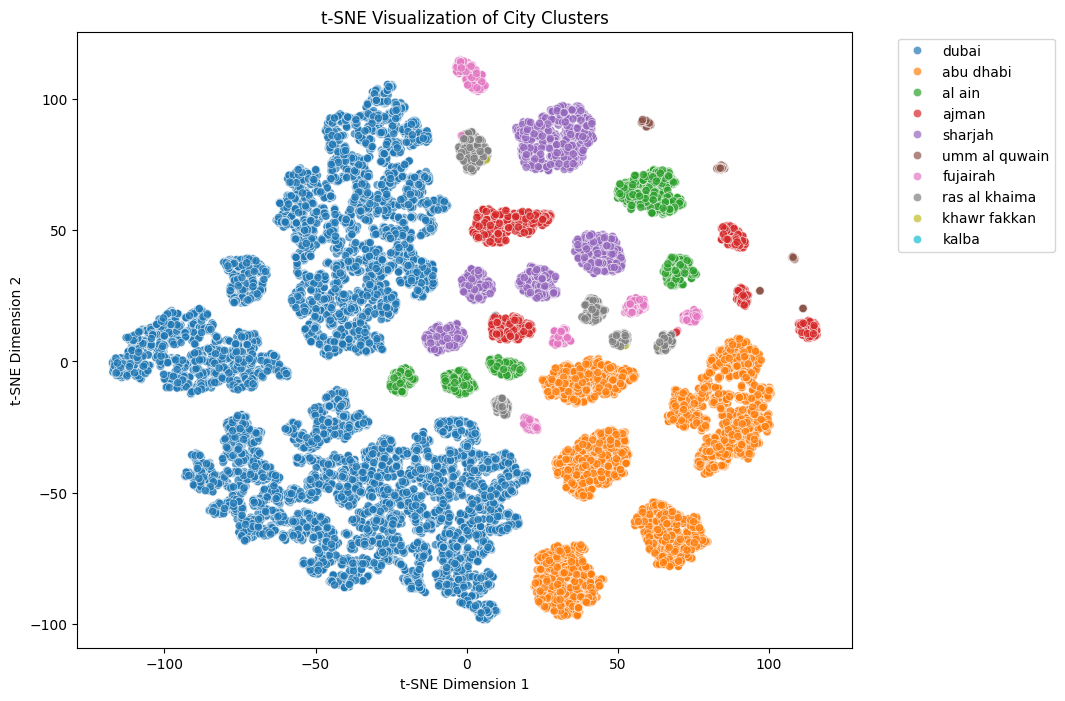

In [142]:
# t-SNE Visualization
visualize_tsne(all_embeddings, all_city_names, "t-SNE Visualization of City Clusters")


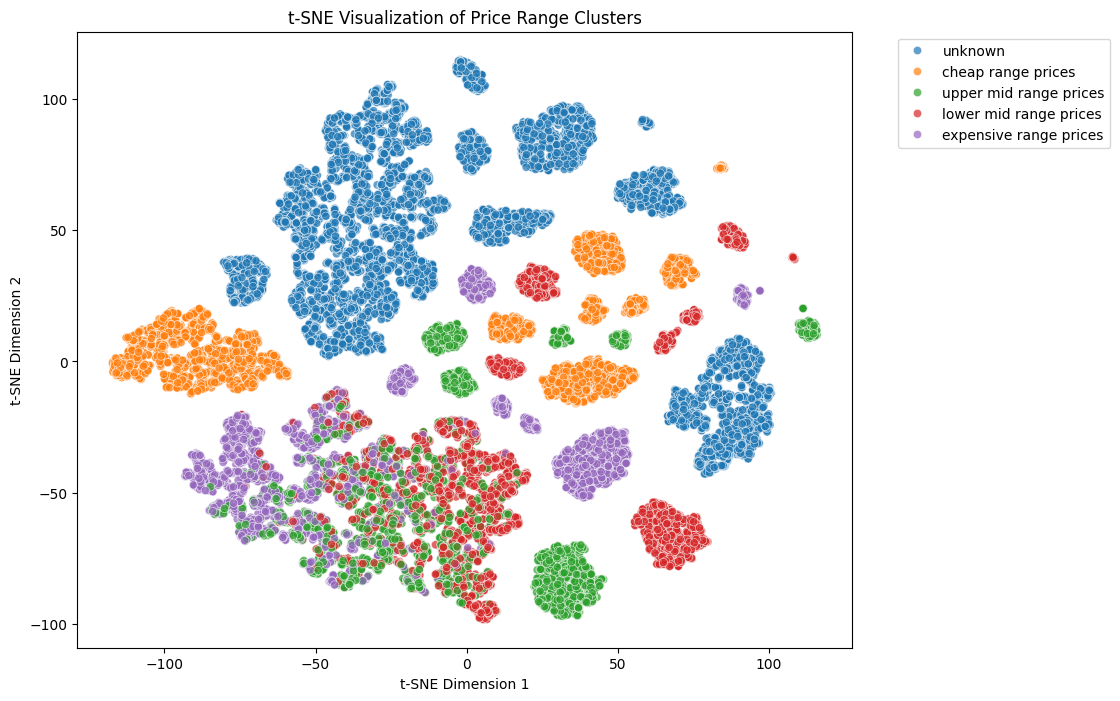

In [143]:
visualize_tsne(all_embeddings, all_price_names, "t-SNE Visualization of Price Range Clusters")


In [144]:
from scipy.spatial.distance import cdist

# Function to compute distance distribution statistics
def compute_distance_statistics(embeddings, labels, label_names):
    """
    Compute distance statistics for each unique label.
    Args:
        embeddings: The embedding matrix (numpy array).
        labels: The corresponding labels for each embedding.
        label_names: The human-readable names of the labels.
    Returns:
        DataFrame: A DataFrame containing distance statistics for each label.
    """
    unique_labels = np.unique(labels)
    stats = []

    for label in unique_labels:
        # Mask for current label
        mask = labels == label
        current_embeddings = embeddings[mask]

        if len(current_embeddings) < 2:
            stats.append([label_names[label], None, None, None, None, None])
            continue

        # Compute pairwise distances
        pairwise_distances = cdist(current_embeddings, current_embeddings, metric="cosine")
        np.fill_diagonal(pairwise_distances, np.nan)  # Exclude self-distances

        closest_distance = np.nanmin(pairwise_distances)
        avg_distance = np.nanmean(pairwise_distances)
        percentile_25 = np.nanpercentile(pairwise_distances, 25)
        percentile_75 = np.nanpercentile(pairwise_distances, 75)
        highest_distance = np.nanmax(pairwise_distances)

        stats.append([label_names[label], closest_distance, avg_distance, percentile_25, percentile_75, highest_distance])

    # Create DataFrame
    stats_df = pd.DataFrame(stats, columns=["label", "closest_distance", "avg_distance", "25th_percentile", "75th_percentile", "highest_distance"])
    return stats_df

# Function to compute statistics for city-price label pairs
def compute_city_price_statistics(embeddings, city_labels, price_labels, city_names, price_names):
    """
    Compute distance statistics for each (city, price label) pair.
    """
    unique_city_labels = np.unique(city_labels)
    unique_price_labels = np.unique(price_labels)
    stats = []

    for city in unique_city_labels:
        for price in unique_price_labels:
            # Mask for the current (city, price) pair
            mask = (city_labels == city) & (price_labels == price)
            current_embeddings = embeddings[mask]

            if len(current_embeddings) < 2:
                stats.append([city_names[city], price_names[price], None, None, None, None, None])
                continue

            # Compute pairwise distances
            pairwise_distances = cdist(current_embeddings, current_embeddings, metric="cosine")
            np.fill_diagonal(pairwise_distances, np.nan)  # Exclude self-distances

            closest_distance = np.nanmin(pairwise_distances)
            avg_distance = np.nanmean(pairwise_distances)
            percentile_25 = np.nanpercentile(pairwise_distances, 25)
            percentile_75 = np.nanpercentile(pairwise_distances, 75)
            highest_distance = np.nanmax(pairwise_distances)

            stats.append([city_names[city], price_names[price], closest_distance, avg_distance, percentile_25, percentile_75, highest_distance])

    # Create DataFrame
    stats_df = pd.DataFrame(stats, columns=["city", "price_label", "closest_distance", "avg_distance", "25th_percentile", "75th_percentile", "highest_distance"])
    return stats_df

# Extract embeddings and labels


In [145]:
all_embeddings, all_city_labels,all_price_labels,city_names , price_names = extract_embeddings_and_labels_full(model, grouped_df)


In [146]:

# Get city and price names from the dataset
city_names = dict(enumerate(grouped_df['city'].unique()))
price_names = dict(enumerate(grouped_df['price_range'].unique()))

# Compute distance distributions for cities
city_stats_df = compute_distance_statistics(all_embeddings, all_city_labels, city_names)
print("City Distance Distribution:\n")
city_stats_df


City Distance Distribution:



label  closest_distance  avg_distance  25th_percentile  \
0          dubai          0.000000      0.002741         0.000002   
1      abu dhabi          0.000000      0.045571         0.000110   
2         al ain          0.000000      0.259505         0.011394   
3          ajman          0.000000      0.330102         0.001807   
4        sharjah          0.000000      0.183055         0.001638   
5  umm al quwain          0.000002      0.400765         0.065770   
6       fujairah          0.000000      0.351242         0.065535   
7  ras al khaima          0.000000      0.369483         0.060754   
8   khawr fakkan          0.001601      0.278675         0.107840   
9          kalba               NaN           NaN              NaN   

   75th_percentile  highest_distance  
0         0.004943          0.008199  
1         0.064347          0.147862  
2         0.396146          0.522701  
3         0.493033          0.739895  
4         0.274805          0.374677  
5         0.582736          0.693710  
6         0.518795          0.731136  
7         0.543746          0.651883  
8         0.483098          0.484680  
9              NaN               NaN

In [147]:

# Compute distance distributions for price labels
price_stats_df = compute_distance_statistics(all_embeddings, all_price_labels, price_names)
print("Price Distance Distribution:\n")
price_stats_df


Price Distance Distribution:



label  closest_distance  avg_distance  25th_percentile  \
0                 unknown      0.000000e+00      0.435479         0.000005   
1      cheap range prices      2.043301e-10      0.502282         0.000394   
2  upper mid range prices      9.537970e-11      0.484155         0.000002   
3  lower mid range prices      4.303734e-10      0.483361         0.000002   
4  expensive range prices      4.601025e-10      0.466080         0.000002   

   75th_percentile  highest_distance  
0         0.788340          0.886387  
1         0.887730          1.009523  
2         0.851237          0.992477  
3         0.850323          0.987957  
4         0.851040          1.007541

In [148]:

# Compute distance distributions for (city, price label) pairs
city_price_stats_df = compute_city_price_statistics(all_embeddings, all_city_labels, all_price_labels, city_names, price_names)
print("City-Price Distance Distribution:\n")
city_price_stats_df



City-Price Distance Distribution:



city             price_label  closest_distance  avg_distance  \
0           dubai                 unknown      0.000000e+00      0.000003   
1           dubai      cheap range prices      2.043301e-10      0.000012   
2           dubai  upper mid range prices      9.537970e-11      0.000001   
3           dubai  lower mid range prices      4.303734e-10      0.000001   
4           dubai  expensive range prices      4.601025e-10      0.000001   
5       abu dhabi                 unknown      0.000000e+00      0.000012   
6       abu dhabi      cheap range prices      2.441821e-07      0.000156   
7       abu dhabi  upper mid range prices      1.011799e-07      0.000026   
8       abu dhabi  lower mid range prices      2.138635e-07      0.000029   
9       abu dhabi  expensive range prices      9.668753e-08      0.000028   
10         al ain                 unknown      0.000000e+00      0.000310   
11         al ain      cheap range prices      1.028637e-05      0.000863   
12         al ain  upper mid range prices      2.597320e-05      0.001762   
13         al ain  lower mid range prices      2.775285e-05      0.001229   
14         al ain  expensive range prices      3.893587e-05      0.001745   
15          ajman                 unknown      0.000000e+00      0.000535   
16          ajman      cheap range prices      1.744626e-05      0.000818   
17          ajman  upper mid range prices      4.735193e-05      0.003642   
18          ajman  lower mid range prices      5.022163e-05      0.002719   
19          ajman  expensive range prices      4.418933e-05      0.002597   
20        sharjah                 unknown      0.000000e+00      0.000145   
21        sharjah      cheap range prices      4.131422e-06      0.000433   
22        sharjah  upper mid range prices      1.014156e-05      0.000616   
23        sharjah  lower mid range prices      1.594086e-05      0.000590   
24        sharjah  expensive range prices      1.466440e-05      0.000734   
25  umm al quwain                 unknown      2.319204e-06      0.000801   
26  umm al quwain      cheap range prices      4.119653e-05      0.001107   
27  umm al quwain  upper mid range prices      1.232140e-04      0.002682   
28  umm al quwain  lower mid range prices      3.946026e-04      0.003529   
29  umm al quwain  expensive range prices      2.324252e-04      0.003794   
30       fujairah                 unknown      0.000000e+00      0.000763   
31       fujairah      cheap range prices      3.294987e-05      0.001056   
32       fujairah  upper mid range prices      3.790876e-05      0.003833   
33       fujairah  lower mid range prices      2.297953e-05      0.003119   
34       fujairah  expensive range prices      6.169438e-05      0.002452   
35  ras al khaima                 unknown      0.000000e+00      0.000518   
36  ras al khaima      cheap range prices      2.168356e-05      0.000932   
37  ras al khaima  upper mid range prices      8.696847e-05      0.002745   
38  ras al khaima  lower mid range prices      1.429395e-04      0.003605   
39  ras al khaima  expensive range prices      7.497702e-05      0.002794   
40   khawr fakkan                 unknown               NaN           NaN   
41   khawr fakkan      cheap range prices               NaN           NaN   
42   khawr fakkan  upper mid range prices      1.601479e-03      0.001601   
43   khawr fakkan  lower mid range prices               NaN           NaN   
44   khawr fakkan  expensive range prices               NaN           NaN   
45          kalba                 unknown               NaN           NaN   
46          kalba      cheap range prices               NaN           NaN   
47          kalba  upper mid range prices               NaN           NaN   
48          kalba  lower mid range prices               NaN           NaN   
49          kalba  expensive range prices               NaN           NaN   

    25th_percentile  75th_percentile  highest_distance  
0      5.748829e-07         

In [149]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

def combine_labels(city_labels, price_labels):
    combined = [f"{city}-{price}" for city, price in zip(city_labels, price_labels)]
    encoder = LabelEncoder()
    combined_encoded = encoder.fit_transform(combined)
    return combined_encoded, encoder.classes_

# Compute metrics for city-price range pairs
def evaluate_city_price_clustering(embeddings, city_labels, price_labels):
    # Combine city and price range labels
    combined_labels, combined_classes = combine_labels(city_labels, price_labels)

    # Perform clustering with KMeans
    num_clusters = len(np.unique(combined_labels))
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # Compute metrics
    ari = adjusted_rand_score(combined_labels, cluster_labels)
    nmi = normalized_mutual_info_score(combined_labels, cluster_labels)
    silhouette_avg = silhouette_score(embeddings, cluster_labels)

    # Print results
    print(f"ARI (City-Price Pairs): {ari:.4f}")
    print(f"NMI (City-Price Pairs): {nmi:.4f}")
    print(f"Silhouette Score for City-Price Pair Clustering: {silhouette_avg:.4f}")

    return ari, nmi, silhouette_avg

# Example Usage
all_embeddings, _,_, all_city_labels, all_price_labels = extract_embeddings_and_labels_full(model, grouped_df)

# Evaluate clustering for city-price range pairs
ari, nmi, silhouette_avg = evaluate_city_price_clustering(
    all_embeddings, all_city_labels, all_price_labels
)

/opt/anaconda3/envs/DHEnv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI (City-Price Pairs): 0.7427
NMI (City-Price Pairs): 0.9326
Silhouette Score for City-Price Pair Clustering: 0.8582


In [150]:
all_embeddings, all_city_labels,all_price_labels, _,_  = extract_embeddings_and_labels_full(model, grouped_df)


In [151]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_combined_tsne(embeddings, city_labels, price_labels, city_names, price_names):
    """
    Visualize t-SNE with combined city and price range clusters.
    Args:
        embeddings: The embedding matrix (numpy array).
        city_labels: City labels as integers.
        price_labels: Price range labels as integers.
        city_names: A dictionary mapping city labels to names.
        price_names: A dictionary mapping price labels to names.
    """
    # Compute t-SNE embeddings
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(embeddings)

    # Plot City Clusters
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    sns.scatterplot(
        x=tsne_embeddings[:, 0],
        y=tsne_embeddings[:, 1],
        hue=[city_names[label] for label in city_labels],
        palette="tab20",
        legend="full",
        alpha=0.8
    )
    plt.title("t-SNE: City Clusters")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # Plot Price Range Clusters
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        x=tsne_embeddings[:, 0],
        y=tsne_embeddings[:, 1],
        hue=[price_names[label] for label in price_labels],
        palette="Set1",
        legend="full",
        alpha=0.8
    )
    plt.title("t-SNE: Price Range Clusters")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


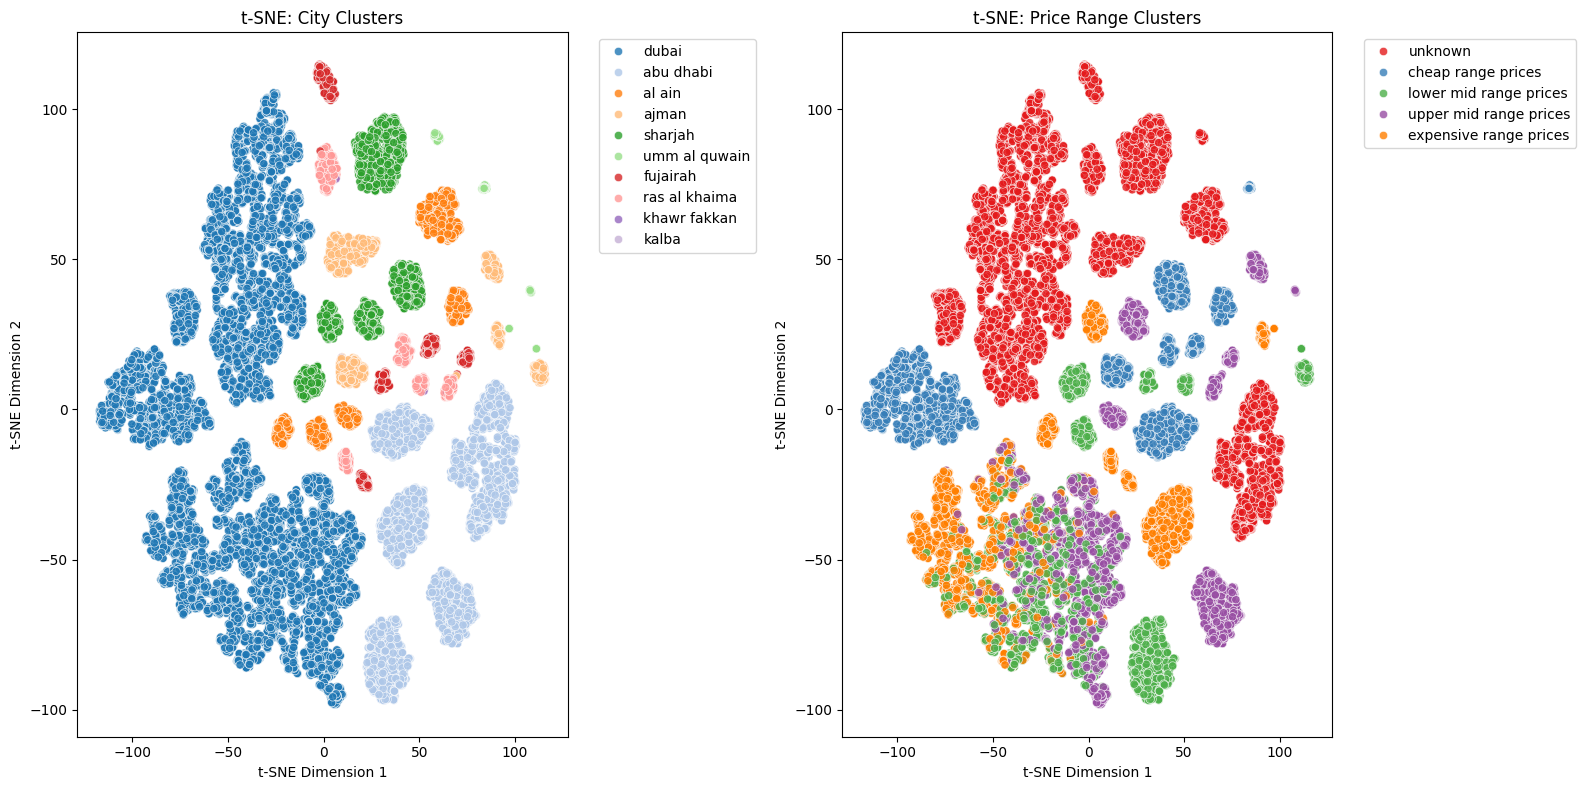

In [152]:
city_names = dict(enumerate(grouped_df['city'].unique()))
price_names = dict(enumerate(grouped_df['price_range'].unique()))

visualize_combined_tsne(all_embeddings, all_city_labels, all_price_labels, city_names, price_names)

In [156]:
grouped_df['lower_embeddings'] = all_embeddings.tolist()

In [210]:
matches = pd.read_gbq(query = '''select sf_match.global_entity_id, sf_match.sf_grid_id, vc.sf_vendor_id as vendor_id, vc.restaurant_city as city, sf_match.lead_source,sf_match.rating,sf_match.n_ratings from dh-global-sales-data-dev.cl_grade_salesforce_odysseus.grading_sf_match as sf_match 
left join dh-global-sales-data-dev.leadgen_cl.vendor_complete as vc 
on vc.global_entity_id = sf_match.global_entity_id 
and vc.grid_id = sf_match.sf_grid_id
 where sf_match.global_entity_id = "TB_AE" and vc.restaurant_city is not null''')

In [211]:
matches['city'].value_counts()

Dubai                  66740
Abu Dhabi              17882
Sharjah                 9838
Ajman                   3903
Al Ain                  3743
Ras Al Khaima           2174
Fujairah                1453
دبي                      481
Umm Al-Quwain            458
Abu dhabi                122
Al ain                   118
Al Sharjah                94
أبو ظبي                   94
الشارقة                   71
Ras al khaima             64
عجمان                     22
الفجيرة                   12
Khawr Fakkan               8
Floor                      4
Al Rahba                   4
Al Warqa                   4
Al Hamriya                 4
Ras Al-Khaimah             3
Al Batayih                 3
Al Samha                   3
Al Bahyah                  2
Mirbah                     2
Ras Al Khaimah             2
Kalba                      2
Al Jasr                    2
International City         2
Ra's as Sammaliyah         2
الرفاعة                    2
New Al Falah               1
Umm Al Quwain 

In [212]:
def fix_city(x):
    if x =='رأس الخيمة':
        return "Ras Al Khaima"
    if x == 'دبي':
        return "Dubai"
    if x == 'أبو ظبي':
        return 'Abu Dhabi'
    if x =='الشارقة':
        return 'Sharjah'
    if x == 'عجمان':
        return 'Ajman'
    if x == 'الفجيرة':
        return 'Fujairah'
    if x =='الرفاعة':
        return 'Rafaa'
    if x =='البدع':
        return "Badaa"
    if x == 'السلمة':
        return 'Salma'
    return x
def preprocess_cities(x):
    if x =='ras al khaimah':
        return 'ras al khaima'
    if x =='al sharjah':
        return 'sharjah'
    return x
matches['city'] = matches['city'].apply(lambda x:preprocess_cities(fix_city(x).lower().replace('-',' ')))


In [213]:
matches['city'].value_counts()

dubai                  67221
abu dhabi              18098
sharjah                10003
ajman                   3925
al ain                  3861
ras al khaima           2244
fujairah                1465
umm al quwain            459
khawr fakkan               8
floor                      4
al hamriya                 4
al rahba                   4
al warqa                   4
al batayih                 3
al samha                   3
al bahyah                  2
rafaa                      2
al jasr                    2
mirbah                     2
international city         2
kalba                      2
ra's as sammaliyah         2
badaa                      1
dibba al fujairah          1
new al falah               1
al jazirah al hamra        1
al dana   abu dhabi        1
al dhaid                   1
khor fakkan                1
salma                      1
Name: city, dtype: int64

In [214]:
city_stats = matches.groupby(['city','lead_source'])['n_ratings'].agg(['mean', 'std','max','min']).reset_index()
city_stats = city_stats.rename(columns={'mean': 'city_source_mean', 'std': 'city_source_std',
                                       'min': 'city_source_min', 'max': 'city_source_max'})


In [215]:
city_stats.head()

city lead_source  city_source_mean  city_source_std  city_source_max  \
0  abu dhabi   careemnow        289.308176      1203.403433          19670.0   
1  abu dhabi        cari               NaN              NaN              NaN   
2  abu dhabi     cw_noon        246.000000       373.789602            801.0   
3  abu dhabi   deliveroo        183.626186       182.962683            500.0   
4  abu dhabi     eateasy          7.500000         7.778175             13.0   

   city_source_min  
0              1.0  
1              NaN  
2             13.0  
3              1.0  
4              2.0

In [216]:
city_stats['city_source_std'] = city_stats['city_source_std'].fillna(1)
city_stats['city_source_mean'] = city_stats['city_source_mean'].fillna(0)


In [217]:
city_stats = city_stats[city_stats['city']!='']
city_stats[city_stats['city']=='dubai']

city  lead_source  city_source_mean  city_source_std  city_source_max  \
57  dubai    careemnow        468.861194      1330.278794          21738.0   
58  dubai         cari          0.000000         1.000000              NaN   
59  dubai      cw_noon        217.111111       287.498454            882.0   
60  dubai    deliveroo        244.095558       199.489289            500.0   
61  dubai      eateasy         15.750000        18.828170             48.0   
62  dubai     facebook         28.653846        49.941082            467.0   
63  dubai       google        510.080820      1119.583788          20129.0   
64  dubai    instashop        483.904459      1447.082914          12286.0   
65  dubai         noon        305.836838      1056.614791          54161.0   
66  dubai    opentable          1.000000         0.000000              1.0   
67  dubai  tripadvisor         51.976722       192.520654           4153.0   
68  dubai   visitdubai        284.727273       415.762214           1386.0   

    city_source_min  
57              1.0  
58              NaN  
59             16.0  
60              1.0  
61              1.0  
62              1.0  
63              1.0  
64              1.0  
65             10.0  
66              1.0  
67              1.0  
68             43.0

In [218]:
matches.head()

global_entity_id sf_grid_id vendor_id      city lead_source  rating  \
0            TB_AE     4CAR46    703621     ajman        noon     2.9   
1            TB_AE     4C1HX8    743320     dubai        noon     3.1   
2            TB_AE     4C2JK1    735474     dubai        noon     3.1   
3            TB_AE     4CR4GP    704152     dubai        noon     3.1   
4            TB_AE     4C4A8A    682167  fujairah        noon     3.1   

   n_ratings  
0       54.0  
1       12.0  
2      101.0  
3      101.0  
4       29.0

In [219]:
print(matches.shape)
matches = matches.merge(city_stats,on=['city','lead_source'],how='left')
print(matches.shape)

(107328, 7)
(107328, 11)


In [220]:
matches['n_ratings_standardised'] = ((matches['n_ratings'] - matches['city_source_mean']) /(matches['city_source_mean'] + 1e-8))
matches['n_ratings_standardised_clipped'] = matches['n_ratings_standardised'].clip(lower=-1, upper=3)

matches['n_ratings_clean'] = (
    matches['n_ratings_standardised_clipped'] - matches['n_ratings_standardised_clipped'].min()
) + 1e-8

In [221]:
matches['n_ratings_clean'].describe()

count    8.283500e+04
mean     7.672227e-01
std      1.051954e+00
min      1.000000e-08
25%      7.535331e-02
50%      2.660149e-01
75%      1.023481e+00
max      3.999291e+00
Name: n_ratings_clean, dtype: float64

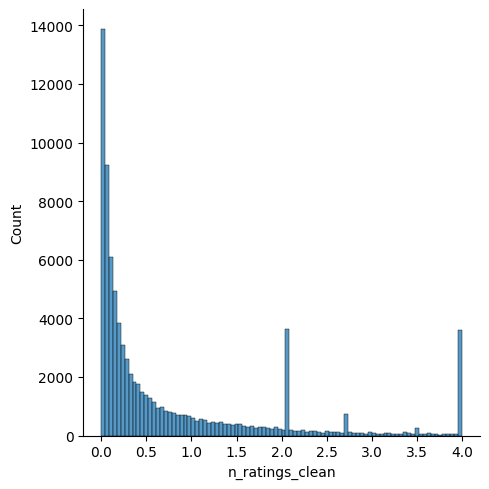

In [222]:
sns.displot(matches['n_ratings_clean'])

In [223]:
matches.isna().sum()/matches.shape[0]

global_entity_id                  0.000000
sf_grid_id                        0.000000
vendor_id                         0.000354
city                              0.000000
lead_source                       0.000000
rating                            0.232605
n_ratings                         0.228207
city_source_mean                  0.000000
city_source_std                   0.000000
city_source_max                   0.002600
city_source_min                   0.002600
n_ratings_standardised            0.228207
n_ratings_standardised_clipped    0.228207
n_ratings_clean                   0.228207
dtype: float64

In [277]:
def pivot_tble(df):
    df_pivoted = df.pivot(values=['rating', 'n_ratings','n_ratings_clean'], index=['global_entity_id', 'sf_grid_id','vendor_id','city'],
                          columns='lead_source')
    df_pivoted = df_pivoted.reset_index()
    df_pivoted.columns = df_pivoted.columns.map('_'.join).str.strip('_')
    return df_pivoted

for source in sources:
    matches_piv[f'n_ratings_{source}'] = matches_piv[f'n_ratings_{source}'].clip(lower=-1, upper=3)


In [392]:
matches_piv = pivot_tble(matches)
matches_piv=matches_piv[matches_piv['vendor_id'].notna()]
matches_piv['vendor_id'] = matches_piv['vendor_id'].astype('int64')

In [393]:
matches_piv.head()

global_entity_id sf_grid_id  vendor_id       city  rating_careemnow  \
0            TB_AE     450031     603270      dubai               NaN   
1            TB_AE     4500DC     603070  abu dhabi               NaN   
2            TB_AE     4500DH     603939      dubai               NaN   
3            TB_AE     4500DM     604591      dubai               NaN   
4            TB_AE     4500E3     603112      dubai               4.1   

   rating_cari  rating_cw_noon  rating_deliveroo  rating_eateasy  \
0          NaN             NaN               NaN             NaN   
1          NaN             NaN               NaN             NaN   
2          NaN             NaN               NaN             NaN   
3          NaN             NaN               NaN             NaN   
4          NaN             NaN               NaN             NaN   

   rating_facebook  ...  n_ratings_clean_cw_noon  n_ratings_clean_deliveroo  \
0              NaN  ...                      NaN                        NaN   
1              NaN  ...                      NaN                        NaN   
2              NaN  ...                      NaN                        NaN   
3              NaN  ...                      NaN                        NaN   
4              NaN  ...                      NaN                        NaN   

   n_ratings_clean_eateasy  n_ratings_clean_facebook  n_ratings_clean_google  \
0                      NaN                       NaN                 0.03262   
1                      NaN                       NaN                     NaN   
2                      NaN                       NaN                     NaN   
3                      NaN                       NaN                     NaN   
4                      NaN                       NaN                     NaN   

   n_ratings_clean_instashop  n_ratings_clean_noon  n_ratings_clean_opentable  \
0                        NaN                   NaN                        NaN   
1                        NaN                   NaN                        NaN   
2                        NaN                   NaN                        NaN   
3                        NaN                   NaN                        NaN   
4                        NaN              3.164378                        NaN   

   n_ratings_clean_tripadvisor  n_ratings_clean_visitdubai  
0                          NaN                         NaN  
1                     0.081026                         NaN  
2                          NaN                         NaN  
3                     0.057010                         NaN  
4                          NaN                         NaN  

[5 rows x 40 columns]

In [394]:
matches_piv.isna().sum()/matches_piv.shape[0]

global_entity_id               0.000000
sf_grid_id                     0.000000
vendor_id                      0.000000
city                           0.000000
rating_careemnow               0.707747
rating_cari                    0.995580
rating_cw_noon                 0.999602
rating_deliveroo               0.675162
rating_eateasy                 0.999638
rating_facebook                0.997102
rating_google                  0.631636
rating_instashop               0.995671
rating_noon                    0.753102
rating_opentable               0.999837
rating_tripadvisor             0.753971
rating_visitdubai              0.999692
n_ratings_careemnow            0.697169
n_ratings_cari                 1.000000
n_ratings_cw_noon              0.999602
n_ratings_deliveroo            0.675162
n_ratings_eateasy              0.999638
n_ratings_facebook             0.994693
n_ratings_google               0.631636
n_ratings_instashop            0.995707
n_ratings_noon                 0.753102


In [395]:
for col in matches_piv.columns:
    if matches_piv[col].isna().sum()/matches_piv.shape[0] > 0.8:
        matches_piv.drop(columns=[col],axis=1,inplace=True)
        
matches_piv.isna().sum()/matches_piv.shape[0]

global_entity_id               0.000000
sf_grid_id                     0.000000
vendor_id                      0.000000
city                           0.000000
rating_careemnow               0.707747
rating_deliveroo               0.675162
rating_google                  0.631636
rating_noon                    0.753102
rating_tripadvisor             0.753971
n_ratings_careemnow            0.697169
n_ratings_deliveroo            0.675162
n_ratings_google               0.631636
n_ratings_noon                 0.753102
n_ratings_tripadvisor          0.753953
n_ratings_clean_careemnow      0.697169
n_ratings_clean_deliveroo      0.675162
n_ratings_clean_google         0.631636
n_ratings_clean_noon           0.753102
n_ratings_clean_tripadvisor    0.753953
dtype: float64

In [396]:
matches_piv.isna().sum()/matches_piv.shape[0]

global_entity_id               0.000000
sf_grid_id                     0.000000
vendor_id                      0.000000
city                           0.000000
rating_careemnow               0.707747
rating_deliveroo               0.675162
rating_google                  0.631636
rating_noon                    0.753102
rating_tripadvisor             0.753971
n_ratings_careemnow            0.697169
n_ratings_deliveroo            0.675162
n_ratings_google               0.631636
n_ratings_noon                 0.753102
n_ratings_tripadvisor          0.753953
n_ratings_clean_careemnow      0.697169
n_ratings_clean_deliveroo      0.675162
n_ratings_clean_google         0.631636
n_ratings_clean_noon           0.753102
n_ratings_clean_tripadvisor    0.753953
dtype: float64

In [397]:
sources = ['careemnow','google','noon','tripadvisor','deliveroo']

In [398]:
rating_cols = [f'rating_{source}' for source in sources]
source_weights = {
    'google':0.25,
    'noon': 0.25,
    'tripadvisor': 0.15,
     'careemnow': 0.25,
    'deliveroo': 0.15
}

def compute_weighted_rating(row, col, source_weights=source_weights):
    """
    Compute weighted average ratings for a row in the DataFrame.

    Args:
        row (pd.Series): A single row of the DataFrame containing ratings for multiple sources.
        source_weights (dict): Dictionary with weights for each source.

    Returns:
        float: Weighted average rating, or NaN if all ratings are invalid.
    """
    ratings = []
    weights = []

    for source, weight in source_weights.items():
        rating = row.get(f'{col}_{source}', np.nan)  
        if not np.isnan(rating):  # Include only valid ratings
            ratings.append(rating)
            weights.append(weight)

    if len(ratings) == 0:  # If no valid ratings, return NaN
        return np.nan

    # Compute weighted average
    ratings = np.array(ratings)
    weights = np.array(weights)
    weighted_avg = np.sum(ratings * weights)
    return weighted_avg



matches_piv["weighted_rating"] = matches_piv.apply(lambda x : compute_weighted_rating(x,col='rating'),axis=1)
matches_piv["weighted_n_ratings"] = matches_piv.apply(lambda x : compute_weighted_rating(x,col='n_ratings'),axis=1)
matches_piv["weighted_n_ratings_clean"] = matches_piv.apply(lambda x : compute_weighted_rating(x,col='n_ratings_clean'),axis=1)



In [399]:
matches_piv[['weighted_rating','weighted_n_ratings','weighted_n_ratings_clean']].describe()

weighted_rating  weighted_n_ratings  weighted_n_ratings_clean
count     44127.000000        44437.000000              4.443700e+04
mean          1.647328          130.607286              2.968877e-01
std           0.995496          356.150050              4.356274e-01
min           0.150000            0.150000              2.500000e-09
25%           0.950000            5.250000              2.348399e-02
50%           1.215000           26.800000              1.046924e-01
75%           2.200000          104.650000              3.884749e-01
max           5.110000        17842.500000              3.896681e+00

In [400]:
matches_piv.isna().sum()/matches_piv.shape[0]

global_entity_id               0.000000
sf_grid_id                     0.000000
vendor_id                      0.000000
city                           0.000000
rating_careemnow               0.707747
rating_deliveroo               0.675162
rating_google                  0.631636
rating_noon                    0.753102
rating_tripadvisor             0.753971
n_ratings_careemnow            0.697169
n_ratings_deliveroo            0.675162
n_ratings_google               0.631636
n_ratings_noon                 0.753102
n_ratings_tripadvisor          0.753953
n_ratings_clean_careemnow      0.697169
n_ratings_clean_deliveroo      0.675162
n_ratings_clean_google         0.631636
n_ratings_clean_noon           0.753102
n_ratings_clean_tripadvisor    0.753953
weighted_rating                0.200728
weighted_n_ratings             0.195113
weighted_n_ratings_clean       0.195113
dtype: float64

In [401]:
# Group by city and compute statistics
city_stats = matches_piv.groupby('city')['weighted_n_ratings_clean'].agg(
    count='count',
    mean='mean',
    std='std',
    min='min',
    q25=lambda x: x.quantile(0.25),
    median='median',
    q75=lambda x: x.quantile(0.75),
    max='max'
).reset_index()

# Rename columns for clarity (optional)
city_stats = city_stats.rename(columns={
    'count': 'vendor_count',
    'mean': 'mean_rating',
    'std': 'std_rating',
    'min': 'min_rating',
    'q25': 'q25_rating',
    'median': 'median_rating',
    'q75': 'q75_rating',
    'max': 'max_rating'
})

# Display the city statistics
city_stats


city  vendor_count  mean_rating  std_rating    min_rating  \
0             abu dhabi          8757     0.237164    0.334284  6.869978e-04   
1                 ajman          1778     0.217584    0.334980  5.787189e-04   
2                al ain          2066     0.221531    0.336096  8.807796e-04   
3             al bahyah             1     0.149894         NaN  1.498937e-01   
4            al batayih             1     0.249823         NaN  2.498229e-01   
5   al dana   abu dhabi             0          NaN         NaN           NaN   
6              al dhaid             0          NaN         NaN           NaN   
7            al hamriya             1     0.799433         NaN  7.994332e-01   
8               al jasr             1     0.399717         NaN  3.997166e-01   
9   al jazirah al hamra             0          NaN         NaN           NaN   
10             al rahba             1     0.299787         NaN  2.997874e-01   
11             al samha             2     0.199858    0.070661  1.498937e-01   
12             al warqa             1     0.899362         NaN  8.993623e-01   
13                badaa             0          NaN         NaN           NaN   
14    dibba al fujairah             1     0.249823         NaN  2.498229e-01   
15                dubai         25152     0.341348    0.477319  3.129858e-04   
16                floor             1     0.799433         NaN  7.994332e-01   
17             fujairah           908     0.207437    0.326575  1.162506e-03   
18   international city             1     0.399717         NaN  3.997166e-01   
19                kalba             1     0.249823         NaN  2.498229e-01   
20         khawr fakkan             3     0.549610    0.450717  5.339430e-02   
21          khor fakkan             0          NaN         NaN           NaN   
22               mirbah             1     0.249823         NaN  2.498229e-01   
23         new al falah             1     0.149894         NaN  1.498937e-01   
24   ra's as sammaliyah             1     0.399717         NaN  3.997166e-01   
25                rafaa             1     0.249823         NaN  2.498229e-01   
26        ras al khaima          1274     0.218541    0.325686  9.851240e-04   
27                salma             1     0.249823         NaN  2.498229e-01   
28              sharjah          4216     0.272060    0.463219  2.500000e-09   
29        umm al quwain           266     0.241323    0.343063  8.342625e-04   

    q25_rating  median_rating  q75_rating  max_rating  
0     0.022600       0.087874    0.334002    3.007872  
1     0.021164       0.074009    0.268906    2.778719  
2     0.023985       0.078397    0.248640    3.285439  
3     0.149894       0.149894    0.149894    0.149894  
4     0.249823       0.249823    0.249823    0.249823  
5          NaN            NaN         NaN         NaN  
6          NaN            NaN         NaN         NaN  
7     0.799433       0.799433    0.799433    0.799433  
8     0.399717       0.399717    0.399717    0.399717  
9          NaN            NaN         NaN         NaN  
10    0.299787       0.299787    0.299787    0.299787  
11    0.174876       0.199858    0.224841    0.249823  
12    0.899362       0.899362    0.899362    0.899362  
13         NaN            NaN         NaN         NaN  
14    0.249823       0.249823    0.249823    0.249823  
15    0.024474       0.129918    0.450843    3.896681  
16    0.799433       0.799433    0.799433    0.799433  
17    0.018578       0.068883    0.233270    2.599539  
18    0.399717       0.399717    0.399717    0.399717  
19    0.249823       0.249823    0.249823    0.249823  
20    0.357599       0.661803    0.797718    0.933633  
21         NaN            NaN         NaN         NaN  
22    0.249823       0.249823    0.249823    0.249823  
23    0.149894       0.149894    0.149894    0.149894  
24    0.399717       0.399717    0.399717    0.399717  
25    0.249823       0.249823    0.249823    0.249823  
26    0.021547       0.073

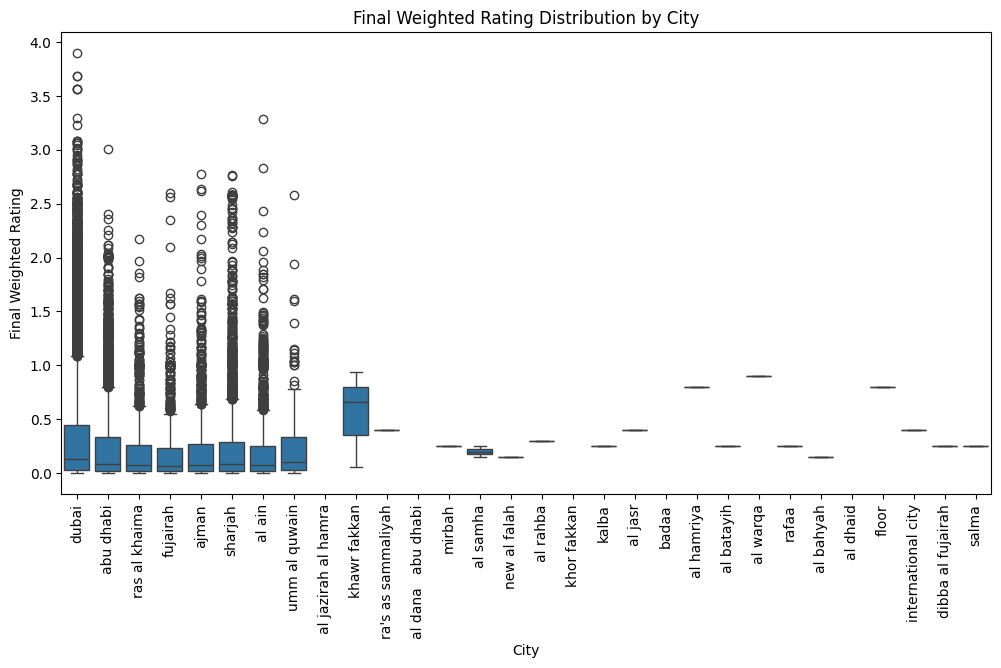

In [402]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='weighted_n_ratings_clean', data=matches_piv)
plt.xticks(rotation=90)
plt.title('Final Weighted Rating Distribution by City')
plt.xlabel('City')
plt.ylabel('Final Weighted Rating')
plt.show()


/var/folders/vf/db_cywxx4hdfjknld_mqwsr1dh2vl3/T/ipykernel_38444/3655825484.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='city', y='mean_rating', data=city_stats, palette='viridis')


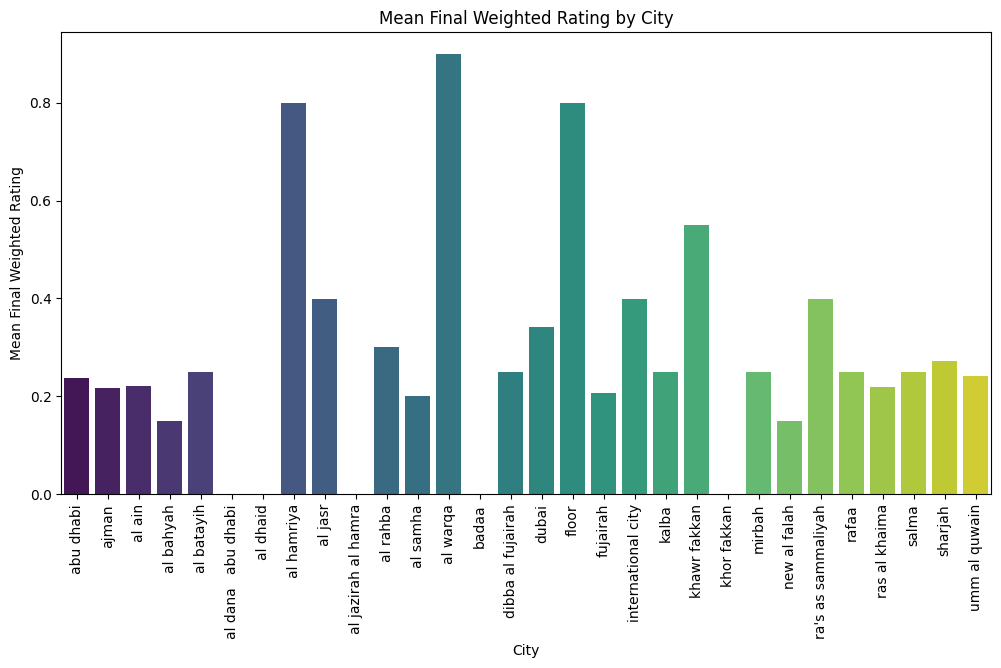

In [403]:
plt.figure(figsize=(12, 6))
sns.barplot(x='city', y='mean_rating', data=city_stats, palette='viridis')
plt.xticks(rotation=90)
plt.title('Mean Final Weighted Rating by City')
plt.xlabel('City')
plt.ylabel('Mean Final Weighted Rating')
plt.show()


In [413]:
curated_df = grouped_df[['vendor_id','restaurant_name','city','avg_item_price','main_cuisine','items_names','lower_embeddings']]
curated_df.head()

vendor_id                                   restaurant_name       city  \
0   665382.0              BRO STATION RESTAURANT, Business Bay      dubai   
1   665497.0  Rainbow Karak Chai - Since 1955, Jumeirah Street      dubai   
2   665509.0                                   New Street Cafe  abu dhabi   
3   665513.0                                         gogo cafe     al ain   
4   665516.0                                          Burger 7      ajman   

   avg_item_price                main_cuisine items_names  \
0             NaN                  [American]          []   
1             NaN             [International]          []   
2             NaN  [Pasta, Pizza, Sandwiches]          []   
3             NaN                    [Arabic]          []   
4             NaN                    [Arabic]          []   

                                    lower_embeddings  
0  [0.002702070400118828, 0.011856542900204659, -...  
1  [0.002709598746150732, 0.011859375983476639, -...  
2  [-0.030378324910998344, -0.002989533357322216,...  
3  [-0.030509663745760918, 0.01497742161154747, 0...  
4  [-0.026231572031974792, -0.006357351318001747,...

In [414]:
curated_df['vendor_id'] = curated_df['vendor_id'].astype('int64')
curated_df.head()

/var/folders/vf/db_cywxx4hdfjknld_mqwsr1dh2vl3/T/ipykernel_38444/194960508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curated_df['vendor_id'] = curated_df['vendor_id'].astype('int64')


vendor_id                                   restaurant_name       city  \
0     665382              BRO STATION RESTAURANT, Business Bay      dubai   
1     665497  Rainbow Karak Chai - Since 1955, Jumeirah Street      dubai   
2     665509                                   New Street Cafe  abu dhabi   
3     665513                                         gogo cafe     al ain   
4     665516                                          Burger 7      ajman   

   avg_item_price                main_cuisine items_names  \
0             NaN                  [American]          []   
1             NaN             [International]          []   
2             NaN  [Pasta, Pizza, Sandwiches]          []   
3             NaN                    [Arabic]          []   
4             NaN                    [Arabic]          []   

                                    lower_embeddings  
0  [0.002702070400118828, 0.011856542900204659, -...  
1  [0.002709598746150732, 0.011859375983476639, -...  
2  [-0.030378324910998344, -0.002989533357322216,...  
3  [-0.030509663745760918, 0.01497742161154747, 0...  
4  [-0.026231572031974792, -0.006357351318001747,...

In [415]:
curated_df = curated_df.merge(data[['vendor_id','sf_grid_id','total_orders','lat','lng']].drop_duplicates(),
                             on=['vendor_id'])
curated_df.isna().sum()/curated_df.shape[0]

vendor_id           0.000000
restaurant_name     0.000000
city                0.000000
avg_item_price      0.371346
main_cuisine        0.000000
items_names         0.000000
lower_embeddings    0.000000
sf_grid_id          0.000000
total_orders        0.099376
lat                 0.000045
lng                 0.000045
dtype: float64

In [416]:
curated_df = curated_df[curated_df['lat'].notna()]

In [417]:
curated_df.dtypes

vendor_id             int64
restaurant_name      object
city                 object
avg_item_price      float64
main_cuisine         object
items_names          object
lower_embeddings     object
sf_grid_id           object
total_orders        float64
lat                 float64
lng                 float64
dtype: object

In [418]:
matches_piv.dtypes

global_entity_id                object
sf_grid_id                      object
vendor_id                        int64
city                            object
rating_careemnow               float64
rating_deliveroo               float64
rating_google                  float64
rating_noon                    float64
rating_tripadvisor             float64
n_ratings_careemnow            float64
n_ratings_deliveroo            float64
n_ratings_google               float64
n_ratings_noon                 float64
n_ratings_tripadvisor          float64
n_ratings_clean_careemnow      float64
n_ratings_clean_deliveroo      float64
n_ratings_clean_google         float64
n_ratings_clean_noon           float64
n_ratings_clean_tripadvisor    float64
weighted_rating                float64
weighted_n_ratings             float64
weighted_n_ratings_clean       float64
dtype: object

In [419]:
curated_df = curated_df.merge(matches_piv[['vendor_id','sf_grid_id','weighted_rating','weighted_n_ratings','weighted_n_ratings_clean']]
                              ,how='left',
                             on=['vendor_id','sf_grid_id'])


In [420]:
curated_df.isna().sum()/curated_df_t.shape[0]

vendor_id                   0.000000
restaurant_name             0.000000
city                        0.000000
avg_item_price              0.371346
main_cuisine                0.000000
items_names                 0.000000
lower_embeddings            0.000000
sf_grid_id                  0.000000
total_orders                0.099332
lat                         0.000000
lng                         0.000000
weighted_rating             0.300579
weighted_n_ratings          0.293583
weighted_n_ratings_clean    0.293583
dtype: float64

In [421]:
curated_df.head()

vendor_id                                   restaurant_name       city  \
0     665382              BRO STATION RESTAURANT, Business Bay      dubai   
1     665497  Rainbow Karak Chai - Since 1955, Jumeirah Street      dubai   
2     665509                                   New Street Cafe  abu dhabi   
3     665513                                         gogo cafe     al ain   
4     665516                                          Burger 7      ajman   

   avg_item_price                main_cuisine items_names  \
0             NaN                  [American]          []   
1             NaN             [International]          []   
2             NaN  [Pasta, Pizza, Sandwiches]          []   
3             NaN                    [Arabic]          []   
4             NaN                    [Arabic]          []   

                                    lower_embeddings sf_grid_id  total_orders  \
0  [0.002702070400118828, 0.011856542900204659, -...     4FM6NK        1532.0   
1  [0.002709598746150732, 0.011859375983476639, -...     4FM62H         218.0   
2  [-0.030378324910998344, -0.002989533357322216,...     HWWS37          58.0   
3  [-0.030509663745760918, 0.01497742161154747, 0...     HWWPQY         627.0   
4  [-0.026231572031974792, -0.006357351318001747,...     HWWWGC         242.0   

         lat        lng  weighted_rating  weighted_n_ratings  \
0  25.186226  55.260962              NaN                 NaN   
1  25.161631  55.209477            2.880              161.75   
2  24.184996  55.636230            0.675                0.30   
3  24.234328  55.722675            1.250                1.75   
4  25.389022  55.506011              NaN                 NaN   

   weighted_n_ratings_clean  
0                       NaN  
1                  0.534452  
2                  0.008067  
3                  0.010008  
4                       NaN

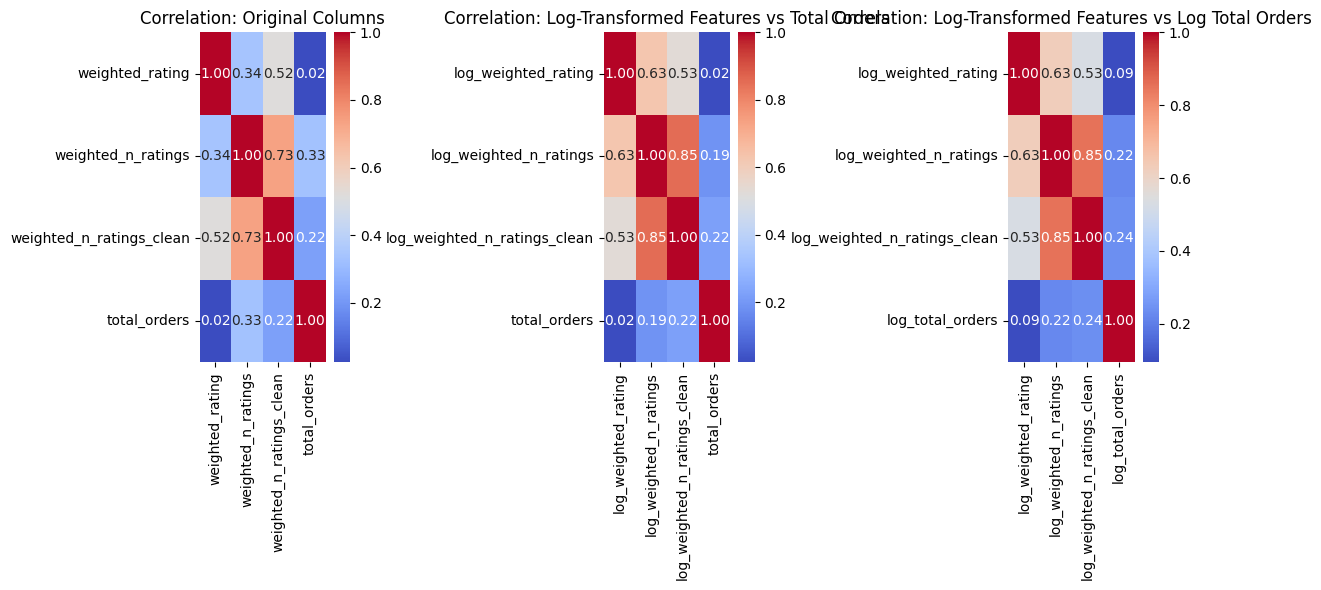

In [422]:
d=curated_df.copy(deep=True)
d['log_weighted_rating'] = np.log1p(d['weighted_rating'])
d['log_weighted_n_ratings'] = np.log1p(d['weighted_n_ratings'])
d['log_weighted_n_ratings_clean'] = np.log1p(d['weighted_n_ratings_clean'])
d['log_total_orders'] = np.log1p(d['total_orders'])

# Define groups of columns for correlation analysis
columns_original = ['weighted_rating', 'weighted_n_ratings', 'weighted_n_ratings_clean', 'total_orders']
columns_log_features = ['log_weighted_rating', 'log_weighted_n_ratings', 'log_weighted_n_ratings_clean']
columns_log_target = ['log_total_orders']

# Correlation analysis for original columns
corr_original = d[columns_original].corr()

# Correlation analysis between log-transformed features and total orders (original scale)
corr_log_features_total_orders = d[columns_log_features + ['total_orders']].corr()

# Correlation analysis between log-transformed features and log-transformed total orders
corr_log_features_log_total_orders = d[columns_log_features + columns_log_target].corr()

# Plot the correlation matrices
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.heatmap(corr_original, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation: Original Columns")

plt.subplot(1, 3, 2)
sns.heatmap(corr_log_features_total_orders, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation: Log-Transformed Features vs Total Orders")

plt.subplot(1, 3, 3)
sns.heatmap(corr_log_features_log_total_orders, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation: Log-Transformed Features vs Log Total Orders")

plt.tight_layout()
plt.show()

In [358]:
data.head()

Unnamed: 0 global_entity_id country_iso           city  vendor_id  \
0           0            TB_AE          AE      Abu Dhabi     695014   
1           1            TB_AE          AE      Abu Dhabi     695014   
2           2            TB_AE          AE  Umm Al-Quwain     677545   
3           3            TB_AE          AE      Abu Dhabi     679240   
4           4            TB_AE          AE      Abu Dhabi     679240   

  sf_grid_id                       restaurant_name  \
0     HWX0MI                               Ventuno   
1     HWX0MI                               Ventuno   
2     HW0QOE  Lahore Palace Restaurant & Cafeteria   
3     4FIXTB             Starbucks, Al Maqtaa Mall   
4     4FIXTB             Starbucks, Al Maqtaa Mall   

                                  restaurant_address main_cuisine        lat  \
0  Al reem Central Park - Al Reem Island - Shams ...      Italian  24.503227   
1  Al reem Central Park - Al Reem Island - Shams ...      Italian  24.503227   
2                                                NaN    Pakistani  25.506539   
3                  Al Maqtaa Mall, Rabdan, Abu Dhabi       Coffee  24.397766   
4                  Al Maqtaa Mall, Rabdan, Abu Dhabi       Coffee  24.397766   

   ...        hex_level  total_orders  activation_date       item_id  \
0  ...  8843a02283fffff         323.0       2022-12-22  5.314064e+08   
1  ...  8843a02283fffff         323.0       2022-12-22  5.314065e+08   
2  ...  8843ac1337fffff         569.0       2022-05-31  5.291280e+08   
3  ...  8843a02e25fffff        2525.0       2022-07-17  1.623081e+09   
4  ...  8843a02e25fffff        2525.0       2022-07-17  1.623081e+09   

                                   item_name_ascii  \
0                                 cheese croissant   
1                                   cold americano   
2                                         alu naan   
3         tum 16oz s/s terrazzo white w21 11116789   
4  tumbler 16 oz united arab emirates you are here   

                              item_description_ascii  item_price currency  \
0  fesh coissant with bie cheese fom inside and c...        21.0      AED   
1  iced ameicano is efeshing, bold and tasty coff...        20.0      AED   
2                                                NaN         3.0      AED   
3                                                NaN       120.0      AED   
4                                                NaN        70.0      AED   

  item_name_translated                                  product_embedding  
0                  NaN  [-0.05314685 -0.01000848 -0.0954266  -0.106075...  
1                  NaN  [-0.10460141 -0.11697953 -0.12478703 -0.147814...  
2                  NaN  [ 0.06602768  0.07784649  0.03239381 -0.059113...  
3                  NaN                                                 []  
4                  NaN                                                 []  

[5 rows x 23 columns]

In [359]:
data.dtypes

Unnamed: 0                  int64
global_entity_id           object
country_iso                object
city                       object
vendor_id                   int64
sf_grid_id                 object
restaurant_name            object
restaurant_address         object
main_cuisine               object
lat                       float64
lng                       float64
city_lat                  float64
city_lng                  float64
hex_level                  object
total_orders              float64
activation_date            object
item_id                   float64
item_name_ascii            object
item_description_ascii     object
item_price                float64
currency                   object
item_name_translated      float64
product_embedding          object
dtype: object

In [509]:
feature_cols = ['vendor_id','city','lower_embeddings','lat','lng','weighted_n_ratings_clean','weighted_rating','weighted_n_ratings','total_orders']
df_data = curated_df[feature_cols]


In [510]:
df_data.head()

lower_embeddings        lat        lng  \
0  [0.002702070400118828, 0.011856542900204659, -...  25.186226  55.260962   
1  [0.002709598746150732, 0.011859375983476639, -...  25.161631  55.209477   
2  [-0.030378324910998344, -0.002989533357322216,...  24.184996  55.636230   
3  [-0.030509663745760918, 0.01497742161154747, 0...  24.234328  55.722675   
4  [-0.026231572031974792, -0.006357351318001747,...  25.389022  55.506011   

   weighted_n_ratings_clean  weighted_rating  weighted_n_ratings  total_orders  
0                       NaN              NaN                 NaN        1532.0  
1                  0.534452            2.880              161.75         218.0  
2                  0.008067            0.675                0.30          58.0  
3                  0.010008            1.250                1.75         627.0  
4                       NaN              NaN                 NaN         242.0

In [511]:
df_data['log'] = np.log(df_data['total_orders']+1)

/var/folders/vf/db_cywxx4hdfjknld_mqwsr1dh2vl3/T/ipykernel_38444/314854600.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['log'] = np.log(df_data['total_orders']+1)


In [512]:
def add_lat_lng_transformations(df, lat_col='lat', lng_col='lng'):
    df['cos_lat'] = np.cos(np.radians(df[lat_col]))
    df['sin_lat'] = np.sin(np.radians(df[lat_col]))
    df['cos_lng'] = np.cos(np.radians(df[lng_col]))
    df['sin_lng'] = np.sin(np.radians(df[lng_col]))
    return df
df_data = add_lat_lng_transformations(df_data)

/var/folders/vf/db_cywxx4hdfjknld_mqwsr1dh2vl3/T/ipykernel_38444/408651439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cos_lat'] = np.cos(np.radians(df[lat_col]))
/var/folders/vf/db_cywxx4hdfjknld_mqwsr1dh2vl3/T/ipykernel_38444/408651439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sin_lat'] = np.sin(np.radians(df[lat_col]))
/var/folders/vf/db_cywxx4hdfjknld_mqwsr1dh2vl3/T/ipykernel_38444/408651439.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [513]:
df_data.isna().sum()/df_data.shape[0]

lower_embeddings            0.000000
lat                         0.000000
lng                         0.000000
weighted_n_ratings_clean    0.293596
weighted_rating             0.300593
weighted_n_ratings          0.293596
total_orders                0.099336
log                         0.099336
cos_lat                     0.000000
sin_lat                     0.000000
cos_lng                     0.000000
sin_lng                     0.000000
dtype: float64

In [514]:
df_data = df_data[df_data['total_orders'].notna()]

In [515]:
df_data.isna().sum()/df_data.shape[0]

lower_embeddings            0.000000
lat                         0.000000
lng                         0.000000
weighted_n_ratings_clean    0.280257
weighted_rating             0.287432
weighted_n_ratings          0.280257
total_orders                0.000000
log                         0.000000
cos_lat                     0.000000
sin_lat                     0.000000
cos_lng                     0.000000
sin_lng                     0.000000
dtype: float64

In [516]:
df_data.fillna(0,inplace=True)
df_data.isna().sum()/df_data.shape[0]

lower_embeddings            0.0
lat                         0.0
lng                         0.0
weighted_n_ratings_clean    0.0
weighted_rating             0.0
weighted_n_ratings          0.0
total_orders                0.0
log                         0.0
cos_lat                     0.0
sin_lat                     0.0
cos_lng                     0.0
sin_lng                     0.0
dtype: float64

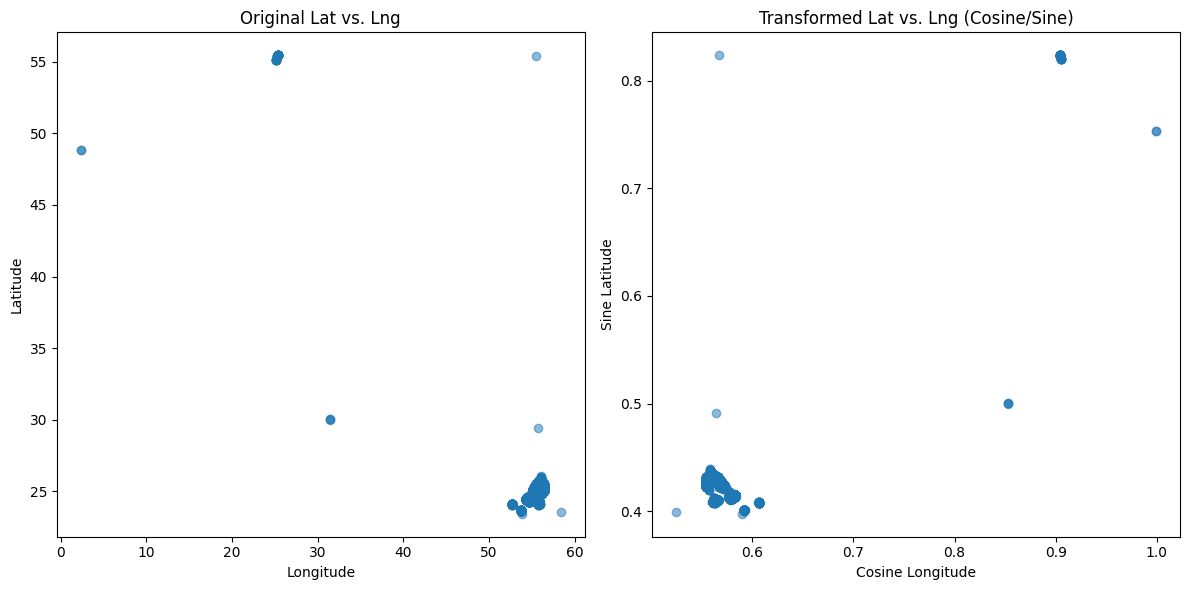

In [517]:
import matplotlib.pyplot as plt

# Plot original lat/lng vs transformed lat/lng
plt.figure(figsize=(12, 6))

# Plot original lat/lng
plt.subplot(1, 2, 1)
plt.scatter(df_data['lng'], df_data['lat'], alpha=0.5)
plt.title('Original Lat vs. Lng')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot transformed lat/lng (cos/sin)
plt.subplot(1, 2, 2)
plt.scatter(df_data['cos_lng'], df_data['sin_lat'], alpha=0.5)
plt.title('Transformed Lat vs. Lng (Cosine/Sine)')
plt.xlabel('Cosine Longitude')
plt.ylabel('Sine Latitude')

plt.tight_layout()
plt.show()


/opt/anaconda3/envs/DHEnv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


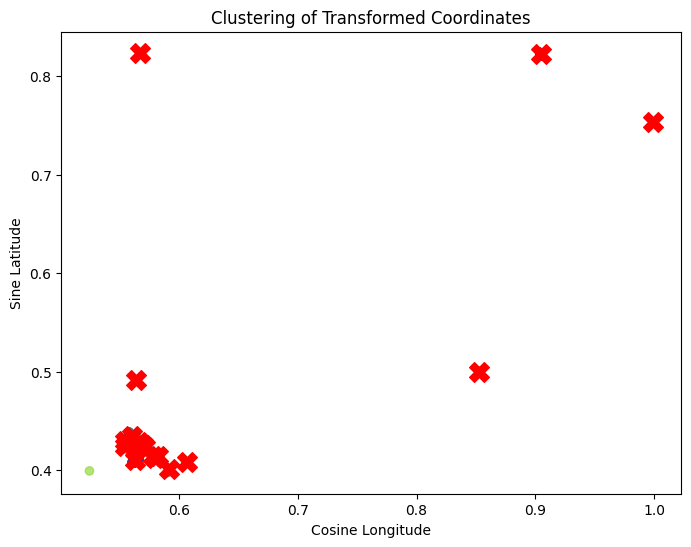

In [518]:
from sklearn.cluster import KMeans
import numpy as np

# Apply KMeans clustering on transformed lat/lng (cos/sin)
coordinates = df_data[['cos_lng', 'sin_lat']].values  # Modify this as needed to include other transformed features

# Apply KMeans clustering
kmeans = KMeans(n_clusters=20, random_state=42)  # Change n_clusters as needed
kmeans.fit(coordinates)

# Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(df_data['cos_lng'], df_data['sin_lat'], c=kmeans.labels_, cmap='viridis', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', s=200, color='red')  # Centroids
plt.title('Clustering of Transformed Coordinates')
plt.xlabel('Cosine Longitude')
plt.ylabel('Sine Latitude')
plt.show()


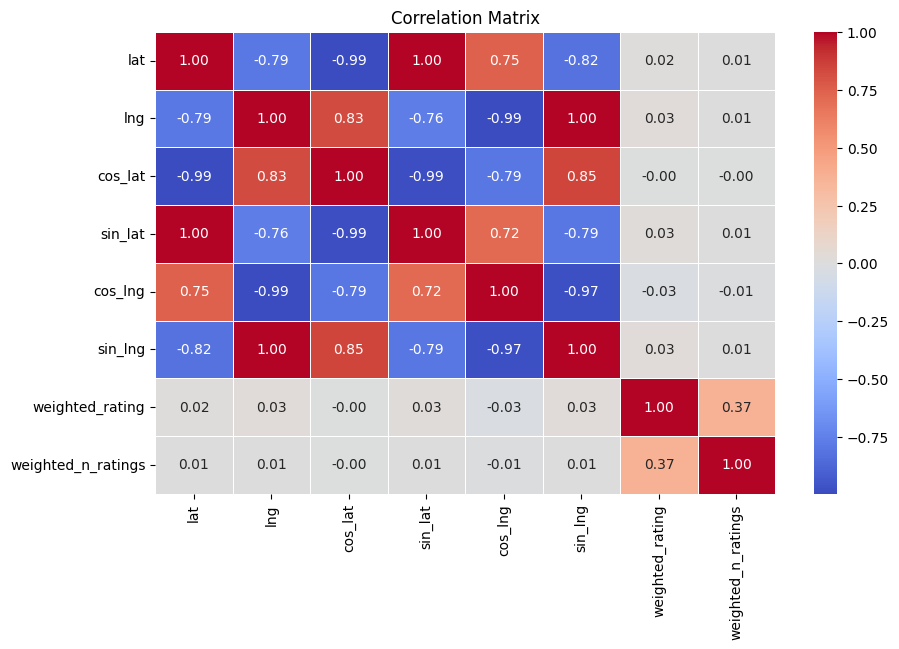

In [519]:
import seaborn as sns

# Calculate correlation matrix for selected columns
corr = df_data[['lat', 'lng', 'cos_lat', 'sin_lat', 'cos_lng', 'sin_lng', 'weighted_rating', 'weighted_n_ratings']].corr()

# Visualize the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


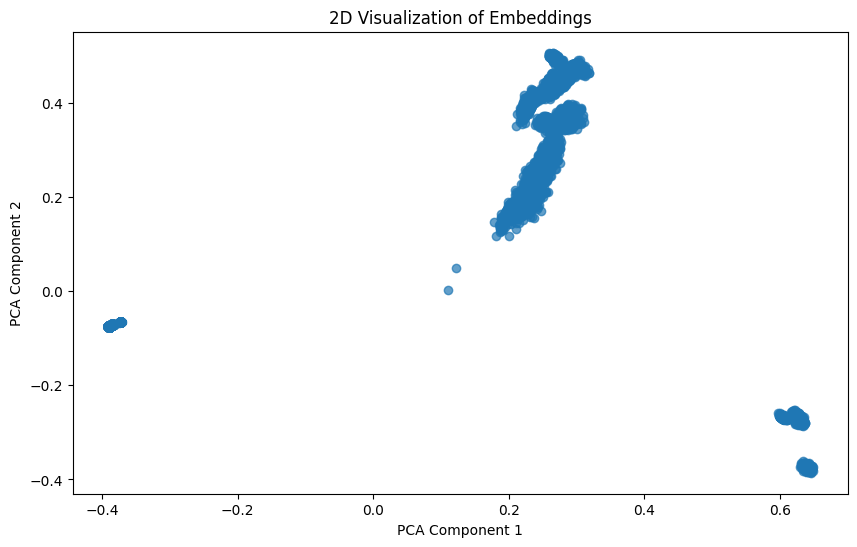

In [520]:
# Assuming 'lower_embeddings' is a column of arrays
from sklearn.decomposition import PCA

# Reduce the dimensionality of embeddings (if needed)
pca = PCA(n_components=2)  # Reduce to 2D for visualization
embeddings_2d = pca.fit_transform(list(df_data['lower_embeddings']))

# Plot the 2D embeddings
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
plt.title('2D Visualization of Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


                         lat       lng   cos_lat   sin_lat   cos_lng  \
lat                 1.000000 -0.787250 -0.994417  0.998240  0.748060   
lng                -0.787250  1.000000  0.827050 -0.761704 -0.990485   
cos_lat            -0.994417  0.827050  1.000000 -0.986415 -0.793686   
sin_lat             0.998240 -0.761704 -0.986415  1.000000  0.719227   
cos_lng             0.748060 -0.990485 -0.793686  0.719227  1.000000   
sin_lng            -0.815555  0.995805  0.850687 -0.792581 -0.974198   
weighted_rating     0.018021  0.026801 -0.004145  0.025608 -0.026213   
weighted_n_ratings  0.005865  0.006647 -0.000325  0.008904 -0.005525   
total_orders       -0.017894  0.016350  0.015941 -0.018887 -0.017455   
log                -0.054518  0.044126  0.048095 -0.057839 -0.044293   

                     sin_lng  weighted_rating  weighted_n_ratings  \
lat                -0.815555         0.018021            0.005865   
lng                 0.995805         0.026801            0.006647   


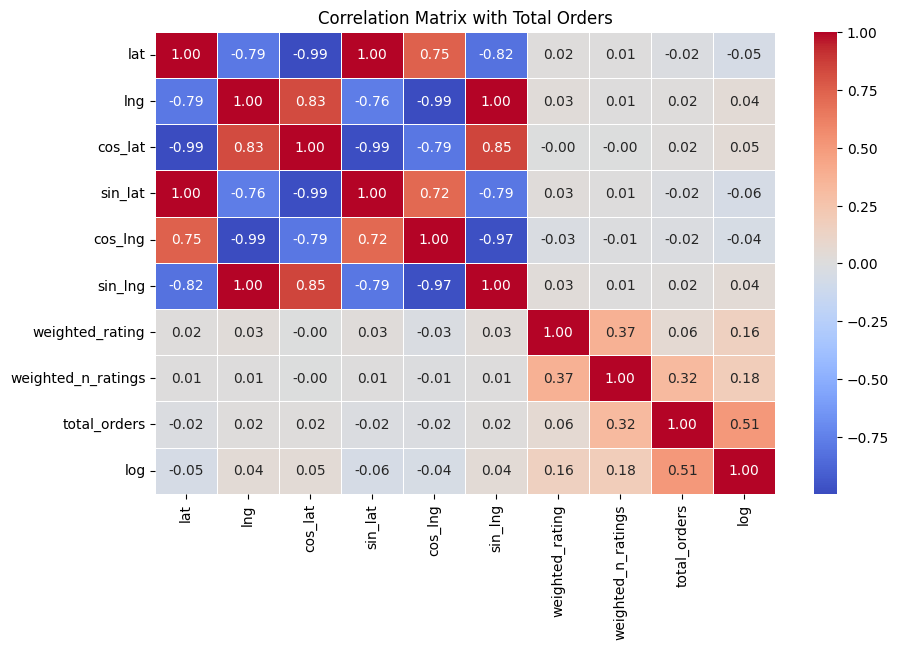

In [521]:
# Compute the correlation matrix for selected columns
corr = df_data[['lat', 'lng', 'cos_lat', 'sin_lat', 'cos_lng', 'sin_lng', 
                'weighted_rating', 'weighted_n_ratings', 'total_orders','log']].corr()

# Display the correlation matrix
print(corr)

# Visualize the correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix with Total Orders')
plt.show()


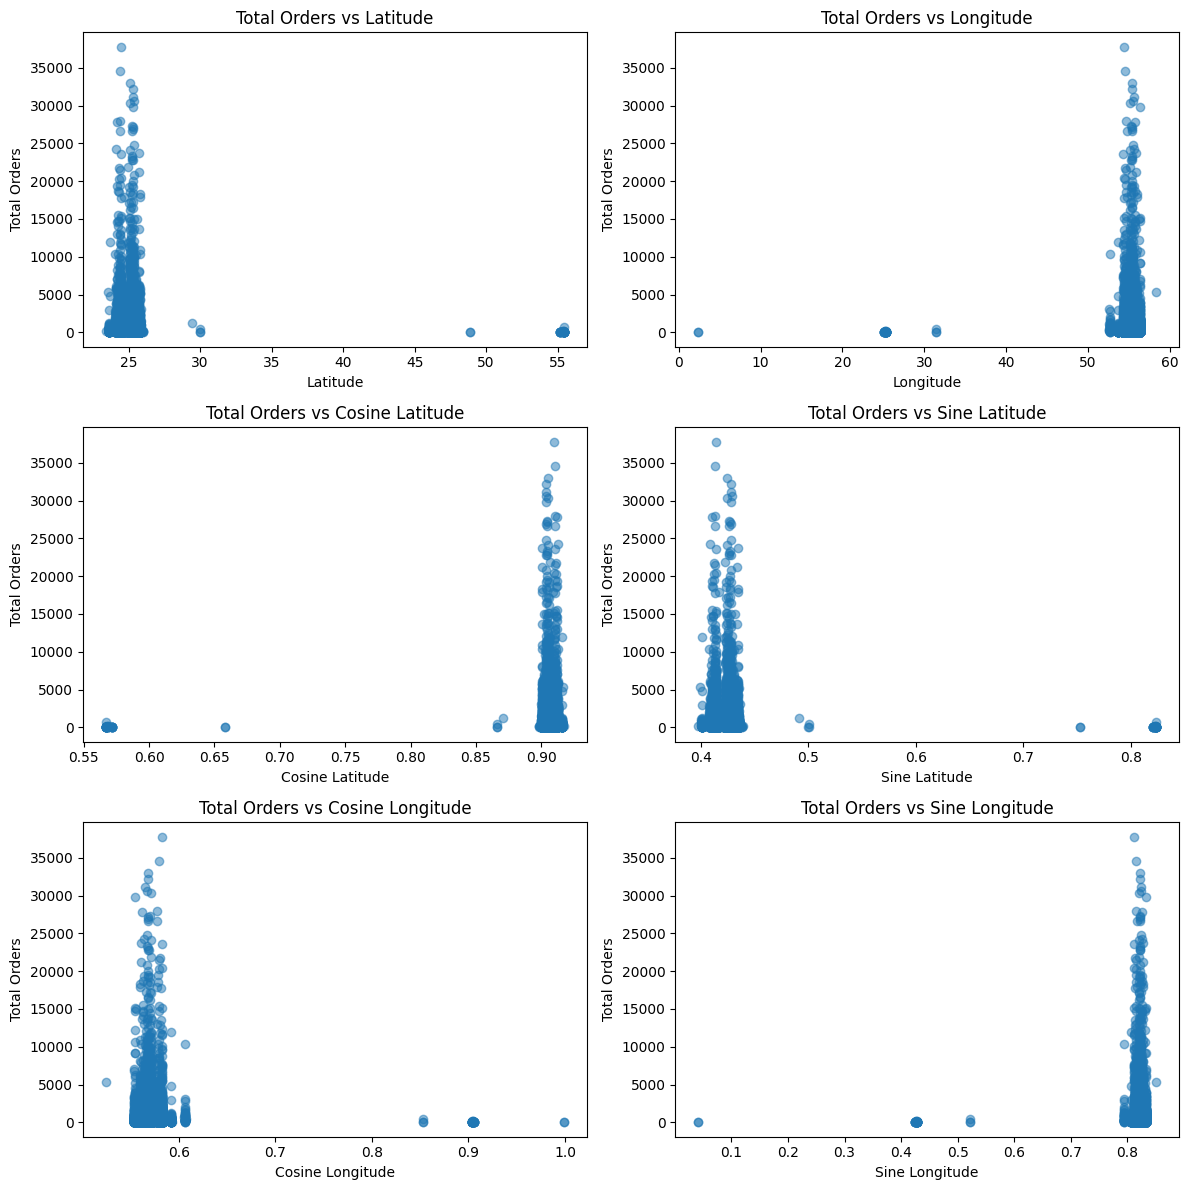

In [522]:
# Scatter plots to visualize the relationships with 'total_orders'
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Scatter plot between 'total_orders' and 'lat'
axes[0, 0].scatter(df_data['lat'], df_data['total_orders'], alpha=0.5)
axes[0, 0].set_title('Total Orders vs Latitude')
axes[0, 0].set_xlabel('Latitude')
axes[0, 0].set_ylabel('Total Orders')

# Scatter plot between 'total_orders' and 'lng'
axes[0, 1].scatter(df_data['lng'], df_data['total_orders'], alpha=0.5)
axes[0, 1].set_title('Total Orders vs Longitude')
axes[0, 1].set_xlabel('Longitude')
axes[0, 1].set_ylabel('Total Orders')

# Scatter plot between 'total_orders' and 'cos_lat'
axes[1, 0].scatter(df_data['cos_lat'], df_data['total_orders'], alpha=0.5)
axes[1, 0].set_title('Total Orders vs Cosine Latitude')
axes[1, 0].set_xlabel('Cosine Latitude')
axes[1, 0].set_ylabel('Total Orders')

# Scatter plot between 'total_orders' and 'sin_lat'
axes[1, 1].scatter(df_data['sin_lat'], df_data['total_orders'], alpha=0.5)
axes[1, 1].set_title('Total Orders vs Sine Latitude')
axes[1, 1].set_xlabel('Sine Latitude')
axes[1, 1].set_ylabel('Total Orders')

# Scatter plot between 'total_orders' and 'cos_lng'
axes[2, 0].scatter(df_data['cos_lng'], df_data['total_orders'], alpha=0.5)
axes[2, 0].set_title('Total Orders vs Cosine Longitude')
axes[2, 0].set_xlabel('Cosine Longitude')
axes[2, 0].set_ylabel('Total Orders')

# Scatter plot between 'total_orders' and 'sin_lng'
axes[2, 1].scatter(df_data['sin_lng'], df_data['total_orders'], alpha=0.5)
axes[2, 1].set_title('Total Orders vs Sine Longitude')
axes[2, 1].set_xlabel('Sine Longitude')
axes[2, 1].set_ylabel('Total Orders')

plt.tight_layout()
plt.show()


In [523]:
from sklearn.preprocessing import MinMaxScaler
df_data_scaled = df_data.copy(deep=True)
# List of feature columns to scale
feature_columns = ['lat', 'lng', 'cos_lat', 'sin_lat', 'cos_lng', 'sin_lng', 
                   'weighted_rating', 'weighted_n_ratings', 'weighted_n_ratings_clean','total_orders']

# Initialize the scaler to scale features between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform the feature data
df_data_scaled[feature_columns] = scaler.fit_transform(df_data_scaled[feature_columns])

# Check the first few rows after scaling
print(df_data_scaled[feature_columns].head())


        lat       lng   cos_lat   sin_lat   cos_lng   sin_lng  \
0 -0.889978  0.889375  0.927782 -0.868463 -0.809331  0.926955   
1 -0.891513  0.887536  0.928824 -0.870286 -0.806220  0.925691   
2 -0.952491  0.902775  0.969419 -0.942977 -0.832065  0.936124   
3 -0.949411  0.905862  0.967405 -0.939291 -0.837317  0.938223   
4 -0.877316  0.898125  0.919157 -0.853444 -0.824165  0.932952   

   weighted_rating  weighted_n_ratings  weighted_n_ratings_clean  total_orders  
0        -1.000000           -1.000000                 -1.000000     -0.918922  
1         0.145129           -0.948836                 -0.653011     -0.988463  
2        -0.731610           -0.999905                 -0.994762     -0.996930  
3        -0.502982           -0.999446                 -0.993502     -0.966817  
4        -1.000000           -1.000000                 -1.000000     -0.987193  


In [524]:
df_data_scaled['log']

0        7.334982
1        5.389072
2        4.077537
3        6.442540
4        5.493061
           ...   
22430    2.079442
22431    1.098612
22433    0.693147
22435    3.332205
22436    0.693147
Name: log, Length: 20210, dtype: float64

In [525]:
import torch
from torch.utils.data import DataLoader, TensorDataset
feature_columns=['lat', 'lng', 'cos_lat', 'sin_lat', 'cos_lng', 'sin_lng', 
                   'weighted_rating', 'weighted_n_ratings', 'weighted_n_ratings_clean']
# Define the feature columns and target variable
X = df_data_scaled[feature_columns].values
y = df_data_scaled['log']

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 

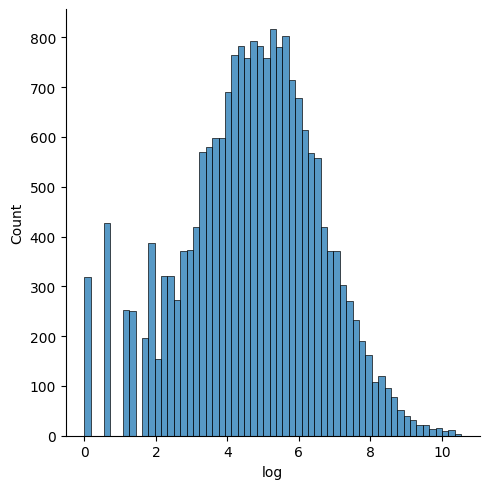

In [526]:
sns.displot(y)

In [540]:
import torch.nn as nn
import torch.optim as optim

# Define the updated model with simplified layers, regularization, and dropout
class DCN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.4, l2_reg=1e-5):
        super(DCN, self).__init__()
        
        # Wide part (linear)
        self.wide = nn.Linear(input_dim, 1)
        
        # Deep part (non-linear)
        self.deep = nn.Sequential(
            nn.Linear(input_dim, 64),   # Reduced from 128 to 64
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),          # Reduced from 64 to 32
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 16),          # Reduced from 32 to 16
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Output layer
        self.output = nn.Linear(16 + 1, 1)  # Deep part + wide part (added)
        
        # L2 regularization
        self.l2_reg = l2_reg
    
    def forward(self, x):
        wide_out = self.wide(x)  # Wide part
        deep_out = self.deep(x)  # Deep part
        deep_out = deep_out.view(deep_out.size(0), -1)  # Flatten
        combined = torch.cat([wide_out, deep_out], dim=1)  # Combine wide and deep parts
        output = self.output(combined)  # Final output
        return output

# Initialize the model
input_dim = X_train.shape[1]
model = DCN(input_dim, dropout_rate=0.4, l2_reg=1e-5)

# Apply Xavier initialization
xavier_init(model)

# Use AdamW optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

# SMAPE calculation function for real scale
def smape(y_true, y_pred):
    numerator = torch.abs(y_true - y_pred)
    denominator = (torch.abs(y_true) + torch.abs(y_pred)) / 2
    return 200 * torch.mean(numerator / denominator)

# Use gradient clipping to stabilize the optimization
def clip_gradients(model, max_norm=1.0):
    for param in model.parameters():
        if param.grad is not None:
            torch.nn.utils.clip_grad_norm_(param, max_norm)

In [541]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

full_dataset = TensorDataset(X_tensor, y_tensor)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)


In [543]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Define the DCN model (already updated with dropout and regularization)
class DCN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.4, l2_reg=1e-5):
        super(DCN, self).__init__()
        
        # Wide part (linear)
        self.wide = nn.Linear(input_dim, 1)
        
        # Deep part (non-linear)
        self.deep = nn.Sequential(
            nn.Linear(input_dim, 64),   # Reduced from 128 to 64
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),          # Reduced from 64 to 32
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 16),          # Reduced from 32 to 16
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Output layer
        self.output = nn.Linear(16 + 1, 1)  # Deep part + wide part (added)
        
        # L2 regularization
        self.l2_reg = l2_reg
    
    def forward(self, x):
        wide_out = self.wide(x)  # Wide part
        deep_out = self.deep(x)  # Deep part
        deep_out = deep_out.view(deep_out.size(0), -1)  # Flatten
        combined = torch.cat([wide_out, deep_out], dim=1)  # Combine wide and deep parts
        output = self.output(combined)  # Final output
        return output

# Xavier initialization
def xavier_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  # Apply Xavier uniform initialization
            if m.bias is not None:
                nn.init.zeros_(m.bias)  # Initialize biases to zero

# Define SMAPE metric (log scale)
def smape(y_true, y_pred):
    numerator = torch.abs(y_true - y_pred)
    denominator = (torch.abs(y_true) + torch.abs(y_pred)) / 2
    return 200 * torch.mean(numerator / denominator)

# Gradient clipping
def clip_gradients(model, max_norm=1.0):
    for param in model.parameters():
        if param.grad is not None:
            torch.nn.utils.clip_grad_norm_(param, max_norm)

# Define the training function for each fold
def train_fold(fold, model, train_loader, val_loader, optimizer, criterion, scheduler, early_stopping_patience=3):
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    running_train_loss = 0.0
    running_train_smape = 0.0
    running_val_loss = 0.0
    running_val_smape = 0.0

    # Training loop with early stopping and gradient clipping
    for epoch in range(10):  # Assume 10 epochs for each fold
        model.train()
        running_train_loss = 0.0
        running_train_smape = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Clear gradients
            
            # Forward pass
            outputs = model(inputs)
            
            # Compute loss and SMAPE
            loss = criterion(outputs.squeeze(), targets.squeeze())
            smape_value = smape(targets.squeeze(), outputs.squeeze())
            
            # Backward pass
            loss.backward()
            
            # Clip gradients to stabilize training
            clip_gradients(model)
            
            # Optimize
            optimizer.step()
            
            running_train_loss += loss.item()
            running_train_smape += smape_value.item()

        # Calculate average training loss and SMAPE
        avg_train_loss = running_train_loss / len(train_loader)
        avg_train_smape = running_train_smape / len(train_loader)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        running_val_smape = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss = criterion(outputs.squeeze(), targets.squeeze())
                val_smape_value = smape(targets.squeeze(), outputs.squeeze())
                running_val_loss += val_loss.item()
                running_val_smape += val_smape_value.item()

        avg_val_loss = running_val_loss / len(val_loader)
        avg_val_smape = running_val_smape / len(val_loader)

        # Learning rate scheduler
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered at fold {fold+1}")
            break
        
        # Print results for this epoch
        print(f"Epoch [{epoch+1}/10] Fold {fold+1}")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train SMAPE: {avg_train_smape:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val SMAPE: {avg_val_smape:.4f}")

# K-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
fold = 0

# Cross-validation loop
for train_index, val_index in kf.split(X_tensor):
    fold += 1
    print(f"\nTraining fold {fold}")
    
    X_train_fold, X_val_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_val_fold = y_tensor[train_index], y_tensor[val_index]
    
    # Create DataLoaders for this fold
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    val_dataset = TensorDataset(X_val_fold, y_val_fold)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Initialize model, optimizer, criterion, and scheduler
    model = DCN(input_dim=X_tensor.shape[1])
    xavier_init(model)  # Apply Xavier initialization
    
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = nn.MSELoss()  # Mean Squared Error loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)
    
    # Train this fold
    train_fold(fold, model, train_loader, val_loader, optimizer, criterion, scheduler)



Training fold 1
Epoch [1/10] Fold 2
  Train Loss: 6.5405, Train SMAPE: 103.8889
  Val Loss: 3.5157, Val SMAPE: 71.9302
Epoch [2/10] Fold 2
  Train Loss: 3.7760, Train SMAPE: 73.9334
  Val Loss: 3.4310, Val SMAPE: 70.5016
Epoch [3/10] Fold 2
  Train Loss: 3.4847, Train SMAPE: 70.8859
  Val Loss: 3.4494, Val SMAPE: 70.9080
Epoch [4/10] Fold 2
  Train Loss: 3.4474, Train SMAPE: 70.4689
  Val Loss: 3.4102, Val SMAPE: 70.4059
Epoch [5/10] Fold 2
  Train Loss: 3.4231, Train SMAPE: 70.4261
  Val Loss: 3.4025, Val SMAPE: 70.3305
Epoch [6/10] Fold 2
  Train Loss: 3.4249, Train SMAPE: 70.4355
  Val Loss: 3.4151, Val SMAPE: 70.5032
Epoch [7/10] Fold 2
  Train Loss: 3.4086, Train SMAPE: 70.2492
  Val Loss: 3.3885, Val SMAPE: 70.1489
Epoch [8/10] Fold 2
  Train Loss: 3.3856, Train SMAPE: 69.9579
  Val Loss: 3.3681, Val SMAPE: 69.5192
Epoch [9/10] Fold 2
  Train Loss: 3.3829, Train SMAPE: 69.8728
  Val Loss: 3.3654, Val SMAPE: 69.7958
Epoch [10/10] Fold 2
  Train Loss: 3.3706, Train SMAPE: 69.9477


In [546]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Make predictions on the entire dataset (or use the validation/test set)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Use the trained model to predict on the full dataset (X_tensor contains the feature data)
    y_pred_log = model(X_tensor)  # Predictions in log scale

# Step 2: Inverse transform the log scale predictions and actual values to real scale
y_pred_real = torch.exp(y_pred_log) - 1  # Convert predictions from log scale to real scale
y_real = torch.exp(y_tensor) - 1  # Convert actual values from log scale to real scale

# Step 3: Plotting the distributions of predictions and actual values


In [555]:
pd.DataFrame(y_real.numpy()).describe(), pd.DataFrame(y_pred_real.numpy()).describe()

(                  0
 count  20210.000000
 mean     525.165283
 std     1632.040405
 min        0.000000
 25%       33.000000
 50%      120.999977
 75%      393.999969
 max    37791.015625,
                   0
 count  20210.000000
 mean     115.012169
 std       74.089729
 min        7.604063
 25%       83.968046
 50%       94.247227
 75%      117.413126
 max     2001.001099)

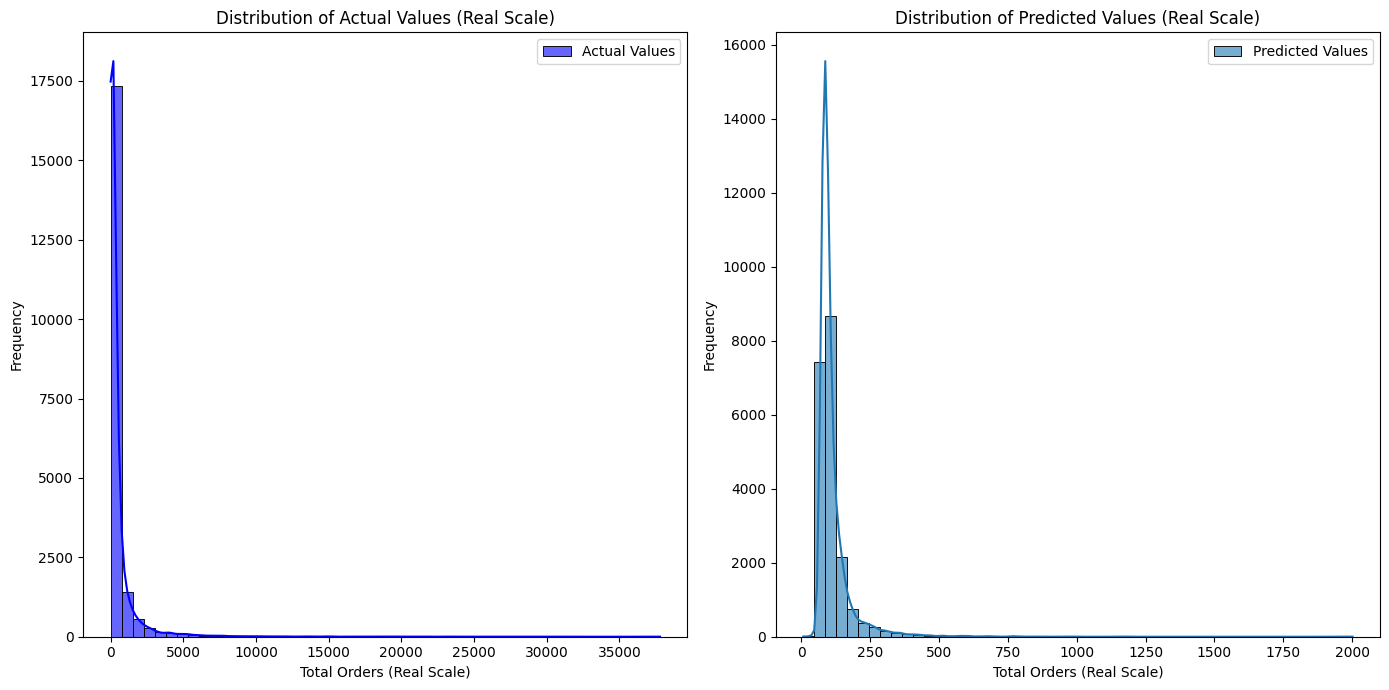

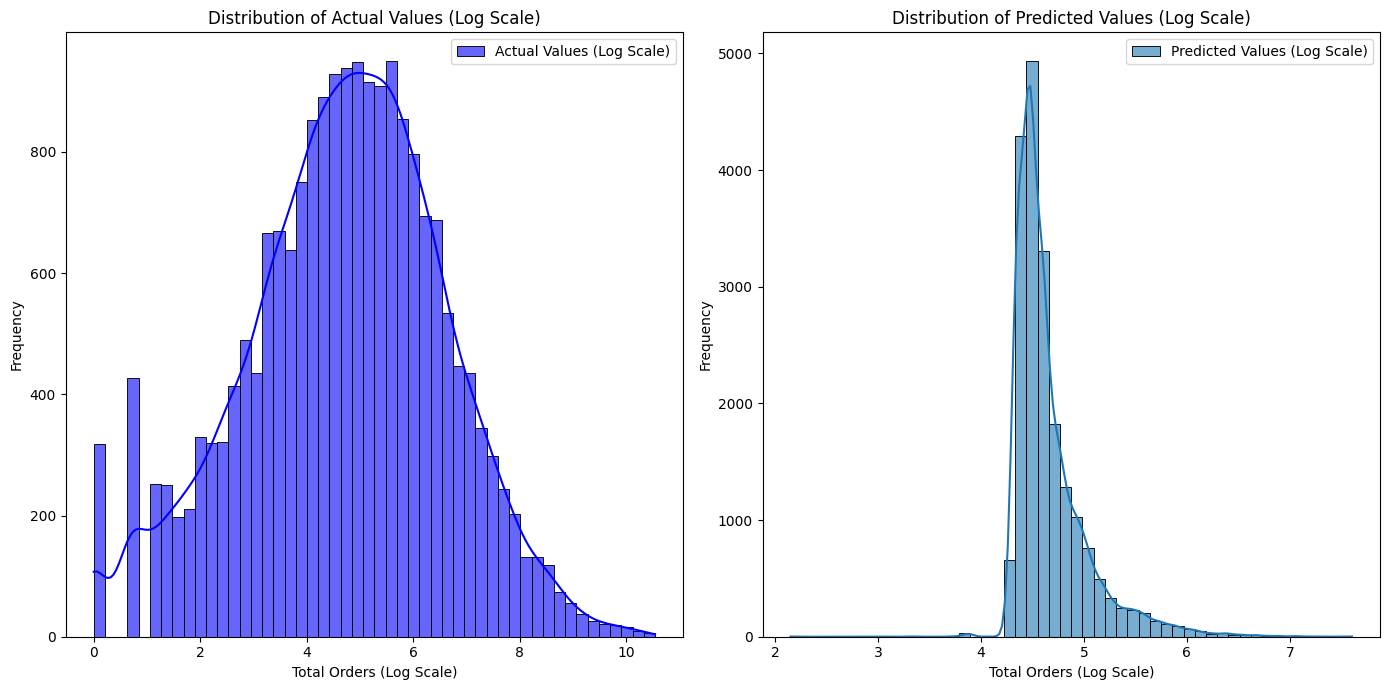

In [556]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Plotting the distribution of actual values and predicted values in real scale

plt.figure(figsize=(14, 7))

# Plot for Actual values (Real Scale)
plt.subplot(1, 2, 1)
sns.histplot(y_real.numpy(), kde=True, color='blue', bins=50, label='Actual Values', alpha=0.6)
plt.title('Distribution of Actual Values (Real Scale)')
plt.xlabel('Total Orders (Real Scale)')
plt.ylabel('Frequency')
plt.legend()

# Plot for Predicted values (Real Scale)
plt.subplot(1, 2, 2)
sns.histplot(y_pred_real.numpy(), kde=True, color='red', bins=50, label='Predicted Values', alpha=0.6)
plt.title('Distribution of Predicted Values (Real Scale)')
plt.xlabel('Total Orders (Real Scale)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Step 2: Plotting the distribution of actual values and predicted values in log scale

plt.figure(figsize=(14, 7))

# Plot for Actual values (Log Scale)
plt.subplot(1, 2, 1)
sns.histplot(torch.log(y_real + 1).numpy(), kde=True, color='blue', bins=50, label='Actual Values (Log Scale)', alpha=0.6)
plt.title('Distribution of Actual Values (Log Scale)')
plt.xlabel('Total Orders (Log Scale)')
plt.ylabel('Frequency')
plt.legend()

# Plot for Predicted values (Log Scale)
plt.subplot(1, 2, 2)
sns.histplot(torch.log(y_pred_real + 1).numpy(), kde=True, color='red', bins=50, label='Predicted Values (Log Scale)', alpha=0.6)
plt.title('Distribution of Predicted Values (Log Scale)')
plt.xlabel('Total Orders (Log Scale)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [561]:
feature_cols = ['vendor_id','city','lower_embeddings','lat','lng','weighted_n_ratings_clean','weighted_rating','weighted_n_ratings','total_orders']
df_data = curated_df[feature_cols]
df_data=df_data[df_data['total_orders'].notna()]
# Min-Max scaling ensures scaled orders are always in the [0, 1] range
df_data['scaled_orders'] = df_data.groupby('city')['total_orders'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df_data['scaled_orders'] = df_data.groupby('city')['scaled_orders'].transform(lambda x: x - x.min() + 1)

# Check the result
print(df_data[['city', 'total_orders', 'scaled_orders']].head(20))


             city  total_orders  scaled_orders
0           dubai        1532.0       1.046409
1           dubai         218.0       1.006604
2       abu dhabi          58.0       1.001535
3          al ain         627.0       1.022582
4           ajman         242.0       1.007896
5           dubai           5.0       1.000151
6         sharjah        1232.0       1.038348
7   umm al quwain        3053.0       1.299656
8   umm al quwain        6545.0       1.642850
9        fujairah        1120.0       1.037614
10       fujairah        9144.0       1.307093
11       fujairah        3859.0       1.129601
12       fujairah        4057.0       1.136251
13      abu dhabi        2773.0       1.073377
14      abu dhabi        4725.0       1.125030
15      abu dhabi        5440.0       1.143950
16      abu dhabi        4764.0       1.126062
17      abu dhabi        2802.0       1.074145
19          ajman         704.0       1.022970
20         al ain         224.0       1.008068


In [563]:
df_data['rank'] = df_data.groupby('city')['scaled_orders'].rank(method='first', ascending=False)

# Check the result
print(df_data[['city', 'total_orders', 'scaled_orders', 'rank']].head(20))

             city  total_orders  scaled_orders    rank
0           dubai        1532.0       1.046409   638.0
1           dubai         218.0       1.006604  3281.0
2       abu dhabi          58.0       1.001535  2944.0
3          al ain         627.0       1.022582   284.0
4           ajman         242.0       1.007896   360.0
5           dubai           5.0       1.000151  9423.0
6         sharjah        1232.0       1.038348   177.0
7   umm al quwain        3053.0       1.299656    11.0
8   umm al quwain        6545.0       1.642850     5.0
9        fujairah        1120.0       1.037614    85.0
10       fujairah        9144.0       1.307093     8.0
11       fujairah        3859.0       1.129601    18.0
12       fujairah        4057.0       1.136251    16.0
13      abu dhabi        2773.0       1.073377   167.0
14      abu dhabi        4725.0       1.125030    78.0
15      abu dhabi        5440.0       1.143950    63.0
16      abu dhabi        4764.0       1.126062    76.0
17      ab

In [564]:

df_data = add_lat_lng_transformations(df_data)

In [566]:
df_data.fillna(0,inplace=True)

In [567]:
feature_columns = ['lower_embeddings','cos_lat','sin_lat','cos_lng','sin_lng','weighted_n_ratings_clean','weighted_rating','weighted_n_ratings']
y=df_data['rank']

In [568]:
df_data = df_data[feature_columns]

In [569]:
df_data.head()

lower_embeddings   cos_lat   sin_lat  \
0  [0.002702070400118828, 0.011856542900204659, -...  0.904929  0.425562   
1  [0.002709598746150732, 0.011859375983476639, -...  0.905112  0.425173   
2  [-0.030378324910998344, -0.002989533357322216,...  0.912227  0.409684   
3  [-0.030509663745760918, 0.01497742161154747, 0...  0.911874  0.410469   
4  [-0.026231572031974792, -0.006357351318001747,...  0.903417  0.428762   

    cos_lng   sin_lng  weighted_n_ratings_clean  weighted_rating  \
0  0.569840  0.821756                  0.000000            0.000   
1  0.570578  0.821244                  0.534452            2.880   
2  0.564445  0.825471                  0.008067            0.675   
3  0.563199  0.826321                  0.010008            1.250   
4  0.566320  0.824186                  0.000000            0.000   

   weighted_n_ratings  
0                0.00  
1              161.75  
2                0.30  
3                1.75  
4                0.00

In [571]:
df_data[['weighted_n_ratings_clean', 'weighted_rating', 'weighted_n_ratings']] = df_data[['weighted_n_ratings_clean', 'weighted_rating', 'weighted_n_ratings']].transform(lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1)


/var/folders/vf/db_cywxx4hdfjknld_mqwsr1dh2vl3/T/ipykernel_38444/3351466289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[['weighted_n_ratings_clean', 'weighted_rating', 'weighted_n_ratings']] = df_data[['weighted_n_ratings_clean', 'weighted_rating', 'weighted_n_ratings']].transform(lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1)


In [573]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Example of the DataFrame (assumed structure)
# df_data = pd.DataFrame({'city': ['city1', 'city1', 'city2', 'city2', ...],
#                         'total_orders': [100, 200, 50, 400, ...],
#                         'weighted_n_ratings_clean': [...],
#                         'weighted_rating': [...],
#                         'weighted_n_ratings': [...]})


# Step 4: Preparing data for model training
feature_columns = ['lower_embeddings','cos_lat','sin_lat','cos_lng','sin_lng','weighted_n_ratings_clean','weighted_rating','weighted_n_ratings']

# Define X (features) and y (target)
X = df_data[feature_columns].values  # Feature data
y = y # Target is the rank

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create DataLoader for batching
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Step 5: Model Definition (DCN - Deep Cross Network)
class DCN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.4):
        super(DCN, self).__init__()
        
        # Wide part (linear)
        self.wide = nn.Linear(input_dim, 1)
        
        # Deep part (non-linear)
        self.deep = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Output layer
        self.output = nn.Linear(16 + 1, 1)  # Deep part + wide part (added)
    
    def forward(self, x):
        wide_out = self.wide(x)  # Wide part
        deep_out = self.deep(x)  # Deep part
        deep_out = deep_out.view(deep_out.size(0), -1)  # Flatten
        combined = torch.cat([wide_out, deep_out], dim=1)  # Combine wide and deep parts
        output = self.output(combined)  # Final output
        return output

# Step 6: Model Initialization, Optimizer, and Loss Function
model = DCN(input_dim=X_tensor.shape[1])  # Initialize the model
xavier_init(model)  # Apply Xavier initialization

# Optimizer and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()  # Mean Squared Error loss (for rank prediction)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

# Step 7: Training the Model
def train_rank_model(model, train_loader, optimizer, criterion, scheduler, early_stopping_patience=3):
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    running_train_loss = 0.0

    for epoch in range(10):  # Set number of epochs
        model.train()
        running_train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Clear gradients
            
            # Forward pass
            outputs = model(inputs)
            
            # Compute loss (MSE)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            
            # Backward pass
            loss.backward()
            
            # Optimize
            optimizer.step()
            
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        
        # Learning rate scheduler
        scheduler.step(avg_train_loss)

        # Early stopping check
        if avg_train_loss < best_val_loss:
            best_val_loss = avg_train_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered")
            break
        
        # Print results for this epoch
        print(f"Epoch [{epoch+1}/10]")
        print(f"  Train Loss: {avg_train_loss:.4f}")

# Train the model
train_rank_model(model, train_loader, optimizer, criterion, scheduler)

# Step 8: Prediction and Evaluation

# Step 8.1: Make Predictions
model.eval()
with torch.no_grad():
    y_pred_rank = model(X_tensor)

# Step 8.2: Plotting Actual Ranks vs Predicted Ranks
plt.figure(figsize=(8, 6))
plt.scatter(y_tensor.numpy(), y_pred_rank.numpy(), alpha=0.6, c='blue', label='Predicted vs Actual')
plt.plot([min(y_tensor), max(y_tensor)], [min(y_tensor), max(y_tensor)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title('Predicted vs Actual Ranks')
plt.legend()
plt.show()

# Step 8.3: Plotting Distribution of Ranks

plt.figure(figsize=(14, 7))

# Plot for Actual ranks
plt.subplot(1, 2, 1)
sns.histplot(y_tensor.numpy(), kde=True, color='blue', bins=50, label='Actual Ranks', alpha=0.6)
plt.title('Distribution of Actual Ranks')
plt.xlabel('Ranks')
plt.ylabel('Frequency')
plt.legend()

# Plot for Predicted ranks
plt.subplot(1, 2, 2)
sns


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [574]:
df_data[feature_columns].values

array([[list([0.002702070400118828, 0.011856542900204659, -0.02698284201323986, -0.13616256415843964, -0.007181746885180473, 0.14186786115169525, 0.06577400863170624, -0.01974136382341385, 0.029962707310914993, 0.05027564987540245, -0.04063768312335014, -0.03574588894844055, -0.10234738886356354, 0.017753157764673233, 0.052570268511772156, 0.008783362805843353, 0.0354890450835228, -0.05113289877772331, 0.06774498522281647, 0.12475971132516861, 0.046505022794008255, -0.009422047063708305, 0.010797237977385521, -0.05695062875747681, -0.030736099928617477, 0.017601393163204193, -0.018318410962820053, -0.0011035888455808163, 0.038285207003355026, -0.26934248208999634, 0.05999615415930748, 0.04593317583203316]),
        0.9049293832493277, 0.42556175971531024, ..., -1.0, -1.0, -1.0],
       [list([0.002709598746150732, 0.011859375983476639, -0.027006564661860466, -0.1361827403306961, -0.007002607919275761, 0.1418985277414322, 0.06576566398143768, -0.01973757892847061, 0.029961852356791496, 